In [1]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [3]:
_docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(_docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [4]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(_docs[ix])

In [5]:
sim_mat = cosine_similarity(val_vecs, _docs)

In [6]:
best = {}
for i, vec in enumerate(tqdm_notebook(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:00<00:00, 36785.13it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


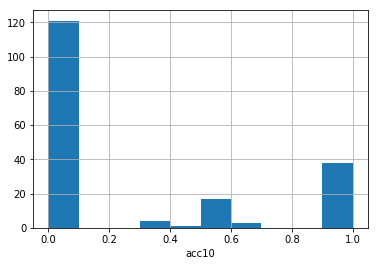

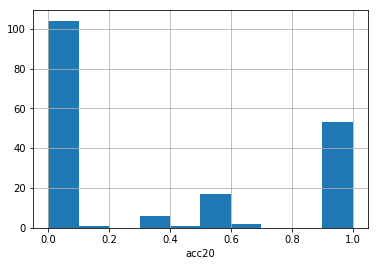

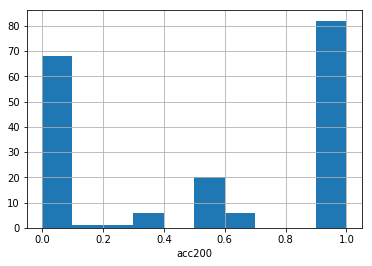

In [7]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [9]:
for i, (k, v) in enumerate(gold.items()):
    if len(set(v).intersection(best[k])) == 0:
        print(i, k)

(0, u'59a7bc6c782b1b893a56a8a9')
(3, u'59a7bc6c782b1b893a56a89f')
(10, u'59a7bc66782b1b893a56a844')
(14, u'59a7bc6a782b1b893a56a87c')
(15, u'59a7bc6a782b1b893a56a87a')
(16, u'59a7bc6a782b1b893a56a87e')
(21, u'59a7bc59782b1b893a56a753')
(25, u'59a7bc59782b1b893a56a751')
(27, u'59a7bc59782b1b893a56a759')
(28, u'59a7bc65782b1b893a56a831')
(29, u'59a7bc62782b1b893a56a812')
(31, u'59a7bc5d782b1b893a56a7a7')
(35, u'59a7bc6d782b1b893a56a8b3')
(36, u'59a7bc67782b1b893a56a856')
(40, u'59a7bc6b782b1b893a56a897')
(41, u'59a7bc6d782b1b893a56a8b9')
(42, u'59a7bc67782b1b893a56a858')
(48, u'59a7bc5d782b1b893a56a7a9')
(50, u'59a7bc60782b1b893a56a7e7')
(53, u'59a7bc69782b1b893a56a875')
(55, u'59a7bc5b782b1b893a56a78b')
(56, u'59a7bc6f782b1b893a56a8e6')
(57, u'59a7bc6f782b1b893a56a8e4')
(59, u'59a7bc6f782b1b893a56a8e0')
(67, u'59a7bc6a782b1b893a56a882')
(71, u'59a7bc5f782b1b893a56a7cf')
(72, u'59a7bc6d782b1b893a56a8bf')
(73, u'59a7bc5f782b1b893a56a7cd')
(78, u'59a7bc65782b1b893a56a82f')
(80, u'59a7bc5b7

In [15]:
gold['59a7bc6e782b1b893a56a8c9']

[u'5984b952b6b1133dab63852f']

In [21]:
best['59a7bc6e782b1b893a56a8c9'][2]

'5984dd43b6b11333b56384fc'

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

100%|██████████| 368458/368458 [00:04<00:00, 73972.37it/s] 


0

In [5]:
embedding_size = 300
batch_size = 64
learning_rate = 0.001
sizes=[300, 200]

In [9]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=True, loss_function='exp_loss')
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:], batch_size) #batch_size*500
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-10-13 13:16:22,540 [MainThread  ] [INFO ]  start training ...
2017-10-13 13:16:26,194 [MainThread  ] [INFO ]  step 0, loss 0.489243
2017-10-13 13:16:26,219 [MainThread  ] [INFO ]  step 1, loss 0.500079
2017-10-13 13:16:26,346 [MainThread  ] [INFO ]  step 2, loss 0.499681
2017-10-13 13:16:26,373 [MainThread  ] [INFO ]  step 3, loss 0.503317
2017-10-13 13:16:26,403 [MainThread  ] [INFO ]  step 4, loss 0.496293
2017-10-13 13:16:26,420 [MainThread  ] [INFO ]  step 5, loss 0.47444
2017-10-13 13:16:26,437 [MainThread  ] [INFO ]  step 6, loss 0.470783
2017-10-13 13:16:26,455 [MainThread  ] [INFO ]  step 7, loss 0.479297
2017-10-13 13:16:26,470 [MainThread  ] [INFO ]  step 8, loss 0.484395
2017-10-13 13:16:26,486 [MainThread  ] [INFO ]  step 9, loss 0.455083
2017-10-13 13:16:26,503 [MainThread  ] [INFO ]  step 10, loss 0.464978
2017-10-13 13:16:26,516 [MainThread  ] [INFO ]  step 11, loss 0.467944
2017-10-13 13:16:26,528 [MainThread  ] [INFO ]  step 12, loss 0.468848
2017-10-13 13:16:26,5

2017-10-13 13:16:28,841 [MainThread  ] [INFO ]  step 115, loss 0.399379
2017-10-13 13:16:28,857 [MainThread  ] [INFO ]  step 116, loss 0.408278
2017-10-13 13:16:28,875 [MainThread  ] [INFO ]  step 117, loss 0.400605
2017-10-13 13:16:28,889 [MainThread  ] [INFO ]  step 118, loss 0.39939
2017-10-13 13:16:29,004 [MainThread  ] [INFO ]  step 119, loss 0.419883
2017-10-13 13:16:29,020 [MainThread  ] [INFO ]  step 120, loss 0.40426
2017-10-13 13:16:29,034 [MainThread  ] [INFO ]  step 121, loss 0.392789
2017-10-13 13:16:29,048 [MainThread  ] [INFO ]  step 122, loss 0.41367
2017-10-13 13:16:29,063 [MainThread  ] [INFO ]  step 123, loss 0.375037
2017-10-13 13:16:29,076 [MainThread  ] [INFO ]  step 124, loss 0.40603
2017-10-13 13:16:29,091 [MainThread  ] [INFO ]  step 125, loss 0.42716
2017-10-13 13:16:29,106 [MainThread  ] [INFO ]  step 126, loss 0.412158
2017-10-13 13:16:29,120 [MainThread  ] [INFO ]  step 127, loss 0.436743
2017-10-13 13:16:29,135 [MainThread  ] [INFO ]  step 128, loss 0.4159

2017-10-13 13:16:31,433 [MainThread  ] [INFO ]  step 230, loss 0.373986
2017-10-13 13:16:31,448 [MainThread  ] [INFO ]  step 231, loss 0.381962
2017-10-13 13:16:31,462 [MainThread  ] [INFO ]  step 232, loss 0.397916
2017-10-13 13:16:31,476 [MainThread  ] [INFO ]  step 233, loss 0.402126
2017-10-13 13:16:31,489 [MainThread  ] [INFO ]  step 234, loss 0.402338
2017-10-13 13:16:31,501 [MainThread  ] [INFO ]  step 235, loss 0.372063
2017-10-13 13:16:31,512 [MainThread  ] [INFO ]  step 236, loss 0.388626
2017-10-13 13:16:31,524 [MainThread  ] [INFO ]  step 237, loss 0.372744
2017-10-13 13:16:31,642 [MainThread  ] [INFO ]  step 238, loss 0.397382
2017-10-13 13:16:31,656 [MainThread  ] [INFO ]  step 239, loss 0.410846
2017-10-13 13:16:31,671 [MainThread  ] [INFO ]  step 240, loss 0.41255
2017-10-13 13:16:31,792 [MainThread  ] [INFO ]  step 241, loss 0.387632
2017-10-13 13:16:31,914 [MainThread  ] [INFO ]  step 242, loss 0.365592
2017-10-13 13:16:31,929 [MainThread  ] [INFO ]  step 243, loss 0.

2017-10-13 13:16:33,748 [MainThread  ] [INFO ]  step 344, loss 0.411936
2017-10-13 13:16:33,761 [MainThread  ] [INFO ]  step 345, loss 0.386823
2017-10-13 13:16:33,774 [MainThread  ] [INFO ]  step 346, loss 0.42268
2017-10-13 13:16:33,787 [MainThread  ] [INFO ]  step 347, loss 0.388789
2017-10-13 13:16:33,799 [MainThread  ] [INFO ]  step 348, loss 0.390747
2017-10-13 13:16:33,811 [MainThread  ] [INFO ]  step 349, loss 0.39718
2017-10-13 13:16:33,822 [MainThread  ] [INFO ]  step 350, loss 0.412274
2017-10-13 13:16:33,936 [MainThread  ] [INFO ]  step 351, loss 0.386871
2017-10-13 13:16:33,949 [MainThread  ] [INFO ]  step 352, loss 0.388651
2017-10-13 13:16:33,964 [MainThread  ] [INFO ]  step 353, loss 0.38087
2017-10-13 13:16:33,978 [MainThread  ] [INFO ]  step 354, loss 0.378884
2017-10-13 13:16:33,990 [MainThread  ] [INFO ]  step 355, loss 0.385596
2017-10-13 13:16:34,002 [MainThread  ] [INFO ]  step 356, loss 0.382455
2017-10-13 13:16:34,015 [MainThread  ] [INFO ]  step 357, loss 0.40

2017-10-13 13:16:36,455 [MainThread  ] [INFO ]  step 459, loss 0.381108
2017-10-13 13:16:36,561 [MainThread  ] [INFO ]  step 460, loss 0.38406
2017-10-13 13:16:36,577 [MainThread  ] [INFO ]  step 461, loss 0.391619
2017-10-13 13:16:36,590 [MainThread  ] [INFO ]  step 462, loss 0.372157
2017-10-13 13:16:36,604 [MainThread  ] [INFO ]  step 463, loss 0.422256
2017-10-13 13:16:36,620 [MainThread  ] [INFO ]  step 464, loss 0.382705
2017-10-13 13:16:36,634 [MainThread  ] [INFO ]  step 465, loss 0.362513
2017-10-13 13:16:36,648 [MainThread  ] [INFO ]  step 466, loss 0.400082
2017-10-13 13:16:36,663 [MainThread  ] [INFO ]  step 467, loss 0.382444
2017-10-13 13:16:36,678 [MainThread  ] [INFO ]  step 468, loss 0.390349
2017-10-13 13:16:36,693 [MainThread  ] [INFO ]  step 469, loss 0.404963
2017-10-13 13:16:36,803 [MainThread  ] [INFO ]  step 470, loss 0.394799
2017-10-13 13:16:36,819 [MainThread  ] [INFO ]  step 471, loss 0.384826
2017-10-13 13:16:36,833 [MainThread  ] [INFO ]  step 472, loss 0.

2017-10-13 13:16:39,804 [MainThread  ] [INFO ]  step 574, loss 0.367186
2017-10-13 13:16:39,939 [MainThread  ] [INFO ]  step 575, loss 0.389183
2017-10-13 13:16:39,963 [MainThread  ] [INFO ]  step 576, loss 0.389026
2017-10-13 13:16:40,099 [MainThread  ] [INFO ]  step 577, loss 0.388506
2017-10-13 13:16:40,116 [MainThread  ] [INFO ]  step 578, loss 0.38057
2017-10-13 13:16:40,131 [MainThread  ] [INFO ]  step 579, loss 0.383388
2017-10-13 13:16:40,148 [MainThread  ] [INFO ]  step 580, loss 0.39073
2017-10-13 13:16:40,161 [MainThread  ] [INFO ]  step 581, loss 0.374659
2017-10-13 13:16:40,176 [MainThread  ] [INFO ]  step 582, loss 0.408961
2017-10-13 13:16:40,298 [MainThread  ] [INFO ]  step 583, loss 0.395205
2017-10-13 13:16:40,319 [MainThread  ] [INFO ]  step 584, loss 0.388082
2017-10-13 13:16:40,335 [MainThread  ] [INFO ]  step 585, loss 0.384602
2017-10-13 13:16:40,352 [MainThread  ] [INFO ]  step 586, loss 0.40899
2017-10-13 13:16:40,366 [MainThread  ] [INFO ]  step 587, loss 0.38

2017-10-13 13:16:42,762 [MainThread  ] [INFO ]  step 688, loss 0.393561
2017-10-13 13:16:42,780 [MainThread  ] [INFO ]  step 689, loss 0.383141
2017-10-13 13:16:42,797 [MainThread  ] [INFO ]  step 690, loss 0.367884
2017-10-13 13:16:42,814 [MainThread  ] [INFO ]  step 691, loss 0.394773
2017-10-13 13:16:42,942 [MainThread  ] [INFO ]  step 692, loss 0.386748
2017-10-13 13:16:42,957 [MainThread  ] [INFO ]  step 693, loss 0.370383
2017-10-13 13:16:42,972 [MainThread  ] [INFO ]  step 694, loss 0.395648
2017-10-13 13:16:42,986 [MainThread  ] [INFO ]  step 695, loss 0.385688
2017-10-13 13:16:43,004 [MainThread  ] [INFO ]  step 696, loss 0.392077
2017-10-13 13:16:43,026 [MainThread  ] [INFO ]  step 697, loss 0.39857
2017-10-13 13:16:43,046 [MainThread  ] [INFO ]  step 698, loss 0.378235
2017-10-13 13:16:43,066 [MainThread  ] [INFO ]  step 699, loss 0.394943
2017-10-13 13:16:43,082 [MainThread  ] [INFO ]  step 700, loss 0.401196
2017-10-13 13:16:43,100 [MainThread  ] [INFO ]  step 701, loss 0.

2017-10-13 13:16:45,646 [MainThread  ] [INFO ]  step 802, loss 0.37438
2017-10-13 13:16:45,658 [MainThread  ] [INFO ]  step 803, loss 0.393352
2017-10-13 13:16:45,670 [MainThread  ] [INFO ]  step 804, loss 0.380535
2017-10-13 13:16:45,683 [MainThread  ] [INFO ]  step 805, loss 0.373125
2017-10-13 13:16:45,696 [MainThread  ] [INFO ]  step 806, loss 0.357344
2017-10-13 13:16:45,709 [MainThread  ] [INFO ]  step 807, loss 0.382259
2017-10-13 13:16:45,818 [MainThread  ] [INFO ]  step 808, loss 0.375863
2017-10-13 13:16:45,831 [MainThread  ] [INFO ]  step 809, loss 0.402891
2017-10-13 13:16:45,844 [MainThread  ] [INFO ]  step 810, loss 0.383099
2017-10-13 13:16:45,956 [MainThread  ] [INFO ]  step 811, loss 0.392892
2017-10-13 13:16:45,969 [MainThread  ] [INFO ]  step 812, loss 0.397004
2017-10-13 13:16:45,982 [MainThread  ] [INFO ]  step 813, loss 0.397001
2017-10-13 13:16:45,995 [MainThread  ] [INFO ]  step 814, loss 0.355227
2017-10-13 13:16:46,007 [MainThread  ] [INFO ]  step 815, loss 0.

2017-10-13 13:16:48,859 [MainThread  ] [INFO ]  step 916, loss 0.37745
2017-10-13 13:16:48,871 [MainThread  ] [INFO ]  step 917, loss 0.378667
2017-10-13 13:16:48,884 [MainThread  ] [INFO ]  step 918, loss 0.396792
2017-10-13 13:16:48,897 [MainThread  ] [INFO ]  step 919, loss 0.394182
2017-10-13 13:16:48,911 [MainThread  ] [INFO ]  step 920, loss 0.36726
2017-10-13 13:16:48,923 [MainThread  ] [INFO ]  step 921, loss 0.377551
2017-10-13 13:16:48,934 [MainThread  ] [INFO ]  step 922, loss 0.384065
2017-10-13 13:16:48,945 [MainThread  ] [INFO ]  step 923, loss 0.366988
2017-10-13 13:16:48,957 [MainThread  ] [INFO ]  step 924, loss 0.384641
2017-10-13 13:16:48,968 [MainThread  ] [INFO ]  step 925, loss 0.381162
2017-10-13 13:16:48,981 [MainThread  ] [INFO ]  step 926, loss 0.373957
2017-10-13 13:16:48,992 [MainThread  ] [INFO ]  step 927, loss 0.390197
2017-10-13 13:16:49,004 [MainThread  ] [INFO ]  step 928, loss 0.381038
2017-10-13 13:16:49,016 [MainThread  ] [INFO ]  step 929, loss 0.3

2017-10-13 13:16:51,559 [MainThread  ] [INFO ]  step 1030, loss 0.359102
2017-10-13 13:16:51,571 [MainThread  ] [INFO ]  step 1031, loss 0.373544
2017-10-13 13:16:51,584 [MainThread  ] [INFO ]  step 1032, loss 0.40131
2017-10-13 13:16:51,597 [MainThread  ] [INFO ]  step 1033, loss 0.390622
2017-10-13 13:16:51,609 [MainThread  ] [INFO ]  step 1034, loss 0.379442
2017-10-13 13:16:51,624 [MainThread  ] [INFO ]  step 1035, loss 0.382579
2017-10-13 13:16:51,636 [MainThread  ] [INFO ]  step 1036, loss 0.394672
2017-10-13 13:16:51,650 [MainThread  ] [INFO ]  step 1037, loss 0.381176
2017-10-13 13:16:51,663 [MainThread  ] [INFO ]  step 1038, loss 0.381928
2017-10-13 13:16:51,674 [MainThread  ] [INFO ]  step 1039, loss 0.384034
2017-10-13 13:16:51,686 [MainThread  ] [INFO ]  step 1040, loss 0.376204
2017-10-13 13:16:51,698 [MainThread  ] [INFO ]  step 1041, loss 0.392113
2017-10-13 13:16:51,711 [MainThread  ] [INFO ]  step 1042, loss 0.386137
2017-10-13 13:16:51,723 [MainThread  ] [INFO ]  step

2017-10-13 13:16:53,944 [MainThread  ] [INFO ]  step 1143, loss 0.377451
2017-10-13 13:16:53,959 [MainThread  ] [INFO ]  step 1144, loss 0.381747
2017-10-13 13:16:53,973 [MainThread  ] [INFO ]  step 1145, loss 0.379183
2017-10-13 13:16:53,986 [MainThread  ] [INFO ]  step 1146, loss 0.389034
2017-10-13 13:16:54,000 [MainThread  ] [INFO ]  step 1147, loss 0.374777
2017-10-13 13:16:54,012 [MainThread  ] [INFO ]  step 1148, loss 0.378074
2017-10-13 13:16:54,024 [MainThread  ] [INFO ]  step 1149, loss 0.381389
2017-10-13 13:16:54,035 [MainThread  ] [INFO ]  step 1150, loss 0.38739
2017-10-13 13:16:54,049 [MainThread  ] [INFO ]  step 1151, loss 0.38807
2017-10-13 13:16:54,063 [MainThread  ] [INFO ]  step 1152, loss 0.396927
2017-10-13 13:16:54,179 [MainThread  ] [INFO ]  step 1153, loss 0.384731
2017-10-13 13:16:54,193 [MainThread  ] [INFO ]  step 1154, loss 0.395039
2017-10-13 13:16:54,206 [MainThread  ] [INFO ]  step 1155, loss 0.382844
2017-10-13 13:16:54,219 [MainThread  ] [INFO ]  step 

2017-10-13 13:16:57,290 [MainThread  ] [INFO ]  step 1256, loss 0.366886
2017-10-13 13:16:57,301 [MainThread  ] [INFO ]  step 1257, loss 0.375413
2017-10-13 13:16:57,312 [MainThread  ] [INFO ]  step 1258, loss 0.387471
2017-10-13 13:16:57,323 [MainThread  ] [INFO ]  step 1259, loss 0.383339
2017-10-13 13:16:57,335 [MainThread  ] [INFO ]  step 1260, loss 0.385095
2017-10-13 13:16:57,346 [MainThread  ] [INFO ]  step 1261, loss 0.35902
2017-10-13 13:16:57,358 [MainThread  ] [INFO ]  step 1262, loss 0.396466
2017-10-13 13:16:57,370 [MainThread  ] [INFO ]  step 1263, loss 0.392377
2017-10-13 13:16:57,382 [MainThread  ] [INFO ]  step 1264, loss 0.369312
2017-10-13 13:16:57,393 [MainThread  ] [INFO ]  step 1265, loss 0.362631
2017-10-13 13:16:57,405 [MainThread  ] [INFO ]  step 1266, loss 0.370262
2017-10-13 13:16:57,417 [MainThread  ] [INFO ]  step 1267, loss 0.380355
2017-10-13 13:16:57,429 [MainThread  ] [INFO ]  step 1268, loss 0.387129
2017-10-13 13:16:57,441 [MainThread  ] [INFO ]  step

2017-10-13 13:16:59,277 [MainThread  ] [INFO ]  step 1369, loss 0.373351
2017-10-13 13:16:59,288 [MainThread  ] [INFO ]  step 1370, loss 0.36994
2017-10-13 13:16:59,300 [MainThread  ] [INFO ]  step 1371, loss 0.382348
2017-10-13 13:16:59,410 [MainThread  ] [INFO ]  step 1372, loss 0.391198
2017-10-13 13:16:59,424 [MainThread  ] [INFO ]  step 1373, loss 0.402085
2017-10-13 13:16:59,436 [MainThread  ] [INFO ]  step 1374, loss 0.373948
2017-10-13 13:16:59,448 [MainThread  ] [INFO ]  step 1375, loss 0.39563
2017-10-13 13:16:59,459 [MainThread  ] [INFO ]  step 1376, loss 0.400284
2017-10-13 13:16:59,572 [MainThread  ] [INFO ]  step 1377, loss 0.376109
2017-10-13 13:16:59,689 [MainThread  ] [INFO ]  step 1378, loss 0.365805
2017-10-13 13:16:59,702 [MainThread  ] [INFO ]  step 1379, loss 0.389543
2017-10-13 13:16:59,715 [MainThread  ] [INFO ]  step 1380, loss 0.39823
2017-10-13 13:16:59,727 [MainThread  ] [INFO ]  step 1381, loss 0.377386
2017-10-13 13:16:59,740 [MainThread  ] [INFO ]  step 1

2017-10-13 13:17:02,383 [MainThread  ] [INFO ]  step 1482, loss 0.380539
2017-10-13 13:17:02,395 [MainThread  ] [INFO ]  step 1483, loss 0.375549
2017-10-13 13:17:02,408 [MainThread  ] [INFO ]  step 1484, loss 0.385054
2017-10-13 13:17:02,420 [MainThread  ] [INFO ]  step 1485, loss 0.373303
2017-10-13 13:17:02,434 [MainThread  ] [INFO ]  step 1486, loss 0.40782
2017-10-13 13:17:02,445 [MainThread  ] [INFO ]  step 1487, loss 0.378024
2017-10-13 13:17:02,457 [MainThread  ] [INFO ]  step 1488, loss 0.355974
2017-10-13 13:17:02,470 [MainThread  ] [INFO ]  step 1489, loss 0.379353
2017-10-13 13:17:02,481 [MainThread  ] [INFO ]  step 1490, loss 0.3809
2017-10-13 13:17:02,493 [MainThread  ] [INFO ]  step 1491, loss 0.365138
2017-10-13 13:17:02,505 [MainThread  ] [INFO ]  step 1492, loss 0.39908
2017-10-13 13:17:02,516 [MainThread  ] [INFO ]  step 1493, loss 0.381762
2017-10-13 13:17:02,528 [MainThread  ] [INFO ]  step 1494, loss 0.417037
2017-10-13 13:17:02,540 [MainThread  ] [INFO ]  step 14

2017-10-13 13:17:05,123 [MainThread  ] [INFO ]  step 1595, loss 0.380418
2017-10-13 13:17:05,136 [MainThread  ] [INFO ]  step 1596, loss 0.380587
2017-10-13 13:17:05,150 [MainThread  ] [INFO ]  step 1597, loss 0.407199
2017-10-13 13:17:05,163 [MainThread  ] [INFO ]  step 1598, loss 0.379637
2017-10-13 13:17:05,176 [MainThread  ] [INFO ]  step 1599, loss 0.384352
2017-10-13 13:17:05,188 [MainThread  ] [INFO ]  step 1600, loss 0.351428
2017-10-13 13:17:05,200 [MainThread  ] [INFO ]  step 1601, loss 0.367146
2017-10-13 13:17:05,212 [MainThread  ] [INFO ]  step 1602, loss 0.360346
2017-10-13 13:17:05,224 [MainThread  ] [INFO ]  step 1603, loss 0.38299
2017-10-13 13:17:05,235 [MainThread  ] [INFO ]  step 1604, loss 0.384397
2017-10-13 13:17:05,247 [MainThread  ] [INFO ]  step 1605, loss 0.373556
2017-10-13 13:17:05,259 [MainThread  ] [INFO ]  step 1606, loss 0.392382
2017-10-13 13:17:05,272 [MainThread  ] [INFO ]  step 1607, loss 0.366607
2017-10-13 13:17:05,284 [MainThread  ] [INFO ]  step

2017-10-13 13:17:07,472 [MainThread  ] [INFO ]  step 1708, loss 0.368653
2017-10-13 13:17:07,488 [MainThread  ] [INFO ]  step 1709, loss 0.368709
2017-10-13 13:17:07,501 [MainThread  ] [INFO ]  step 1710, loss 0.363191
2017-10-13 13:17:07,515 [MainThread  ] [INFO ]  step 1711, loss 0.377536
2017-10-13 13:17:07,528 [MainThread  ] [INFO ]  step 1712, loss 0.363321
2017-10-13 13:17:07,542 [MainThread  ] [INFO ]  step 1713, loss 0.382741
2017-10-13 13:17:07,555 [MainThread  ] [INFO ]  step 1714, loss 0.382086
2017-10-13 13:17:07,567 [MainThread  ] [INFO ]  step 1715, loss 0.368854
2017-10-13 13:17:07,579 [MainThread  ] [INFO ]  step 1716, loss 0.379071
2017-10-13 13:17:07,591 [MainThread  ] [INFO ]  step 1717, loss 0.371353
2017-10-13 13:17:07,603 [MainThread  ] [INFO ]  step 1718, loss 0.39132
2017-10-13 13:17:07,615 [MainThread  ] [INFO ]  step 1719, loss 0.388818
2017-10-13 13:17:07,627 [MainThread  ] [INFO ]  step 1720, loss 0.347924
2017-10-13 13:17:07,638 [MainThread  ] [INFO ]  step

2017-10-13 13:17:09,484 [MainThread  ] [INFO ]  step 1821, loss 0.382779
2017-10-13 13:17:09,496 [MainThread  ] [INFO ]  step 1822, loss 0.383731
2017-10-13 13:17:09,512 [MainThread  ] [INFO ]  step 1823, loss 0.371939
2017-10-13 13:17:09,526 [MainThread  ] [INFO ]  step 1824, loss 0.378294
2017-10-13 13:17:09,540 [MainThread  ] [INFO ]  step 1825, loss 0.369356
2017-10-13 13:17:09,552 [MainThread  ] [INFO ]  step 1826, loss 0.383016
2017-10-13 13:17:09,564 [MainThread  ] [INFO ]  step 1827, loss 0.370099
2017-10-13 13:17:09,578 [MainThread  ] [INFO ]  step 1828, loss 0.37348
2017-10-13 13:17:09,591 [MainThread  ] [INFO ]  step 1829, loss 0.390835
2017-10-13 13:17:09,604 [MainThread  ] [INFO ]  step 1830, loss 0.395442
2017-10-13 13:17:09,616 [MainThread  ] [INFO ]  step 1831, loss 0.384189
2017-10-13 13:17:09,632 [MainThread  ] [INFO ]  step 1832, loss 0.360463
2017-10-13 13:17:09,647 [MainThread  ] [INFO ]  step 1833, loss 0.377815
2017-10-13 13:17:09,662 [MainThread  ] [INFO ]  step

2017-10-13 13:17:12,171 [MainThread  ] [INFO ]  step 1934, loss 0.362539
2017-10-13 13:17:12,186 [MainThread  ] [INFO ]  step 1935, loss 0.383294
2017-10-13 13:17:12,199 [MainThread  ] [INFO ]  step 1936, loss 0.388016
2017-10-13 13:17:12,214 [MainThread  ] [INFO ]  step 1937, loss 0.378955
2017-10-13 13:17:12,227 [MainThread  ] [INFO ]  step 1938, loss 0.389211
2017-10-13 13:17:12,242 [MainThread  ] [INFO ]  step 1939, loss 0.367534
2017-10-13 13:17:12,253 [MainThread  ] [INFO ]  step 1940, loss 0.368108
2017-10-13 13:17:12,266 [MainThread  ] [INFO ]  step 1941, loss 0.38557
2017-10-13 13:17:12,278 [MainThread  ] [INFO ]  step 1942, loss 0.391044
2017-10-13 13:17:12,289 [MainThread  ] [INFO ]  step 1943, loss 0.37083
2017-10-13 13:17:12,402 [MainThread  ] [INFO ]  step 1944, loss 0.374898
2017-10-13 13:17:12,415 [MainThread  ] [INFO ]  step 1945, loss 0.389764
2017-10-13 13:17:12,428 [MainThread  ] [INFO ]  step 1946, loss 0.397204
2017-10-13 13:17:12,443 [MainThread  ] [INFO ]  step 

2017-10-13 13:17:15,270 [MainThread  ] [INFO ]  step 2047, loss 0.404689
2017-10-13 13:17:15,285 [MainThread  ] [INFO ]  step 2048, loss 0.356989
2017-10-13 13:17:15,301 [MainThread  ] [INFO ]  step 2049, loss 0.367795
2017-10-13 13:17:15,315 [MainThread  ] [INFO ]  step 2050, loss 0.370732
2017-10-13 13:17:15,329 [MainThread  ] [INFO ]  step 2051, loss 0.380996
2017-10-13 13:17:15,342 [MainThread  ] [INFO ]  step 2052, loss 0.366246
2017-10-13 13:17:15,355 [MainThread  ] [INFO ]  step 2053, loss 0.372333
2017-10-13 13:17:15,367 [MainThread  ] [INFO ]  step 2054, loss 0.372949
2017-10-13 13:17:15,380 [MainThread  ] [INFO ]  step 2055, loss 0.39765
2017-10-13 13:17:15,393 [MainThread  ] [INFO ]  step 2056, loss 0.374374
2017-10-13 13:17:15,406 [MainThread  ] [INFO ]  step 2057, loss 0.378032
2017-10-13 13:17:15,418 [MainThread  ] [INFO ]  step 2058, loss 0.353637
2017-10-13 13:17:15,432 [MainThread  ] [INFO ]  step 2059, loss 0.39912
2017-10-13 13:17:15,545 [MainThread  ] [INFO ]  step 

2017-10-13 13:17:17,644 [MainThread  ] [INFO ]  step 2160, loss 0.360553
2017-10-13 13:17:17,660 [MainThread  ] [INFO ]  step 2161, loss 0.387513
2017-10-13 13:17:17,675 [MainThread  ] [INFO ]  step 2162, loss 0.373357
2017-10-13 13:17:17,689 [MainThread  ] [INFO ]  step 2163, loss 0.373718
2017-10-13 13:17:17,702 [MainThread  ] [INFO ]  step 2164, loss 0.403468
2017-10-13 13:17:17,715 [MainThread  ] [INFO ]  step 2165, loss 0.367963
2017-10-13 13:17:17,728 [MainThread  ] [INFO ]  step 2166, loss 0.386245
2017-10-13 13:17:17,741 [MainThread  ] [INFO ]  step 2167, loss 0.394854
2017-10-13 13:17:17,752 [MainThread  ] [INFO ]  step 2168, loss 0.374812
2017-10-13 13:17:17,764 [MainThread  ] [INFO ]  step 2169, loss 0.353796
2017-10-13 13:17:17,775 [MainThread  ] [INFO ]  step 2170, loss 0.392336
2017-10-13 13:17:17,787 [MainThread  ] [INFO ]  step 2171, loss 0.394082
2017-10-13 13:17:17,897 [MainThread  ] [INFO ]  step 2172, loss 0.380145
2017-10-13 13:17:17,912 [MainThread  ] [INFO ]  ste

2017-10-13 13:17:19,922 [MainThread  ] [INFO ]  step 2273, loss 0.363634
2017-10-13 13:17:20,032 [MainThread  ] [INFO ]  step 2274, loss 0.379813
2017-10-13 13:17:20,046 [MainThread  ] [INFO ]  step 2275, loss 0.380326
2017-10-13 13:17:20,061 [MainThread  ] [INFO ]  step 2276, loss 0.391135
2017-10-13 13:17:20,073 [MainThread  ] [INFO ]  step 2277, loss 0.380179
2017-10-13 13:17:20,085 [MainThread  ] [INFO ]  step 2278, loss 0.383881
2017-10-13 13:17:20,097 [MainThread  ] [INFO ]  step 2279, loss 0.368266
2017-10-13 13:17:20,109 [MainThread  ] [INFO ]  step 2280, loss 0.367265
2017-10-13 13:17:20,121 [MainThread  ] [INFO ]  step 2281, loss 0.367178
2017-10-13 13:17:20,134 [MainThread  ] [INFO ]  step 2282, loss 0.376321
2017-10-13 13:17:20,146 [MainThread  ] [INFO ]  step 2283, loss 0.361939
2017-10-13 13:17:20,264 [MainThread  ] [INFO ]  step 2284, loss 0.360008
2017-10-13 13:17:20,283 [MainThread  ] [INFO ]  step 2285, loss 0.382518
2017-10-13 13:17:20,300 [MainThread  ] [INFO ]  ste

2017-10-13 13:17:22,915 [MainThread  ] [INFO ]  step 2386, loss 0.359651
2017-10-13 13:17:22,932 [MainThread  ] [INFO ]  step 2387, loss 0.364881
2017-10-13 13:17:22,947 [MainThread  ] [INFO ]  step 2388, loss 0.387678
2017-10-13 13:17:22,963 [MainThread  ] [INFO ]  step 2389, loss 0.369417
2017-10-13 13:17:22,979 [MainThread  ] [INFO ]  step 2390, loss 0.406171
2017-10-13 13:17:22,996 [MainThread  ] [INFO ]  step 2391, loss 0.362689
2017-10-13 13:17:23,110 [MainThread  ] [INFO ]  step 2392, loss 0.380995
2017-10-13 13:17:23,129 [MainThread  ] [INFO ]  step 2393, loss 0.383723
2017-10-13 13:17:23,145 [MainThread  ] [INFO ]  step 2394, loss 0.377012
2017-10-13 13:17:23,256 [MainThread  ] [INFO ]  step 2395, loss 0.383965
2017-10-13 13:17:23,270 [MainThread  ] [INFO ]  step 2396, loss 0.361776
2017-10-13 13:17:23,291 [MainThread  ] [INFO ]  step 2397, loss 0.384408
2017-10-13 13:17:23,307 [MainThread  ] [INFO ]  step 2398, loss 0.358032
2017-10-13 13:17:23,320 [MainThread  ] [INFO ]  ste

2017-10-13 13:17:25,948 [MainThread  ] [INFO ]  step 2499, loss 0.375895
2017-10-13 13:17:25,960 [MainThread  ] [INFO ]  step 2500, loss 0.367107
2017-10-13 13:17:25,972 [MainThread  ] [INFO ]  step 2501, loss 0.369273
2017-10-13 13:17:25,984 [MainThread  ] [INFO ]  step 2502, loss 0.382109
2017-10-13 13:17:26,096 [MainThread  ] [INFO ]  step 2503, loss 0.377563
2017-10-13 13:17:26,112 [MainThread  ] [INFO ]  step 2504, loss 0.371921
2017-10-13 13:17:26,127 [MainThread  ] [INFO ]  step 2505, loss 0.376502
2017-10-13 13:17:26,142 [MainThread  ] [INFO ]  step 2506, loss 0.369791
2017-10-13 13:17:26,255 [MainThread  ] [INFO ]  step 2507, loss 0.370718
2017-10-13 13:17:26,370 [MainThread  ] [INFO ]  step 2508, loss 0.370159
2017-10-13 13:17:26,385 [MainThread  ] [INFO ]  step 2509, loss 0.361187
2017-10-13 13:17:26,499 [MainThread  ] [INFO ]  step 2510, loss 0.360435
2017-10-13 13:17:26,511 [MainThread  ] [INFO ]  step 2511, loss 0.395743
2017-10-13 13:17:26,525 [MainThread  ] [INFO ]  ste

2017-10-13 13:17:28,909 [MainThread  ] [INFO ]  step 2612, loss 0.382775
2017-10-13 13:17:28,922 [MainThread  ] [INFO ]  step 2613, loss 0.371544
2017-10-13 13:17:28,934 [MainThread  ] [INFO ]  step 2614, loss 0.381665
2017-10-13 13:17:28,947 [MainThread  ] [INFO ]  step 2615, loss 0.367949
2017-10-13 13:17:28,958 [MainThread  ] [INFO ]  step 2616, loss 0.352932
2017-10-13 13:17:28,969 [MainThread  ] [INFO ]  step 2617, loss 0.380771
2017-10-13 13:17:28,982 [MainThread  ] [INFO ]  step 2618, loss 0.39334
2017-10-13 13:17:28,995 [MainThread  ] [INFO ]  step 2619, loss 0.377712
2017-10-13 13:17:29,007 [MainThread  ] [INFO ]  step 2620, loss 0.375946
2017-10-13 13:17:29,019 [MainThread  ] [INFO ]  step 2621, loss 0.377739
2017-10-13 13:17:29,132 [MainThread  ] [INFO ]  step 2622, loss 0.377737
2017-10-13 13:17:29,147 [MainThread  ] [INFO ]  step 2623, loss 0.380499
2017-10-13 13:17:29,261 [MainThread  ] [INFO ]  step 2624, loss 0.387024
2017-10-13 13:17:29,276 [MainThread  ] [INFO ]  step

2017-10-13 13:17:31,543 [MainThread  ] [INFO ]  step 2725, loss 0.36399
2017-10-13 13:17:31,656 [MainThread  ] [INFO ]  step 2726, loss 0.386971
2017-10-13 13:17:31,670 [MainThread  ] [INFO ]  step 2727, loss 0.38261
2017-10-13 13:17:31,684 [MainThread  ] [INFO ]  step 2728, loss 0.38021
2017-10-13 13:17:31,699 [MainThread  ] [INFO ]  step 2729, loss 0.389147
2017-10-13 13:17:31,714 [MainThread  ] [INFO ]  step 2730, loss 0.346765
2017-10-13 13:17:31,728 [MainThread  ] [INFO ]  step 2731, loss 0.403738
2017-10-13 13:17:31,744 [MainThread  ] [INFO ]  step 2732, loss 0.358752
2017-10-13 13:17:31,758 [MainThread  ] [INFO ]  step 2733, loss 0.366889
2017-10-13 13:17:31,773 [MainThread  ] [INFO ]  step 2734, loss 0.373073
2017-10-13 13:17:31,787 [MainThread  ] [INFO ]  step 2735, loss 0.365334
2017-10-13 13:17:31,801 [MainThread  ] [INFO ]  step 2736, loss 0.36443
2017-10-13 13:17:31,815 [MainThread  ] [INFO ]  step 2737, loss 0.373562
2017-10-13 13:17:31,829 [MainThread  ] [INFO ]  step 27

2017-10-13 13:17:34,292 [MainThread  ] [INFO ]  step 2838, loss 0.393439
2017-10-13 13:17:34,310 [MainThread  ] [INFO ]  step 2839, loss 0.367633
2017-10-13 13:17:34,325 [MainThread  ] [INFO ]  step 2840, loss 0.367382
2017-10-13 13:17:34,339 [MainThread  ] [INFO ]  step 2841, loss 0.356265
2017-10-13 13:17:34,352 [MainThread  ] [INFO ]  step 2842, loss 0.36117
2017-10-13 13:17:34,365 [MainThread  ] [INFO ]  step 2843, loss 0.372546
2017-10-13 13:17:34,379 [MainThread  ] [INFO ]  step 2844, loss 0.361709
2017-10-13 13:17:34,393 [MainThread  ] [INFO ]  step 2845, loss 0.365757
2017-10-13 13:17:34,407 [MainThread  ] [INFO ]  step 2846, loss 0.35647
2017-10-13 13:17:34,421 [MainThread  ] [INFO ]  step 2847, loss 0.39152
2017-10-13 13:17:34,435 [MainThread  ] [INFO ]  step 2848, loss 0.352115
2017-10-13 13:17:34,451 [MainThread  ] [INFO ]  step 2849, loss 0.375377
2017-10-13 13:17:34,466 [MainThread  ] [INFO ]  step 2850, loss 0.378328
2017-10-13 13:17:34,583 [MainThread  ] [INFO ]  step 2

2017-10-13 13:17:36,589 [MainThread  ] [INFO ]  step 2951, loss 0.374946
2017-10-13 13:17:36,604 [MainThread  ] [INFO ]  step 2952, loss 0.37885
2017-10-13 13:17:36,617 [MainThread  ] [INFO ]  step 2953, loss 0.40266
2017-10-13 13:17:36,631 [MainThread  ] [INFO ]  step 2954, loss 0.393629
2017-10-13 13:17:36,646 [MainThread  ] [INFO ]  step 2955, loss 0.39627
2017-10-13 13:17:36,662 [MainThread  ] [INFO ]  step 2956, loss 0.382324
2017-10-13 13:17:36,677 [MainThread  ] [INFO ]  step 2957, loss 0.408456
2017-10-13 13:17:36,691 [MainThread  ] [INFO ]  step 2958, loss 0.373939
2017-10-13 13:17:36,805 [MainThread  ] [INFO ]  step 2959, loss 0.398383
2017-10-13 13:17:36,820 [MainThread  ] [INFO ]  step 2960, loss 0.387817
2017-10-13 13:17:36,836 [MainThread  ] [INFO ]  step 2961, loss 0.380539
2017-10-13 13:17:36,852 [MainThread  ] [INFO ]  step 2962, loss 0.378536
2017-10-13 13:17:36,867 [MainThread  ] [INFO ]  step 2963, loss 0.376143
2017-10-13 13:17:36,981 [MainThread  ] [INFO ]  step 2

2017-10-13 13:17:39,605 [MainThread  ] [INFO ]  step 3064, loss 0.378222
2017-10-13 13:17:39,631 [MainThread  ] [INFO ]  step 3065, loss 0.371831
2017-10-13 13:17:39,657 [MainThread  ] [INFO ]  step 3066, loss 0.366427
2017-10-13 13:17:39,679 [MainThread  ] [INFO ]  step 3067, loss 0.364979
2017-10-13 13:17:39,704 [MainThread  ] [INFO ]  step 3068, loss 0.377088
2017-10-13 13:17:39,726 [MainThread  ] [INFO ]  step 3069, loss 0.370289
2017-10-13 13:17:39,741 [MainThread  ] [INFO ]  step 3070, loss 0.365156
2017-10-13 13:17:39,863 [MainThread  ] [INFO ]  step 3071, loss 0.361624
2017-10-13 13:17:39,885 [MainThread  ] [INFO ]  step 3072, loss 0.35701
2017-10-13 13:17:40,001 [MainThread  ] [INFO ]  step 3073, loss 0.387143
2017-10-13 13:17:40,017 [MainThread  ] [INFO ]  step 3074, loss 0.365536
2017-10-13 13:17:40,031 [MainThread  ] [INFO ]  step 3075, loss 0.384836
2017-10-13 13:17:40,045 [MainThread  ] [INFO ]  step 3076, loss 0.391368
2017-10-13 13:17:40,059 [MainThread  ] [INFO ]  step

2017-10-13 13:17:42,237 [MainThread  ] [INFO ]  step 3177, loss 0.370228
2017-10-13 13:17:42,251 [MainThread  ] [INFO ]  step 3178, loss 0.361956
2017-10-13 13:17:42,265 [MainThread  ] [INFO ]  step 3179, loss 0.372221
2017-10-13 13:17:42,278 [MainThread  ] [INFO ]  step 3180, loss 0.366289
2017-10-13 13:17:42,292 [MainThread  ] [INFO ]  step 3181, loss 0.389402
2017-10-13 13:17:42,306 [MainThread  ] [INFO ]  step 3182, loss 0.362999
2017-10-13 13:17:42,324 [MainThread  ] [INFO ]  step 3183, loss 0.382644
2017-10-13 13:17:42,336 [MainThread  ] [INFO ]  step 3184, loss 0.349293
2017-10-13 13:17:42,349 [MainThread  ] [INFO ]  step 3185, loss 0.37533
2017-10-13 13:17:42,361 [MainThread  ] [INFO ]  step 3186, loss 0.362567
2017-10-13 13:17:42,372 [MainThread  ] [INFO ]  step 3187, loss 0.405124
2017-10-13 13:17:42,384 [MainThread  ] [INFO ]  step 3188, loss 0.358612
2017-10-13 13:17:42,396 [MainThread  ] [INFO ]  step 3189, loss 0.374008
2017-10-13 13:17:42,408 [MainThread  ] [INFO ]  step

2017-10-13 13:17:44,543 [MainThread  ] [INFO ]  step 3290, loss 0.372371
2017-10-13 13:17:44,555 [MainThread  ] [INFO ]  step 3291, loss 0.350323
2017-10-13 13:17:44,568 [MainThread  ] [INFO ]  step 3292, loss 0.383194
2017-10-13 13:17:44,580 [MainThread  ] [INFO ]  step 3293, loss 0.362796
2017-10-13 13:17:44,592 [MainThread  ] [INFO ]  step 3294, loss 0.39397
2017-10-13 13:17:44,607 [MainThread  ] [INFO ]  step 3295, loss 0.387805
2017-10-13 13:17:44,620 [MainThread  ] [INFO ]  step 3296, loss 0.375785
2017-10-13 13:17:44,634 [MainThread  ] [INFO ]  step 3297, loss 0.362865
2017-10-13 13:17:44,647 [MainThread  ] [INFO ]  step 3298, loss 0.396094
2017-10-13 13:17:44,660 [MainThread  ] [INFO ]  step 3299, loss 0.382571
2017-10-13 13:17:44,671 [MainThread  ] [INFO ]  step 3300, loss 0.375618
2017-10-13 13:17:44,682 [MainThread  ] [INFO ]  step 3301, loss 0.377542
2017-10-13 13:17:44,693 [MainThread  ] [INFO ]  step 3302, loss 0.375635
2017-10-13 13:17:44,705 [MainThread  ] [INFO ]  step

2017-10-13 13:17:47,543 [MainThread  ] [INFO ]  step 3403, loss 0.380447
2017-10-13 13:17:47,561 [MainThread  ] [INFO ]  step 3404, loss 0.372673
2017-10-13 13:17:47,576 [MainThread  ] [INFO ]  step 3405, loss 0.390798
2017-10-13 13:17:47,591 [MainThread  ] [INFO ]  step 3406, loss 0.388118
2017-10-13 13:17:47,605 [MainThread  ] [INFO ]  step 3407, loss 0.365963
2017-10-13 13:17:47,620 [MainThread  ] [INFO ]  step 3408, loss 0.362183
2017-10-13 13:17:47,634 [MainThread  ] [INFO ]  step 3409, loss 0.390965
2017-10-13 13:17:47,648 [MainThread  ] [INFO ]  step 3410, loss 0.398151
2017-10-13 13:17:47,662 [MainThread  ] [INFO ]  step 3411, loss 0.367178
2017-10-13 13:17:47,676 [MainThread  ] [INFO ]  step 3412, loss 0.383046
2017-10-13 13:17:47,788 [MainThread  ] [INFO ]  step 3413, loss 0.367276
2017-10-13 13:17:47,909 [MainThread  ] [INFO ]  step 3414, loss 0.362841
2017-10-13 13:17:47,928 [MainThread  ] [INFO ]  step 3415, loss 0.396344
2017-10-13 13:17:47,940 [MainThread  ] [INFO ]  ste

2017-10-13 13:17:50,947 [MainThread  ] [INFO ]  step 3516, loss 0.373018
2017-10-13 13:17:50,963 [MainThread  ] [INFO ]  step 3517, loss 0.413525
2017-10-13 13:17:50,979 [MainThread  ] [INFO ]  step 3518, loss 0.358399
2017-10-13 13:17:50,996 [MainThread  ] [INFO ]  step 3519, loss 0.370037
2017-10-13 13:17:51,011 [MainThread  ] [INFO ]  step 3520, loss 0.384722
2017-10-13 13:17:51,141 [MainThread  ] [INFO ]  step 3521, loss 0.396962
2017-10-13 13:17:51,156 [MainThread  ] [INFO ]  step 3522, loss 0.388516
2017-10-13 13:17:51,269 [MainThread  ] [INFO ]  step 3523, loss 0.361
2017-10-13 13:17:51,385 [MainThread  ] [INFO ]  step 3524, loss 0.360221
2017-10-13 13:17:51,401 [MainThread  ] [INFO ]  step 3525, loss 0.385838
2017-10-13 13:17:51,417 [MainThread  ] [INFO ]  step 3526, loss 0.397244
2017-10-13 13:17:51,431 [MainThread  ] [INFO ]  step 3527, loss 0.393053
2017-10-13 13:17:51,447 [MainThread  ] [INFO ]  step 3528, loss 0.384846
2017-10-13 13:17:51,465 [MainThread  ] [INFO ]  step 3

2017-10-13 13:17:54,155 [MainThread  ] [INFO ]  step 3629, loss 0.376581
2017-10-13 13:17:54,170 [MainThread  ] [INFO ]  step 3630, loss 0.384107
2017-10-13 13:17:54,183 [MainThread  ] [INFO ]  step 3631, loss 0.376172
2017-10-13 13:17:54,298 [MainThread  ] [INFO ]  step 3632, loss 0.377014
2017-10-13 13:17:54,312 [MainThread  ] [INFO ]  step 3633, loss 0.367977
2017-10-13 13:17:54,329 [MainThread  ] [INFO ]  step 3634, loss 0.392025
2017-10-13 13:17:54,346 [MainThread  ] [INFO ]  step 3635, loss 0.401581
2017-10-13 13:17:54,363 [MainThread  ] [INFO ]  step 3636, loss 0.374645
2017-10-13 13:17:54,378 [MainThread  ] [INFO ]  step 3637, loss 0.370945
2017-10-13 13:17:54,393 [MainThread  ] [INFO ]  step 3638, loss 0.377634
2017-10-13 13:17:54,408 [MainThread  ] [INFO ]  step 3639, loss 0.399254
2017-10-13 13:17:54,423 [MainThread  ] [INFO ]  step 3640, loss 0.350125
2017-10-13 13:17:54,439 [MainThread  ] [INFO ]  step 3641, loss 0.39371
2017-10-13 13:17:54,555 [MainThread  ] [INFO ]  step

2017-10-13 13:17:56,716 [MainThread  ] [INFO ]  step 3742, loss 0.357147
2017-10-13 13:17:56,728 [MainThread  ] [INFO ]  step 3743, loss 0.386506
2017-10-13 13:17:56,744 [MainThread  ] [INFO ]  step 3744, loss 0.380835
2017-10-13 13:17:56,756 [MainThread  ] [INFO ]  step 3745, loss 0.360457
2017-10-13 13:17:56,767 [MainThread  ] [INFO ]  step 3746, loss 0.382639
2017-10-13 13:17:56,778 [MainThread  ] [INFO ]  step 3747, loss 0.400398
2017-10-13 13:17:56,791 [MainThread  ] [INFO ]  step 3748, loss 0.384787
2017-10-13 13:17:56,803 [MainThread  ] [INFO ]  step 3749, loss 0.399228
2017-10-13 13:17:56,816 [MainThread  ] [INFO ]  step 3750, loss 0.38028
2017-10-13 13:17:56,827 [MainThread  ] [INFO ]  step 3751, loss 0.370497
2017-10-13 13:17:56,838 [MainThread  ] [INFO ]  step 3752, loss 0.370321
2017-10-13 13:17:56,849 [MainThread  ] [INFO ]  step 3753, loss 0.401606
2017-10-13 13:17:56,860 [MainThread  ] [INFO ]  step 3754, loss 0.379188
2017-10-13 13:17:56,871 [MainThread  ] [INFO ]  step

2017-10-13 13:17:59,293 [MainThread  ] [INFO ]  step 3855, loss 0.382134
2017-10-13 13:17:59,304 [MainThread  ] [INFO ]  step 3856, loss 0.370937
2017-10-13 13:17:59,316 [MainThread  ] [INFO ]  step 3857, loss 0.377197
2017-10-13 13:17:59,327 [MainThread  ] [INFO ]  step 3858, loss 0.387602
2017-10-13 13:17:59,338 [MainThread  ] [INFO ]  step 3859, loss 0.357733
2017-10-13 13:17:59,350 [MainThread  ] [INFO ]  step 3860, loss 0.371663
2017-10-13 13:17:59,362 [MainThread  ] [INFO ]  step 3861, loss 0.376289
2017-10-13 13:17:59,375 [MainThread  ] [INFO ]  step 3862, loss 0.386007
2017-10-13 13:17:59,386 [MainThread  ] [INFO ]  step 3863, loss 0.396081
2017-10-13 13:17:59,397 [MainThread  ] [INFO ]  step 3864, loss 0.370144
2017-10-13 13:17:59,409 [MainThread  ] [INFO ]  step 3865, loss 0.378666
2017-10-13 13:17:59,420 [MainThread  ] [INFO ]  step 3866, loss 0.365305
2017-10-13 13:17:59,431 [MainThread  ] [INFO ]  step 3867, loss 0.364415
2017-10-13 13:17:59,443 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:01,677 [MainThread  ] [INFO ]  step 3968, loss 0.403667
2017-10-13 13:18:01,693 [MainThread  ] [INFO ]  step 3969, loss 0.371777
2017-10-13 13:18:01,706 [MainThread  ] [INFO ]  step 3970, loss 0.375259
2017-10-13 13:18:01,720 [MainThread  ] [INFO ]  step 3971, loss 0.378516
2017-10-13 13:18:01,736 [MainThread  ] [INFO ]  step 3972, loss 0.403736
2017-10-13 13:18:01,750 [MainThread  ] [INFO ]  step 3973, loss 0.359077
2017-10-13 13:18:01,765 [MainThread  ] [INFO ]  step 3974, loss 0.361174
2017-10-13 13:18:01,779 [MainThread  ] [INFO ]  step 3975, loss 0.360737
2017-10-13 13:18:01,795 [MainThread  ] [INFO ]  step 3976, loss 0.374563
2017-10-13 13:18:01,923 [MainThread  ] [INFO ]  step 3977, loss 0.372998
2017-10-13 13:18:01,941 [MainThread  ] [INFO ]  step 3978, loss 0.374234
2017-10-13 13:18:01,959 [MainThread  ] [INFO ]  step 3979, loss 0.366313
2017-10-13 13:18:01,976 [MainThread  ] [INFO ]  step 3980, loss 0.381427
2017-10-13 13:18:01,994 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:04,830 [MainThread  ] [INFO ]  step 4081, loss 0.373389
2017-10-13 13:18:04,845 [MainThread  ] [INFO ]  step 4082, loss 0.376297
2017-10-13 13:18:04,859 [MainThread  ] [INFO ]  step 4083, loss 0.381742
2017-10-13 13:18:04,875 [MainThread  ] [INFO ]  step 4084, loss 0.335306
2017-10-13 13:18:04,890 [MainThread  ] [INFO ]  step 4085, loss 0.363983
2017-10-13 13:18:04,904 [MainThread  ] [INFO ]  step 4086, loss 0.368266
2017-10-13 13:18:04,917 [MainThread  ] [INFO ]  step 4087, loss 0.384061
2017-10-13 13:18:04,929 [MainThread  ] [INFO ]  step 4088, loss 0.3914
2017-10-13 13:18:04,941 [MainThread  ] [INFO ]  step 4089, loss 0.357218
2017-10-13 13:18:04,952 [MainThread  ] [INFO ]  step 4090, loss 0.361405
2017-10-13 13:18:04,964 [MainThread  ] [INFO ]  step 4091, loss 0.36231
2017-10-13 13:18:04,976 [MainThread  ] [INFO ]  step 4092, loss 0.364719
2017-10-13 13:18:04,987 [MainThread  ] [INFO ]  step 4093, loss 0.371973
2017-10-13 13:18:04,998 [MainThread  ] [INFO ]  step 4

2017-10-13 13:18:07,102 [MainThread  ] [INFO ]  step 4194, loss 0.379547
2017-10-13 13:18:07,114 [MainThread  ] [INFO ]  step 4195, loss 0.373044
2017-10-13 13:18:07,233 [MainThread  ] [INFO ]  step 4196, loss 0.382043
2017-10-13 13:18:07,250 [MainThread  ] [INFO ]  step 4197, loss 0.384211
2017-10-13 13:18:07,273 [MainThread  ] [INFO ]  step 4198, loss 0.40819
2017-10-13 13:18:07,386 [MainThread  ] [INFO ]  step 4199, loss 0.383527
2017-10-13 13:18:07,400 [MainThread  ] [INFO ]  step 4200, loss 0.363913
2017-10-13 13:18:07,415 [MainThread  ] [INFO ]  step 4201, loss 0.37267
2017-10-13 13:18:07,427 [MainThread  ] [INFO ]  step 4202, loss 0.357077
2017-10-13 13:18:07,439 [MainThread  ] [INFO ]  step 4203, loss 0.378207
2017-10-13 13:18:07,452 [MainThread  ] [INFO ]  step 4204, loss 0.385463
2017-10-13 13:18:07,464 [MainThread  ] [INFO ]  step 4205, loss 0.378844
2017-10-13 13:18:07,478 [MainThread  ] [INFO ]  step 4206, loss 0.347615
2017-10-13 13:18:07,490 [MainThread  ] [INFO ]  step 

2017-10-13 13:18:09,402 [MainThread  ] [INFO ]  step 4307, loss 0.37037
2017-10-13 13:18:09,417 [MainThread  ] [INFO ]  step 4308, loss 0.376198
2017-10-13 13:18:09,429 [MainThread  ] [INFO ]  step 4309, loss 0.378421
2017-10-13 13:18:09,441 [MainThread  ] [INFO ]  step 4310, loss 0.36104
2017-10-13 13:18:09,453 [MainThread  ] [INFO ]  step 4311, loss 0.361251
2017-10-13 13:18:09,465 [MainThread  ] [INFO ]  step 4312, loss 0.361359
2017-10-13 13:18:09,478 [MainThread  ] [INFO ]  step 4313, loss 0.383353
2017-10-13 13:18:09,593 [MainThread  ] [INFO ]  step 4314, loss 0.38055
2017-10-13 13:18:09,609 [MainThread  ] [INFO ]  step 4315, loss 0.380973
2017-10-13 13:18:09,623 [MainThread  ] [INFO ]  step 4316, loss 0.368064
2017-10-13 13:18:09,639 [MainThread  ] [INFO ]  step 4317, loss 0.374145
2017-10-13 13:18:09,652 [MainThread  ] [INFO ]  step 4318, loss 0.376726
2017-10-13 13:18:09,668 [MainThread  ] [INFO ]  step 4319, loss 0.371075
2017-10-13 13:18:09,684 [MainThread  ] [INFO ]  step 4

2017-10-13 13:18:12,306 [MainThread  ] [INFO ]  step 4420, loss 0.359451
2017-10-13 13:18:12,317 [MainThread  ] [INFO ]  step 4421, loss 0.388393
2017-10-13 13:18:12,329 [MainThread  ] [INFO ]  step 4422, loss 0.414712
2017-10-13 13:18:12,340 [MainThread  ] [INFO ]  step 4423, loss 0.372846
2017-10-13 13:18:12,352 [MainThread  ] [INFO ]  step 4424, loss 0.363243
2017-10-13 13:18:12,363 [MainThread  ] [INFO ]  step 4425, loss 0.357953
2017-10-13 13:18:12,375 [MainThread  ] [INFO ]  step 4426, loss 0.381085
2017-10-13 13:18:12,387 [MainThread  ] [INFO ]  step 4427, loss 0.384486
2017-10-13 13:18:12,398 [MainThread  ] [INFO ]  step 4428, loss 0.362652
2017-10-13 13:18:12,410 [MainThread  ] [INFO ]  step 4429, loss 0.360339
2017-10-13 13:18:12,421 [MainThread  ] [INFO ]  step 4430, loss 0.362625
2017-10-13 13:18:12,432 [MainThread  ] [INFO ]  step 4431, loss 0.381983
2017-10-13 13:18:12,546 [MainThread  ] [INFO ]  step 4432, loss 0.387316
2017-10-13 13:18:12,560 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:15,283 [MainThread  ] [INFO ]  step 4533, loss 0.377798
2017-10-13 13:18:15,295 [MainThread  ] [INFO ]  step 4534, loss 0.382004
2017-10-13 13:18:15,306 [MainThread  ] [INFO ]  step 4535, loss 0.380999
2017-10-13 13:18:15,422 [MainThread  ] [INFO ]  step 4536, loss 0.372599
2017-10-13 13:18:15,545 [MainThread  ] [INFO ]  step 4537, loss 0.382915
2017-10-13 13:18:15,560 [MainThread  ] [INFO ]  step 4538, loss 0.370155
2017-10-13 13:18:15,574 [MainThread  ] [INFO ]  step 4539, loss 0.369678
2017-10-13 13:18:15,588 [MainThread  ] [INFO ]  step 4540, loss 0.39893
2017-10-13 13:18:15,604 [MainThread  ] [INFO ]  step 4541, loss 0.374566
2017-10-13 13:18:15,617 [MainThread  ] [INFO ]  step 4542, loss 0.383481
2017-10-13 13:18:15,630 [MainThread  ] [INFO ]  step 4543, loss 0.378117
2017-10-13 13:18:15,744 [MainThread  ] [INFO ]  step 4544, loss 0.365296
2017-10-13 13:18:15,757 [MainThread  ] [INFO ]  step 4545, loss 0.378488
2017-10-13 13:18:15,769 [MainThread  ] [INFO ]  step

2017-10-13 13:18:18,284 [MainThread  ] [INFO ]  step 4646, loss 0.384883
2017-10-13 13:18:18,297 [MainThread  ] [INFO ]  step 4647, loss 0.388104
2017-10-13 13:18:18,311 [MainThread  ] [INFO ]  step 4648, loss 0.398006
2017-10-13 13:18:18,325 [MainThread  ] [INFO ]  step 4649, loss 0.362462
2017-10-13 13:18:18,338 [MainThread  ] [INFO ]  step 4650, loss 0.356879
2017-10-13 13:18:18,351 [MainThread  ] [INFO ]  step 4651, loss 0.372378
2017-10-13 13:18:18,466 [MainThread  ] [INFO ]  step 4652, loss 0.374367
2017-10-13 13:18:18,480 [MainThread  ] [INFO ]  step 4653, loss 0.376803
2017-10-13 13:18:18,494 [MainThread  ] [INFO ]  step 4654, loss 0.366465
2017-10-13 13:18:18,507 [MainThread  ] [INFO ]  step 4655, loss 0.366143
2017-10-13 13:18:18,521 [MainThread  ] [INFO ]  step 4656, loss 0.397805
2017-10-13 13:18:18,534 [MainThread  ] [INFO ]  step 4657, loss 0.370152
2017-10-13 13:18:18,548 [MainThread  ] [INFO ]  step 4658, loss 0.372759
2017-10-13 13:18:18,562 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:20,576 [MainThread  ] [INFO ]  step 4759, loss 0.392675
2017-10-13 13:18:20,589 [MainThread  ] [INFO ]  step 4760, loss 0.377219
2017-10-13 13:18:20,614 [MainThread  ] [INFO ]  step 4761, loss 0.384315
2017-10-13 13:18:20,759 [MainThread  ] [INFO ]  step 4762, loss 0.382813
2017-10-13 13:18:20,788 [MainThread  ] [INFO ]  step 4763, loss 0.364589
2017-10-13 13:18:20,808 [MainThread  ] [INFO ]  step 4764, loss 0.367046
2017-10-13 13:18:20,828 [MainThread  ] [INFO ]  step 4765, loss 0.382991
2017-10-13 13:18:20,848 [MainThread  ] [INFO ]  step 4766, loss 0.380686
2017-10-13 13:18:20,867 [MainThread  ] [INFO ]  step 4767, loss 0.381293
2017-10-13 13:18:20,887 [MainThread  ] [INFO ]  step 4768, loss 0.368405
2017-10-13 13:18:20,906 [MainThread  ] [INFO ]  step 4769, loss 0.387709
2017-10-13 13:18:20,928 [MainThread  ] [INFO ]  step 4770, loss 0.373728
2017-10-13 13:18:20,948 [MainThread  ] [INFO ]  step 4771, loss 0.370505
2017-10-13 13:18:20,966 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:23,770 [MainThread  ] [INFO ]  step 4872, loss 0.364843
2017-10-13 13:18:23,785 [MainThread  ] [INFO ]  step 4873, loss 0.370284
2017-10-13 13:18:23,801 [MainThread  ] [INFO ]  step 4874, loss 0.371176
2017-10-13 13:18:23,816 [MainThread  ] [INFO ]  step 4875, loss 0.37594
2017-10-13 13:18:23,830 [MainThread  ] [INFO ]  step 4876, loss 0.367897
2017-10-13 13:18:23,845 [MainThread  ] [INFO ]  step 4877, loss 0.396369
2017-10-13 13:18:23,859 [MainThread  ] [INFO ]  step 4878, loss 0.36429
2017-10-13 13:18:23,874 [MainThread  ] [INFO ]  step 4879, loss 0.387365
2017-10-13 13:18:23,888 [MainThread  ] [INFO ]  step 4880, loss 0.395667
2017-10-13 13:18:23,902 [MainThread  ] [INFO ]  step 4881, loss 0.391711
2017-10-13 13:18:23,916 [MainThread  ] [INFO ]  step 4882, loss 0.369331
2017-10-13 13:18:23,939 [MainThread  ] [INFO ]  step 4883, loss 0.370938
2017-10-13 13:18:24,057 [MainThread  ] [INFO ]  step 4884, loss 0.357604
2017-10-13 13:18:24,071 [MainThread  ] [INFO ]  step 

2017-10-13 13:18:26,186 [MainThread  ] [INFO ]  step 4985, loss 0.385932
2017-10-13 13:18:26,299 [MainThread  ] [INFO ]  step 4986, loss 0.341553
2017-10-13 13:18:26,312 [MainThread  ] [INFO ]  step 4987, loss 0.386756
2017-10-13 13:18:26,324 [MainThread  ] [INFO ]  step 4988, loss 0.388673
2017-10-13 13:18:26,337 [MainThread  ] [INFO ]  step 4989, loss 0.37819
2017-10-13 13:18:26,351 [MainThread  ] [INFO ]  step 4990, loss 0.356185
2017-10-13 13:18:26,365 [MainThread  ] [INFO ]  step 4991, loss 0.374848
2017-10-13 13:18:26,385 [MainThread  ] [INFO ]  step 4992, loss 0.374546
2017-10-13 13:18:26,400 [MainThread  ] [INFO ]  step 4993, loss 0.374721
2017-10-13 13:18:26,415 [MainThread  ] [INFO ]  step 4994, loss 0.388155
2017-10-13 13:18:26,428 [MainThread  ] [INFO ]  step 4995, loss 0.395849
2017-10-13 13:18:26,441 [MainThread  ] [INFO ]  step 4996, loss 0.393305
2017-10-13 13:18:26,454 [MainThread  ] [INFO ]  step 4997, loss 0.36589
2017-10-13 13:18:26,466 [MainThread  ] [INFO ]  step 

2017-10-13 13:18:28,392 [MainThread  ] [INFO ]  step 5098, loss 0.369922
2017-10-13 13:18:28,406 [MainThread  ] [INFO ]  step 5099, loss 0.35902
2017-10-13 13:18:28,419 [MainThread  ] [INFO ]  step 5100, loss 0.363422
2017-10-13 13:18:28,433 [MainThread  ] [INFO ]  step 5101, loss 0.391964
2017-10-13 13:18:28,447 [MainThread  ] [INFO ]  step 5102, loss 0.389492
2017-10-13 13:18:28,461 [MainThread  ] [INFO ]  step 5103, loss 0.384898
2017-10-13 13:18:28,478 [MainThread  ] [INFO ]  step 5104, loss 0.388544
2017-10-13 13:18:28,493 [MainThread  ] [INFO ]  step 5105, loss 0.387029
2017-10-13 13:18:28,507 [MainThread  ] [INFO ]  step 5106, loss 0.379065
2017-10-13 13:18:28,524 [MainThread  ] [INFO ]  step 5107, loss 0.36356
2017-10-13 13:18:28,538 [MainThread  ] [INFO ]  step 5108, loss 0.383239
2017-10-13 13:18:28,552 [MainThread  ] [INFO ]  step 5109, loss 0.37178
2017-10-13 13:18:28,566 [MainThread  ] [INFO ]  step 5110, loss 0.393509
2017-10-13 13:18:28,581 [MainThread  ] [INFO ]  step 5

2017-10-13 13:18:30,693 [MainThread  ] [INFO ]  step 5211, loss 0.380367
2017-10-13 13:18:30,706 [MainThread  ] [INFO ]  step 5212, loss 0.380253
2017-10-13 13:18:30,817 [MainThread  ] [INFO ]  step 5213, loss 0.362437
2017-10-13 13:18:30,831 [MainThread  ] [INFO ]  step 5214, loss 0.364962
2017-10-13 13:18:30,844 [MainThread  ] [INFO ]  step 5215, loss 0.385373
2017-10-13 13:18:30,856 [MainThread  ] [INFO ]  step 5216, loss 0.374053
2017-10-13 13:18:30,869 [MainThread  ] [INFO ]  step 5217, loss 0.386958
2017-10-13 13:18:30,881 [MainThread  ] [INFO ]  step 5218, loss 0.370103
2017-10-13 13:18:30,893 [MainThread  ] [INFO ]  step 5219, loss 0.375686
2017-10-13 13:18:30,905 [MainThread  ] [INFO ]  step 5220, loss 0.36857
2017-10-13 13:18:30,918 [MainThread  ] [INFO ]  step 5221, loss 0.357611
2017-10-13 13:18:30,931 [MainThread  ] [INFO ]  step 5222, loss 0.356666
2017-10-13 13:18:30,958 [MainThread  ] [INFO ]  step 5223, loss 0.368646
2017-10-13 13:18:30,977 [MainThread  ] [INFO ]  step

2017-10-13 13:18:33,383 [MainThread  ] [INFO ]  step 5324, loss 0.380764
2017-10-13 13:18:33,395 [MainThread  ] [INFO ]  step 5325, loss 0.361885
2017-10-13 13:18:33,407 [MainThread  ] [INFO ]  step 5326, loss 0.366327
2017-10-13 13:18:33,520 [MainThread  ] [INFO ]  step 5327, loss 0.362212
2017-10-13 13:18:33,534 [MainThread  ] [INFO ]  step 5328, loss 0.366713
2017-10-13 13:18:33,645 [MainThread  ] [INFO ]  step 5329, loss 0.393913
2017-10-13 13:18:33,657 [MainThread  ] [INFO ]  step 5330, loss 0.366412
2017-10-13 13:18:33,669 [MainThread  ] [INFO ]  step 5331, loss 0.369473
2017-10-13 13:18:33,681 [MainThread  ] [INFO ]  step 5332, loss 0.353458
2017-10-13 13:18:33,693 [MainThread  ] [INFO ]  step 5333, loss 0.384292
2017-10-13 13:18:33,704 [MainThread  ] [INFO ]  step 5334, loss 0.371506
2017-10-13 13:18:33,715 [MainThread  ] [INFO ]  step 5335, loss 0.38779
2017-10-13 13:18:33,728 [MainThread  ] [INFO ]  step 5336, loss 0.392527
2017-10-13 13:18:33,845 [MainThread  ] [INFO ]  step

2017-10-13 13:18:36,111 [MainThread  ] [INFO ]  step 5437, loss 0.382377
2017-10-13 13:18:36,226 [MainThread  ] [INFO ]  step 5438, loss 0.356472
2017-10-13 13:18:36,240 [MainThread  ] [INFO ]  step 5439, loss 0.375005
2017-10-13 13:18:36,255 [MainThread  ] [INFO ]  step 5440, loss 0.392081
2017-10-13 13:18:36,270 [MainThread  ] [INFO ]  step 5441, loss 0.379311
2017-10-13 13:18:36,283 [MainThread  ] [INFO ]  step 5442, loss 0.380064
2017-10-13 13:18:36,398 [MainThread  ] [INFO ]  step 5443, loss 0.371212
2017-10-13 13:18:36,411 [MainThread  ] [INFO ]  step 5444, loss 0.375643
2017-10-13 13:18:36,425 [MainThread  ] [INFO ]  step 5445, loss 0.377703
2017-10-13 13:18:36,439 [MainThread  ] [INFO ]  step 5446, loss 0.394633
2017-10-13 13:18:36,454 [MainThread  ] [INFO ]  step 5447, loss 0.373051
2017-10-13 13:18:36,468 [MainThread  ] [INFO ]  step 5448, loss 0.364024
2017-10-13 13:18:36,485 [MainThread  ] [INFO ]  step 5449, loss 0.370091
2017-10-13 13:18:36,498 [MainThread  ] [INFO ]  ste

2017-10-13 13:18:38,564 [MainThread  ] [INFO ]  step 5550, loss 0.392709
2017-10-13 13:18:38,581 [MainThread  ] [INFO ]  step 5551, loss 0.39274
2017-10-13 13:18:38,600 [MainThread  ] [INFO ]  step 5552, loss 0.378821
2017-10-13 13:18:38,625 [MainThread  ] [INFO ]  step 5553, loss 0.377712
2017-10-13 13:18:38,649 [MainThread  ] [INFO ]  step 5554, loss 0.356043
2017-10-13 13:18:38,686 [MainThread  ] [INFO ]  step 5555, loss 0.373993
2017-10-13 13:18:38,707 [MainThread  ] [INFO ]  step 5556, loss 0.372177
2017-10-13 13:18:38,722 [MainThread  ] [INFO ]  step 5557, loss 0.378409
2017-10-13 13:18:38,848 [MainThread  ] [INFO ]  step 5558, loss 0.360007
2017-10-13 13:18:38,864 [MainThread  ] [INFO ]  step 5559, loss 0.371076
2017-10-13 13:18:38,878 [MainThread  ] [INFO ]  step 5560, loss 0.366508
2017-10-13 13:18:38,892 [MainThread  ] [INFO ]  step 5561, loss 0.352148
2017-10-13 13:18:38,905 [MainThread  ] [INFO ]  step 5562, loss 0.360704
2017-10-13 13:18:38,917 [MainThread  ] [INFO ]  step

2017-10-13 13:18:41,355 [MainThread  ] [INFO ]  step 5663, loss 0.387189
2017-10-13 13:18:41,367 [MainThread  ] [INFO ]  step 5664, loss 0.367623
2017-10-13 13:18:41,378 [MainThread  ] [INFO ]  step 5665, loss 0.350715
2017-10-13 13:18:41,392 [MainThread  ] [INFO ]  step 5666, loss 0.359532
2017-10-13 13:18:41,404 [MainThread  ] [INFO ]  step 5667, loss 0.351263
2017-10-13 13:18:41,416 [MainThread  ] [INFO ]  step 5668, loss 0.370538
2017-10-13 13:18:41,532 [MainThread  ] [INFO ]  step 5669, loss 0.36706
2017-10-13 13:18:41,545 [MainThread  ] [INFO ]  step 5670, loss 0.384606
2017-10-13 13:18:41,557 [MainThread  ] [INFO ]  step 5671, loss 0.383204
2017-10-13 13:18:41,570 [MainThread  ] [INFO ]  step 5672, loss 0.369521
2017-10-13 13:18:41,583 [MainThread  ] [INFO ]  step 5673, loss 0.376857
2017-10-13 13:18:41,597 [MainThread  ] [INFO ]  step 5674, loss 0.402797
2017-10-13 13:18:41,615 [MainThread  ] [INFO ]  step 5675, loss 0.372058
2017-10-13 13:18:41,628 [MainThread  ] [INFO ]  step

2017-10-13 13:18:43,866 [MainThread  ] [INFO ]  step 5776, loss 0.364601
2017-10-13 13:18:43,880 [MainThread  ] [INFO ]  step 5777, loss 0.357037
2017-10-13 13:18:43,993 [MainThread  ] [INFO ]  step 5778, loss 0.380988
2017-10-13 13:18:44,012 [MainThread  ] [INFO ]  step 5779, loss 0.367454
2017-10-13 13:18:44,028 [MainThread  ] [INFO ]  step 5780, loss 0.373206
2017-10-13 13:18:44,042 [MainThread  ] [INFO ]  step 5781, loss 0.386501
2017-10-13 13:18:44,055 [MainThread  ] [INFO ]  step 5782, loss 0.382027
2017-10-13 13:18:44,070 [MainThread  ] [INFO ]  step 5783, loss 0.368224
2017-10-13 13:18:44,085 [MainThread  ] [INFO ]  step 5784, loss 0.344613
2017-10-13 13:18:44,204 [MainThread  ] [INFO ]  step 5785, loss 0.38307
2017-10-13 13:18:44,225 [MainThread  ] [INFO ]  step 5786, loss 0.364208
2017-10-13 13:18:44,242 [MainThread  ] [INFO ]  step 5787, loss 0.361139
2017-10-13 13:18:44,255 [MainThread  ] [INFO ]  step 5788, loss 0.362474
2017-10-13 13:18:44,268 [MainThread  ] [INFO ]  step

2017-10-13 13:18:46,694 [MainThread  ] [INFO ]  step 5889, loss 0.372763
2017-10-13 13:18:46,709 [MainThread  ] [INFO ]  step 5890, loss 0.396151
2017-10-13 13:18:46,723 [MainThread  ] [INFO ]  step 5891, loss 0.378668
2017-10-13 13:18:46,841 [MainThread  ] [INFO ]  step 5892, loss 0.35521
2017-10-13 13:18:46,854 [MainThread  ] [INFO ]  step 5893, loss 0.380664
2017-10-13 13:18:46,871 [MainThread  ] [INFO ]  step 5894, loss 0.365405
2017-10-13 13:18:46,892 [MainThread  ] [INFO ]  step 5895, loss 0.377616
2017-10-13 13:18:46,909 [MainThread  ] [INFO ]  step 5896, loss 0.365296
2017-10-13 13:18:46,921 [MainThread  ] [INFO ]  step 5897, loss 0.374007
2017-10-13 13:18:46,933 [MainThread  ] [INFO ]  step 5898, loss 0.383031
2017-10-13 13:18:46,948 [MainThread  ] [INFO ]  step 5899, loss 0.348805
2017-10-13 13:18:46,960 [MainThread  ] [INFO ]  step 5900, loss 0.364388
2017-10-13 13:18:46,972 [MainThread  ] [INFO ]  step 5901, loss 0.380916
2017-10-13 13:18:46,984 [MainThread  ] [INFO ]  step

2017-10-13 13:18:49,159 [MainThread  ] [INFO ]  step 6002, loss 0.375626
2017-10-13 13:18:49,171 [MainThread  ] [INFO ]  step 6003, loss 0.391182
2017-10-13 13:18:49,182 [MainThread  ] [INFO ]  step 6004, loss 0.380127
2017-10-13 13:18:49,194 [MainThread  ] [INFO ]  step 6005, loss 0.358853
2017-10-13 13:18:49,207 [MainThread  ] [INFO ]  step 6006, loss 0.360268
2017-10-13 13:18:49,220 [MainThread  ] [INFO ]  step 6007, loss 0.385108
2017-10-13 13:18:49,233 [MainThread  ] [INFO ]  step 6008, loss 0.37751
2017-10-13 13:18:49,245 [MainThread  ] [INFO ]  step 6009, loss 0.359127
2017-10-13 13:18:49,260 [MainThread  ] [INFO ]  step 6010, loss 0.371042
2017-10-13 13:18:49,272 [MainThread  ] [INFO ]  step 6011, loss 0.37912
2017-10-13 13:18:49,386 [MainThread  ] [INFO ]  step 6012, loss 0.352325
2017-10-13 13:18:49,401 [MainThread  ] [INFO ]  step 6013, loss 0.38459
2017-10-13 13:18:49,416 [MainThread  ] [INFO ]  step 6014, loss 0.380072
2017-10-13 13:18:49,430 [MainThread  ] [INFO ]  step 6

2017-10-13 13:18:51,555 [MainThread  ] [INFO ]  step 6115, loss 0.37548
2017-10-13 13:18:51,567 [MainThread  ] [INFO ]  step 6116, loss 0.359035
2017-10-13 13:18:51,579 [MainThread  ] [INFO ]  step 6117, loss 0.368968
2017-10-13 13:18:51,591 [MainThread  ] [INFO ]  step 6118, loss 0.38068
2017-10-13 13:18:51,603 [MainThread  ] [INFO ]  step 6119, loss 0.384991
2017-10-13 13:18:51,614 [MainThread  ] [INFO ]  step 6120, loss 0.365714
2017-10-13 13:18:51,626 [MainThread  ] [INFO ]  step 6121, loss 0.37286
2017-10-13 13:18:51,737 [MainThread  ] [INFO ]  step 6122, loss 0.372574
2017-10-13 13:18:51,752 [MainThread  ] [INFO ]  step 6123, loss 0.363097
2017-10-13 13:18:51,766 [MainThread  ] [INFO ]  step 6124, loss 0.367904
2017-10-13 13:18:51,781 [MainThread  ] [INFO ]  step 6125, loss 0.37064
2017-10-13 13:18:51,795 [MainThread  ] [INFO ]  step 6126, loss 0.346839
2017-10-13 13:18:51,808 [MainThread  ] [INFO ]  step 6127, loss 0.37617
2017-10-13 13:18:51,821 [MainThread  ] [INFO ]  step 612

2017-10-13 13:18:54,064 [MainThread  ] [INFO ]  step 6228, loss 0.372524
2017-10-13 13:18:54,076 [MainThread  ] [INFO ]  step 6229, loss 0.36284
2017-10-13 13:18:54,089 [MainThread  ] [INFO ]  step 6230, loss 0.366983
2017-10-13 13:18:54,100 [MainThread  ] [INFO ]  step 6231, loss 0.373042
2017-10-13 13:18:54,111 [MainThread  ] [INFO ]  step 6232, loss 0.364603
2017-10-13 13:18:54,123 [MainThread  ] [INFO ]  step 6233, loss 0.380863
2017-10-13 13:18:54,135 [MainThread  ] [INFO ]  step 6234, loss 0.374489
2017-10-13 13:18:54,146 [MainThread  ] [INFO ]  step 6235, loss 0.370975
2017-10-13 13:18:54,261 [MainThread  ] [INFO ]  step 6236, loss 0.378159
2017-10-13 13:18:54,376 [MainThread  ] [INFO ]  step 6237, loss 0.350881
2017-10-13 13:18:54,391 [MainThread  ] [INFO ]  step 6238, loss 0.37147
2017-10-13 13:18:54,403 [MainThread  ] [INFO ]  step 6239, loss 0.390362
2017-10-13 13:18:54,415 [MainThread  ] [INFO ]  step 6240, loss 0.375365
2017-10-13 13:18:54,431 [MainThread  ] [INFO ]  step 

2017-10-13 13:18:56,602 [MainThread  ] [INFO ]  step 6341, loss 0.388192
2017-10-13 13:18:56,624 [MainThread  ] [INFO ]  step 6342, loss 0.367075
2017-10-13 13:18:56,645 [MainThread  ] [INFO ]  step 6343, loss 0.398663
2017-10-13 13:18:56,665 [MainThread  ] [INFO ]  step 6344, loss 0.358092
2017-10-13 13:18:56,688 [MainThread  ] [INFO ]  step 6345, loss 0.397119
2017-10-13 13:18:56,708 [MainThread  ] [INFO ]  step 6346, loss 0.374919
2017-10-13 13:18:56,851 [MainThread  ] [INFO ]  step 6347, loss 0.36643
2017-10-13 13:18:56,873 [MainThread  ] [INFO ]  step 6348, loss 0.388552
2017-10-13 13:18:56,892 [MainThread  ] [INFO ]  step 6349, loss 0.391835
2017-10-13 13:18:56,912 [MainThread  ] [INFO ]  step 6350, loss 0.357957
2017-10-13 13:18:56,929 [MainThread  ] [INFO ]  step 6351, loss 0.370619
2017-10-13 13:18:56,948 [MainThread  ] [INFO ]  step 6352, loss 0.385802
2017-10-13 13:18:56,963 [MainThread  ] [INFO ]  step 6353, loss 0.392602
2017-10-13 13:18:56,978 [MainThread  ] [INFO ]  step

2017-10-13 13:18:59,622 [MainThread  ] [INFO ]  step 6454, loss 0.364805
2017-10-13 13:18:59,648 [MainThread  ] [INFO ]  step 6455, loss 0.360538
2017-10-13 13:18:59,766 [MainThread  ] [INFO ]  step 6456, loss 0.364919
2017-10-13 13:18:59,780 [MainThread  ] [INFO ]  step 6457, loss 0.389052
2017-10-13 13:18:59,795 [MainThread  ] [INFO ]  step 6458, loss 0.356958
2017-10-13 13:18:59,810 [MainThread  ] [INFO ]  step 6459, loss 0.361421
2017-10-13 13:18:59,825 [MainThread  ] [INFO ]  step 6460, loss 0.372444
2017-10-13 13:18:59,840 [MainThread  ] [INFO ]  step 6461, loss 0.376974
2017-10-13 13:18:59,855 [MainThread  ] [INFO ]  step 6462, loss 0.375313
2017-10-13 13:18:59,870 [MainThread  ] [INFO ]  step 6463, loss 0.360812
2017-10-13 13:18:59,890 [MainThread  ] [INFO ]  step 6464, loss 0.38013
2017-10-13 13:19:00,023 [MainThread  ] [INFO ]  step 6465, loss 0.392983
2017-10-13 13:19:00,047 [MainThread  ] [INFO ]  step 6466, loss 0.372006
2017-10-13 13:19:00,062 [MainThread  ] [INFO ]  step

2017-10-13 13:19:02,595 [MainThread  ] [INFO ]  step 6567, loss 0.373878
2017-10-13 13:19:02,608 [MainThread  ] [INFO ]  step 6568, loss 0.372906
2017-10-13 13:19:02,619 [MainThread  ] [INFO ]  step 6569, loss 0.372272
2017-10-13 13:19:02,632 [MainThread  ] [INFO ]  step 6570, loss 0.376329
2017-10-13 13:19:02,644 [MainThread  ] [INFO ]  step 6571, loss 0.375292
2017-10-13 13:19:02,656 [MainThread  ] [INFO ]  step 6572, loss 0.402129
2017-10-13 13:19:02,668 [MainThread  ] [INFO ]  step 6573, loss 0.36776
2017-10-13 13:19:02,681 [MainThread  ] [INFO ]  step 6574, loss 0.369695
2017-10-13 13:19:02,793 [MainThread  ] [INFO ]  step 6575, loss 0.37121
2017-10-13 13:19:02,806 [MainThread  ] [INFO ]  step 6576, loss 0.370147
2017-10-13 13:19:02,819 [MainThread  ] [INFO ]  step 6577, loss 0.353055
2017-10-13 13:19:02,831 [MainThread  ] [INFO ]  step 6578, loss 0.383416
2017-10-13 13:19:02,843 [MainThread  ] [INFO ]  step 6579, loss 0.370732
2017-10-13 13:19:02,855 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:05,011 [MainThread  ] [INFO ]  step 6680, loss 0.368987
2017-10-13 13:19:05,024 [MainThread  ] [INFO ]  step 6681, loss 0.367879
2017-10-13 13:19:05,037 [MainThread  ] [INFO ]  step 6682, loss 0.400142
2017-10-13 13:19:05,048 [MainThread  ] [INFO ]  step 6683, loss 0.389912
2017-10-13 13:19:05,059 [MainThread  ] [INFO ]  step 6684, loss 0.36399
2017-10-13 13:19:05,070 [MainThread  ] [INFO ]  step 6685, loss 0.345007
2017-10-13 13:19:05,081 [MainThread  ] [INFO ]  step 6686, loss 0.382183
2017-10-13 13:19:05,093 [MainThread  ] [INFO ]  step 6687, loss 0.373459
2017-10-13 13:19:05,104 [MainThread  ] [INFO ]  step 6688, loss 0.36844
2017-10-13 13:19:05,115 [MainThread  ] [INFO ]  step 6689, loss 0.387646
2017-10-13 13:19:05,126 [MainThread  ] [INFO ]  step 6690, loss 0.363777
2017-10-13 13:19:05,137 [MainThread  ] [INFO ]  step 6691, loss 0.361808
2017-10-13 13:19:05,148 [MainThread  ] [INFO ]  step 6692, loss 0.377673
2017-10-13 13:19:05,160 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:07,594 [MainThread  ] [INFO ]  step 6793, loss 0.37357
2017-10-13 13:19:07,609 [MainThread  ] [INFO ]  step 6794, loss 0.352015
2017-10-13 13:19:07,624 [MainThread  ] [INFO ]  step 6795, loss 0.402068
2017-10-13 13:19:07,638 [MainThread  ] [INFO ]  step 6796, loss 0.365194
2017-10-13 13:19:07,751 [MainThread  ] [INFO ]  step 6797, loss 0.363533
2017-10-13 13:19:07,766 [MainThread  ] [INFO ]  step 6798, loss 0.359508
2017-10-13 13:19:07,780 [MainThread  ] [INFO ]  step 6799, loss 0.356668
2017-10-13 13:19:07,894 [MainThread  ] [INFO ]  step 6800, loss 0.395808
2017-10-13 13:19:07,911 [MainThread  ] [INFO ]  step 6801, loss 0.367219
2017-10-13 13:19:07,925 [MainThread  ] [INFO ]  step 6802, loss 0.379996
2017-10-13 13:19:07,940 [MainThread  ] [INFO ]  step 6803, loss 0.379521
2017-10-13 13:19:07,952 [MainThread  ] [INFO ]  step 6804, loss 0.349234
2017-10-13 13:19:07,964 [MainThread  ] [INFO ]  step 6805, loss 0.368585
2017-10-13 13:19:07,977 [MainThread  ] [INFO ]  step

2017-10-13 13:19:09,737 [MainThread  ] [INFO ]  step 6906, loss 0.397175
2017-10-13 13:19:09,751 [MainThread  ] [INFO ]  step 6907, loss 0.408465
2017-10-13 13:19:09,764 [MainThread  ] [INFO ]  step 6908, loss 0.365678
2017-10-13 13:19:09,776 [MainThread  ] [INFO ]  step 6909, loss 0.370557
2017-10-13 13:19:09,788 [MainThread  ] [INFO ]  step 6910, loss 0.356478
2017-10-13 13:19:09,801 [MainThread  ] [INFO ]  step 6911, loss 0.395556
2017-10-13 13:19:09,814 [MainThread  ] [INFO ]  step 6912, loss 0.370883
2017-10-13 13:19:09,827 [MainThread  ] [INFO ]  step 6913, loss 0.360264
2017-10-13 13:19:09,849 [MainThread  ] [INFO ]  step 6914, loss 0.36815
2017-10-13 13:19:09,869 [MainThread  ] [INFO ]  step 6915, loss 0.382903
2017-10-13 13:19:09,894 [MainThread  ] [INFO ]  step 6916, loss 0.363467
2017-10-13 13:19:09,924 [MainThread  ] [INFO ]  step 6917, loss 0.377523
2017-10-13 13:19:09,947 [MainThread  ] [INFO ]  step 6918, loss 0.370762
2017-10-13 13:19:09,979 [MainThread  ] [INFO ]  step

2017-10-13 13:19:12,360 [MainThread  ] [INFO ]  step 7019, loss 0.383842
2017-10-13 13:19:12,373 [MainThread  ] [INFO ]  step 7020, loss 0.354889
2017-10-13 13:19:12,385 [MainThread  ] [INFO ]  step 7021, loss 0.371193
2017-10-13 13:19:12,397 [MainThread  ] [INFO ]  step 7022, loss 0.366756
2017-10-13 13:19:12,410 [MainThread  ] [INFO ]  step 7023, loss 0.361699
2017-10-13 13:19:12,421 [MainThread  ] [INFO ]  step 7024, loss 0.374719
2017-10-13 13:19:12,432 [MainThread  ] [INFO ]  step 7025, loss 0.382688
2017-10-13 13:19:12,546 [MainThread  ] [INFO ]  step 7026, loss 0.384557
2017-10-13 13:19:12,561 [MainThread  ] [INFO ]  step 7027, loss 0.35978
2017-10-13 13:19:12,575 [MainThread  ] [INFO ]  step 7028, loss 0.361465
2017-10-13 13:19:12,686 [MainThread  ] [INFO ]  step 7029, loss 0.384144
2017-10-13 13:19:12,700 [MainThread  ] [INFO ]  step 7030, loss 0.357011
2017-10-13 13:19:12,712 [MainThread  ] [INFO ]  step 7031, loss 0.39099
2017-10-13 13:19:12,724 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:14,469 [MainThread  ] [INFO ]  step 7132, loss 0.362426
2017-10-13 13:19:14,481 [MainThread  ] [INFO ]  step 7133, loss 0.37484
2017-10-13 13:19:14,492 [MainThread  ] [INFO ]  step 7134, loss 0.375522
2017-10-13 13:19:14,504 [MainThread  ] [INFO ]  step 7135, loss 0.365736
2017-10-13 13:19:14,515 [MainThread  ] [INFO ]  step 7136, loss 0.387606
2017-10-13 13:19:14,527 [MainThread  ] [INFO ]  step 7137, loss 0.358687
2017-10-13 13:19:14,538 [MainThread  ] [INFO ]  step 7138, loss 0.39711
2017-10-13 13:19:14,550 [MainThread  ] [INFO ]  step 7139, loss 0.357581
2017-10-13 13:19:14,562 [MainThread  ] [INFO ]  step 7140, loss 0.35575
2017-10-13 13:19:14,573 [MainThread  ] [INFO ]  step 7141, loss 0.367259
2017-10-13 13:19:14,684 [MainThread  ] [INFO ]  step 7142, loss 0.367235
2017-10-13 13:19:14,698 [MainThread  ] [INFO ]  step 7143, loss 0.360207
2017-10-13 13:19:14,712 [MainThread  ] [INFO ]  step 7144, loss 0.376709
2017-10-13 13:19:14,728 [MainThread  ] [INFO ]  step 7

2017-10-13 13:19:16,646 [MainThread  ] [INFO ]  step 7245, loss 0.355091
2017-10-13 13:19:16,657 [MainThread  ] [INFO ]  step 7246, loss 0.366121
2017-10-13 13:19:16,669 [MainThread  ] [INFO ]  step 7247, loss 0.371155
2017-10-13 13:19:16,680 [MainThread  ] [INFO ]  step 7248, loss 0.36667
2017-10-13 13:19:16,691 [MainThread  ] [INFO ]  step 7249, loss 0.382132
2017-10-13 13:19:16,702 [MainThread  ] [INFO ]  step 7250, loss 0.36895
2017-10-13 13:19:16,713 [MainThread  ] [INFO ]  step 7251, loss 0.384306
2017-10-13 13:19:16,724 [MainThread  ] [INFO ]  step 7252, loss 0.380903
2017-10-13 13:19:16,735 [MainThread  ] [INFO ]  step 7253, loss 0.36364
2017-10-13 13:19:16,747 [MainThread  ] [INFO ]  step 7254, loss 0.380684
2017-10-13 13:19:16,758 [MainThread  ] [INFO ]  step 7255, loss 0.380823
2017-10-13 13:19:16,769 [MainThread  ] [INFO ]  step 7256, loss 0.390647
2017-10-13 13:19:16,780 [MainThread  ] [INFO ]  step 7257, loss 0.364446
2017-10-13 13:19:16,791 [MainThread  ] [INFO ]  step 7

2017-10-13 13:19:19,200 [MainThread  ] [INFO ]  step 7358, loss 0.354581
2017-10-13 13:19:19,212 [MainThread  ] [INFO ]  step 7359, loss 0.36999
2017-10-13 13:19:19,322 [MainThread  ] [INFO ]  step 7360, loss 0.38461
2017-10-13 13:19:19,437 [MainThread  ] [INFO ]  step 7361, loss 0.383409
2017-10-13 13:19:19,450 [MainThread  ] [INFO ]  step 7362, loss 0.369046
2017-10-13 13:19:19,462 [MainThread  ] [INFO ]  step 7363, loss 0.382911
2017-10-13 13:19:19,476 [MainThread  ] [INFO ]  step 7364, loss 0.384797
2017-10-13 13:19:19,488 [MainThread  ] [INFO ]  step 7365, loss 0.357448
2017-10-13 13:19:19,602 [MainThread  ] [INFO ]  step 7366, loss 0.374351
2017-10-13 13:19:19,617 [MainThread  ] [INFO ]  step 7367, loss 0.378004
2017-10-13 13:19:19,732 [MainThread  ] [INFO ]  step 7368, loss 0.397386
2017-10-13 13:19:19,748 [MainThread  ] [INFO ]  step 7369, loss 0.372462
2017-10-13 13:19:19,763 [MainThread  ] [INFO ]  step 7370, loss 0.36022
2017-10-13 13:19:19,778 [MainThread  ] [INFO ]  step 7

2017-10-13 13:19:22,000 [MainThread  ] [INFO ]  step 7471, loss 0.367434
2017-10-13 13:19:22,012 [MainThread  ] [INFO ]  step 7472, loss 0.359035
2017-10-13 13:19:22,024 [MainThread  ] [INFO ]  step 7473, loss 0.370963
2017-10-13 13:19:22,036 [MainThread  ] [INFO ]  step 7474, loss 0.383485
2017-10-13 13:19:22,048 [MainThread  ] [INFO ]  step 7475, loss 0.383902
2017-10-13 13:19:22,060 [MainThread  ] [INFO ]  step 7476, loss 0.361686
2017-10-13 13:19:22,073 [MainThread  ] [INFO ]  step 7477, loss 0.360879
2017-10-13 13:19:22,085 [MainThread  ] [INFO ]  step 7478, loss 0.378929
2017-10-13 13:19:22,097 [MainThread  ] [INFO ]  step 7479, loss 0.384209
2017-10-13 13:19:22,110 [MainThread  ] [INFO ]  step 7480, loss 0.363198
2017-10-13 13:19:22,121 [MainThread  ] [INFO ]  step 7481, loss 0.36909
2017-10-13 13:19:22,237 [MainThread  ] [INFO ]  step 7482, loss 0.390458
2017-10-13 13:19:22,355 [MainThread  ] [INFO ]  step 7483, loss 0.348587
2017-10-13 13:19:22,370 [MainThread  ] [INFO ]  step

2017-10-13 13:19:24,559 [MainThread  ] [INFO ]  step 7584, loss 0.400415
2017-10-13 13:19:24,573 [MainThread  ] [INFO ]  step 7585, loss 0.383242
2017-10-13 13:19:24,590 [MainThread  ] [INFO ]  step 7586, loss 0.359805
2017-10-13 13:19:24,611 [MainThread  ] [INFO ]  step 7587, loss 0.36368
2017-10-13 13:19:24,626 [MainThread  ] [INFO ]  step 7588, loss 0.362601
2017-10-13 13:19:24,739 [MainThread  ] [INFO ]  step 7589, loss 0.367183
2017-10-13 13:19:24,850 [MainThread  ] [INFO ]  step 7590, loss 0.354885
2017-10-13 13:19:24,863 [MainThread  ] [INFO ]  step 7591, loss 0.360299
2017-10-13 13:19:24,879 [MainThread  ] [INFO ]  step 7592, loss 0.380214
2017-10-13 13:19:24,892 [MainThread  ] [INFO ]  step 7593, loss 0.368942
2017-10-13 13:19:24,905 [MainThread  ] [INFO ]  step 7594, loss 0.373093
2017-10-13 13:19:25,015 [MainThread  ] [INFO ]  step 7595, loss 0.372726
2017-10-13 13:19:25,029 [MainThread  ] [INFO ]  step 7596, loss 0.364125
2017-10-13 13:19:25,044 [MainThread  ] [INFO ]  step

2017-10-13 13:19:27,442 [MainThread  ] [INFO ]  step 7697, loss 0.380852
2017-10-13 13:19:27,454 [MainThread  ] [INFO ]  step 7698, loss 0.359795
2017-10-13 13:19:27,465 [MainThread  ] [INFO ]  step 7699, loss 0.372861
2017-10-13 13:19:27,478 [MainThread  ] [INFO ]  step 7700, loss 0.376608
2017-10-13 13:19:27,489 [MainThread  ] [INFO ]  step 7701, loss 0.37537
2017-10-13 13:19:27,501 [MainThread  ] [INFO ]  step 7702, loss 0.374324
2017-10-13 13:19:27,512 [MainThread  ] [INFO ]  step 7703, loss 0.363203
2017-10-13 13:19:27,523 [MainThread  ] [INFO ]  step 7704, loss 0.391712
2017-10-13 13:19:27,534 [MainThread  ] [INFO ]  step 7705, loss 0.35674
2017-10-13 13:19:27,546 [MainThread  ] [INFO ]  step 7706, loss 0.377391
2017-10-13 13:19:27,558 [MainThread  ] [INFO ]  step 7707, loss 0.367039
2017-10-13 13:19:27,569 [MainThread  ] [INFO ]  step 7708, loss 0.372494
2017-10-13 13:19:27,581 [MainThread  ] [INFO ]  step 7709, loss 0.388019
2017-10-13 13:19:27,592 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:29,936 [MainThread  ] [INFO ]  step 7810, loss 0.37015
2017-10-13 13:19:30,050 [MainThread  ] [INFO ]  step 7811, loss 0.387351
2017-10-13 13:19:30,062 [MainThread  ] [INFO ]  step 7812, loss 0.393493
2017-10-13 13:19:30,076 [MainThread  ] [INFO ]  step 7813, loss 0.350037
2017-10-13 13:19:30,192 [MainThread  ] [INFO ]  step 7814, loss 0.375441
2017-10-13 13:19:30,208 [MainThread  ] [INFO ]  step 7815, loss 0.376806
2017-10-13 13:19:30,221 [MainThread  ] [INFO ]  step 7816, loss 0.36699
2017-10-13 13:19:30,235 [MainThread  ] [INFO ]  step 7817, loss 0.366468
2017-10-13 13:19:30,248 [MainThread  ] [INFO ]  step 7818, loss 0.377624
2017-10-13 13:19:30,262 [MainThread  ] [INFO ]  step 7819, loss 0.359905
2017-10-13 13:19:30,377 [MainThread  ] [INFO ]  step 7820, loss 0.355542
2017-10-13 13:19:30,391 [MainThread  ] [INFO ]  step 7821, loss 0.370225
2017-10-13 13:19:30,506 [MainThread  ] [INFO ]  step 7822, loss 0.402867
2017-10-13 13:19:30,521 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:32,224 [MainThread  ] [INFO ]  step 7923, loss 0.371636
2017-10-13 13:19:32,236 [MainThread  ] [INFO ]  step 7924, loss 0.385932
2017-10-13 13:19:32,248 [MainThread  ] [INFO ]  step 7925, loss 0.38886
2017-10-13 13:19:32,259 [MainThread  ] [INFO ]  step 7926, loss 0.383825
2017-10-13 13:19:32,271 [MainThread  ] [INFO ]  step 7927, loss 0.382064
2017-10-13 13:19:32,282 [MainThread  ] [INFO ]  step 7928, loss 0.366795
2017-10-13 13:19:32,293 [MainThread  ] [INFO ]  step 7929, loss 0.37468
2017-10-13 13:19:32,305 [MainThread  ] [INFO ]  step 7930, loss 0.371707
2017-10-13 13:19:32,317 [MainThread  ] [INFO ]  step 7931, loss 0.367928
2017-10-13 13:19:32,328 [MainThread  ] [INFO ]  step 7932, loss 0.357894
2017-10-13 13:19:32,340 [MainThread  ] [INFO ]  step 7933, loss 0.369231
2017-10-13 13:19:32,461 [MainThread  ] [INFO ]  step 7934, loss 0.363643
2017-10-13 13:19:32,501 [MainThread  ] [INFO ]  step 7935, loss 0.38019
2017-10-13 13:19:32,521 [MainThread  ] [INFO ]  step 7

2017-10-13 13:19:35,053 [MainThread  ] [INFO ]  step 8036, loss 0.394695
2017-10-13 13:19:35,067 [MainThread  ] [INFO ]  step 8037, loss 0.367893
2017-10-13 13:19:35,081 [MainThread  ] [INFO ]  step 8038, loss 0.377952
2017-10-13 13:19:35,093 [MainThread  ] [INFO ]  step 8039, loss 0.370782
2017-10-13 13:19:35,105 [MainThread  ] [INFO ]  step 8040, loss 0.358202
2017-10-13 13:19:35,117 [MainThread  ] [INFO ]  step 8041, loss 0.391569
2017-10-13 13:19:35,130 [MainThread  ] [INFO ]  step 8042, loss 0.358832
2017-10-13 13:19:35,142 [MainThread  ] [INFO ]  step 8043, loss 0.374594
2017-10-13 13:19:35,155 [MainThread  ] [INFO ]  step 8044, loss 0.382696
2017-10-13 13:19:35,167 [MainThread  ] [INFO ]  step 8045, loss 0.375148
2017-10-13 13:19:35,179 [MainThread  ] [INFO ]  step 8046, loss 0.342984
2017-10-13 13:19:35,291 [MainThread  ] [INFO ]  step 8047, loss 0.371609
2017-10-13 13:19:35,304 [MainThread  ] [INFO ]  step 8048, loss 0.374859
2017-10-13 13:19:35,316 [MainThread  ] [INFO ]  ste

2017-10-13 13:19:37,738 [MainThread  ] [INFO ]  step 8149, loss 0.376037
2017-10-13 13:19:37,751 [MainThread  ] [INFO ]  step 8150, loss 0.389518
2017-10-13 13:19:37,765 [MainThread  ] [INFO ]  step 8151, loss 0.355632
2017-10-13 13:19:37,788 [MainThread  ] [INFO ]  step 8152, loss 0.369387
2017-10-13 13:19:37,803 [MainThread  ] [INFO ]  step 8153, loss 0.368881
2017-10-13 13:19:37,818 [MainThread  ] [INFO ]  step 8154, loss 0.3805
2017-10-13 13:19:37,831 [MainThread  ] [INFO ]  step 8155, loss 0.385548
2017-10-13 13:19:37,844 [MainThread  ] [INFO ]  step 8156, loss 0.358205
2017-10-13 13:19:37,952 [MainThread  ] [INFO ]  step 8157, loss 0.364352
2017-10-13 13:19:37,964 [MainThread  ] [INFO ]  step 8158, loss 0.360359
2017-10-13 13:19:38,075 [MainThread  ] [INFO ]  step 8159, loss 0.361801
2017-10-13 13:19:38,087 [MainThread  ] [INFO ]  step 8160, loss 0.388766
2017-10-13 13:19:38,101 [MainThread  ] [INFO ]  step 8161, loss 0.368661
2017-10-13 13:19:38,114 [MainThread  ] [INFO ]  step 

2017-10-13 13:19:41,167 [MainThread  ] [INFO ]  step 8262, loss 0.374669
2017-10-13 13:19:41,179 [MainThread  ] [INFO ]  step 8263, loss 0.372724
2017-10-13 13:19:41,190 [MainThread  ] [INFO ]  step 8264, loss 0.356146
2017-10-13 13:19:41,202 [MainThread  ] [INFO ]  step 8265, loss 0.347999
2017-10-13 13:19:41,213 [MainThread  ] [INFO ]  step 8266, loss 0.37649
2017-10-13 13:19:41,224 [MainThread  ] [INFO ]  step 8267, loss 0.357262
2017-10-13 13:19:41,236 [MainThread  ] [INFO ]  step 8268, loss 0.379493
2017-10-13 13:19:41,247 [MainThread  ] [INFO ]  step 8269, loss 0.36162
2017-10-13 13:19:41,261 [MainThread  ] [INFO ]  step 8270, loss 0.370556
2017-10-13 13:19:41,277 [MainThread  ] [INFO ]  step 8271, loss 0.36844
2017-10-13 13:19:41,297 [MainThread  ] [INFO ]  step 8272, loss 0.38415
2017-10-13 13:19:41,420 [MainThread  ] [INFO ]  step 8273, loss 0.372155
2017-10-13 13:19:41,434 [MainThread  ] [INFO ]  step 8274, loss 0.355525
2017-10-13 13:19:41,448 [MainThread  ] [INFO ]  step 82

2017-10-13 13:19:43,880 [MainThread  ] [INFO ]  step 8375, loss 0.381033
2017-10-13 13:19:43,893 [MainThread  ] [INFO ]  step 8376, loss 0.351978
2017-10-13 13:19:43,905 [MainThread  ] [INFO ]  step 8377, loss 0.367699
2017-10-13 13:19:43,917 [MainThread  ] [INFO ]  step 8378, loss 0.378579
2017-10-13 13:19:44,028 [MainThread  ] [INFO ]  step 8379, loss 0.374206
2017-10-13 13:19:44,043 [MainThread  ] [INFO ]  step 8380, loss 0.371356
2017-10-13 13:19:44,057 [MainThread  ] [INFO ]  step 8381, loss 0.360746
2017-10-13 13:19:44,072 [MainThread  ] [INFO ]  step 8382, loss 0.37534
2017-10-13 13:19:44,091 [MainThread  ] [INFO ]  step 8383, loss 0.371849
2017-10-13 13:19:44,111 [MainThread  ] [INFO ]  step 8384, loss 0.350861
2017-10-13 13:19:44,126 [MainThread  ] [INFO ]  step 8385, loss 0.357165
2017-10-13 13:19:44,144 [MainThread  ] [INFO ]  step 8386, loss 0.364551
2017-10-13 13:19:44,160 [MainThread  ] [INFO ]  step 8387, loss 0.356287
2017-10-13 13:19:44,175 [MainThread  ] [INFO ]  step

2017-10-13 13:19:46,929 [MainThread  ] [INFO ]  step 8488, loss 0.360907
2017-10-13 13:19:46,943 [MainThread  ] [INFO ]  step 8489, loss 0.390599
2017-10-13 13:19:46,960 [MainThread  ] [INFO ]  step 8490, loss 0.346405
2017-10-13 13:19:46,973 [MainThread  ] [INFO ]  step 8491, loss 0.371166
2017-10-13 13:19:46,986 [MainThread  ] [INFO ]  step 8492, loss 0.359397
2017-10-13 13:19:46,998 [MainThread  ] [INFO ]  step 8493, loss 0.36523
2017-10-13 13:19:47,011 [MainThread  ] [INFO ]  step 8494, loss 0.374976
2017-10-13 13:19:47,024 [MainThread  ] [INFO ]  step 8495, loss 0.364903
2017-10-13 13:19:47,039 [MainThread  ] [INFO ]  step 8496, loss 0.361228
2017-10-13 13:19:47,054 [MainThread  ] [INFO ]  step 8497, loss 0.391603
2017-10-13 13:19:47,069 [MainThread  ] [INFO ]  step 8498, loss 0.378335
2017-10-13 13:19:47,081 [MainThread  ] [INFO ]  step 8499, loss 0.372809
2017-10-13 13:19:47,094 [MainThread  ] [INFO ]  step 8500, loss 0.398419
2017-10-13 13:19:47,106 [MainThread  ] [INFO ]  step

2017-10-13 13:19:49,969 [MainThread  ] [INFO ]  step 8601, loss 0.368829
2017-10-13 13:19:49,983 [MainThread  ] [INFO ]  step 8602, loss 0.38933
2017-10-13 13:19:49,997 [MainThread  ] [INFO ]  step 8603, loss 0.395006
2017-10-13 13:19:50,012 [MainThread  ] [INFO ]  step 8604, loss 0.386242
2017-10-13 13:19:50,026 [MainThread  ] [INFO ]  step 8605, loss 0.368825
2017-10-13 13:19:50,039 [MainThread  ] [INFO ]  step 8606, loss 0.379415
2017-10-13 13:19:50,052 [MainThread  ] [INFO ]  step 8607, loss 0.355202
2017-10-13 13:19:50,066 [MainThread  ] [INFO ]  step 8608, loss 0.382896
2017-10-13 13:19:50,080 [MainThread  ] [INFO ]  step 8609, loss 0.372395
2017-10-13 13:19:50,094 [MainThread  ] [INFO ]  step 8610, loss 0.385267
2017-10-13 13:19:50,108 [MainThread  ] [INFO ]  step 8611, loss 0.375512
2017-10-13 13:19:50,121 [MainThread  ] [INFO ]  step 8612, loss 0.375754
2017-10-13 13:19:50,135 [MainThread  ] [INFO ]  step 8613, loss 0.358167
2017-10-13 13:19:50,149 [MainThread  ] [INFO ]  step

2017-10-13 13:19:52,724 [MainThread  ] [INFO ]  step 8714, loss 0.379762
2017-10-13 13:19:52,737 [MainThread  ] [INFO ]  step 8715, loss 0.371339
2017-10-13 13:19:52,750 [MainThread  ] [INFO ]  step 8716, loss 0.366816
2017-10-13 13:19:52,761 [MainThread  ] [INFO ]  step 8717, loss 0.364905
2017-10-13 13:19:52,772 [MainThread  ] [INFO ]  step 8718, loss 0.354622
2017-10-13 13:19:52,783 [MainThread  ] [INFO ]  step 8719, loss 0.351703
2017-10-13 13:19:52,889 [MainThread  ] [INFO ]  step 8720, loss 0.382996
2017-10-13 13:19:52,904 [MainThread  ] [INFO ]  step 8721, loss 0.411252
2017-10-13 13:19:52,918 [MainThread  ] [INFO ]  step 8722, loss 0.372371
2017-10-13 13:19:52,931 [MainThread  ] [INFO ]  step 8723, loss 0.361096
2017-10-13 13:19:52,945 [MainThread  ] [INFO ]  step 8724, loss 0.383192
2017-10-13 13:19:52,960 [MainThread  ] [INFO ]  step 8725, loss 0.374896
2017-10-13 13:19:52,973 [MainThread  ] [INFO ]  step 8726, loss 0.373698
2017-10-13 13:19:53,085 [MainThread  ] [INFO ]  ste

2017-10-13 13:19:55,235 [MainThread  ] [INFO ]  step 8827, loss 0.353442
2017-10-13 13:19:55,247 [MainThread  ] [INFO ]  step 8828, loss 0.368611
2017-10-13 13:19:55,259 [MainThread  ] [INFO ]  step 8829, loss 0.386598
2017-10-13 13:19:55,271 [MainThread  ] [INFO ]  step 8830, loss 0.379122
2017-10-13 13:19:55,283 [MainThread  ] [INFO ]  step 8831, loss 0.366802
2017-10-13 13:19:55,301 [MainThread  ] [INFO ]  step 8832, loss 0.376651
2017-10-13 13:19:55,321 [MainThread  ] [INFO ]  step 8833, loss 0.370582
2017-10-13 13:19:55,339 [MainThread  ] [INFO ]  step 8834, loss 0.350238
2017-10-13 13:19:55,354 [MainThread  ] [INFO ]  step 8835, loss 0.389881
2017-10-13 13:19:55,369 [MainThread  ] [INFO ]  step 8836, loss 0.374993
2017-10-13 13:19:55,386 [MainThread  ] [INFO ]  step 8837, loss 0.368265
2017-10-13 13:19:55,404 [MainThread  ] [INFO ]  step 8838, loss 0.366912
2017-10-13 13:19:55,420 [MainThread  ] [INFO ]  step 8839, loss 0.378842
2017-10-13 13:19:55,435 [MainThread  ] [INFO ]  ste

2017-10-13 13:19:57,645 [MainThread  ] [INFO ]  step 8940, loss 0.380066
2017-10-13 13:19:57,758 [MainThread  ] [INFO ]  step 8941, loss 0.370208
2017-10-13 13:19:57,876 [MainThread  ] [INFO ]  step 8942, loss 0.35954
2017-10-13 13:19:57,889 [MainThread  ] [INFO ]  step 8943, loss 0.373406
2017-10-13 13:19:57,912 [MainThread  ] [INFO ]  step 8944, loss 0.372679
2017-10-13 13:19:57,948 [MainThread  ] [INFO ]  step 8945, loss 0.373178
2017-10-13 13:19:57,966 [MainThread  ] [INFO ]  step 8946, loss 0.36239
2017-10-13 13:19:57,981 [MainThread  ] [INFO ]  step 8947, loss 0.368565
2017-10-13 13:19:57,995 [MainThread  ] [INFO ]  step 8948, loss 0.34769
2017-10-13 13:19:58,008 [MainThread  ] [INFO ]  step 8949, loss 0.37567
2017-10-13 13:19:58,021 [MainThread  ] [INFO ]  step 8950, loss 0.358727
2017-10-13 13:19:58,035 [MainThread  ] [INFO ]  step 8951, loss 0.354697
2017-10-13 13:19:58,052 [MainThread  ] [INFO ]  step 8952, loss 0.397902
2017-10-13 13:19:58,065 [MainThread  ] [INFO ]  step 89

2017-10-13 13:20:01,170 [MainThread  ] [INFO ]  step 9053, loss 0.385085
2017-10-13 13:20:01,181 [MainThread  ] [INFO ]  step 9054, loss 0.373404
2017-10-13 13:20:01,193 [MainThread  ] [INFO ]  step 9055, loss 0.356553
2017-10-13 13:20:01,205 [MainThread  ] [INFO ]  step 9056, loss 0.369929
2017-10-13 13:20:01,216 [MainThread  ] [INFO ]  step 9057, loss 0.363404
2017-10-13 13:20:01,227 [MainThread  ] [INFO ]  step 9058, loss 0.356284
2017-10-13 13:20:01,238 [MainThread  ] [INFO ]  step 9059, loss 0.390008
2017-10-13 13:20:01,249 [MainThread  ] [INFO ]  step 9060, loss 0.34958
2017-10-13 13:20:01,260 [MainThread  ] [INFO ]  step 9061, loss 0.380645
2017-10-13 13:20:01,271 [MainThread  ] [INFO ]  step 9062, loss 0.371768
2017-10-13 13:20:01,283 [MainThread  ] [INFO ]  step 9063, loss 0.362758
2017-10-13 13:20:01,295 [MainThread  ] [INFO ]  step 9064, loss 0.38403
2017-10-13 13:20:01,306 [MainThread  ] [INFO ]  step 9065, loss 0.387336
2017-10-13 13:20:01,318 [MainThread  ] [INFO ]  step 

2017-10-13 13:20:04,169 [MainThread  ] [INFO ]  step 9166, loss 0.374223
2017-10-13 13:20:04,181 [MainThread  ] [INFO ]  step 9167, loss 0.355392
2017-10-13 13:20:04,193 [MainThread  ] [INFO ]  step 9168, loss 0.373913
2017-10-13 13:20:04,205 [MainThread  ] [INFO ]  step 9169, loss 0.378725
2017-10-13 13:20:04,217 [MainThread  ] [INFO ]  step 9170, loss 0.406213
2017-10-13 13:20:04,232 [MainThread  ] [INFO ]  step 9171, loss 0.372428
2017-10-13 13:20:04,244 [MainThread  ] [INFO ]  step 9172, loss 0.379288
2017-10-13 13:20:04,256 [MainThread  ] [INFO ]  step 9173, loss 0.365251
2017-10-13 13:20:04,268 [MainThread  ] [INFO ]  step 9174, loss 0.371852
2017-10-13 13:20:04,379 [MainThread  ] [INFO ]  step 9175, loss 0.392988
2017-10-13 13:20:04,391 [MainThread  ] [INFO ]  step 9176, loss 0.388139
2017-10-13 13:20:04,403 [MainThread  ] [INFO ]  step 9177, loss 0.379609
2017-10-13 13:20:04,416 [MainThread  ] [INFO ]  step 9178, loss 0.380983
2017-10-13 13:20:04,428 [MainThread  ] [INFO ]  ste

2017-10-13 13:20:06,523 [MainThread  ] [INFO ]  step 9279, loss 0.352828
2017-10-13 13:20:06,541 [MainThread  ] [INFO ]  step 9280, loss 0.389858
2017-10-13 13:20:06,558 [MainThread  ] [INFO ]  step 9281, loss 0.376283
2017-10-13 13:20:06,679 [MainThread  ] [INFO ]  step 9282, loss 0.355307
2017-10-13 13:20:06,693 [MainThread  ] [INFO ]  step 9283, loss 0.382408
2017-10-13 13:20:06,709 [MainThread  ] [INFO ]  step 9284, loss 0.368914
2017-10-13 13:20:06,723 [MainThread  ] [INFO ]  step 9285, loss 0.378157
2017-10-13 13:20:06,737 [MainThread  ] [INFO ]  step 9286, loss 0.370068
2017-10-13 13:20:06,750 [MainThread  ] [INFO ]  step 9287, loss 0.371609
2017-10-13 13:20:06,761 [MainThread  ] [INFO ]  step 9288, loss 0.374021
2017-10-13 13:20:06,774 [MainThread  ] [INFO ]  step 9289, loss 0.387048
2017-10-13 13:20:06,788 [MainThread  ] [INFO ]  step 9290, loss 0.374418
2017-10-13 13:20:06,801 [MainThread  ] [INFO ]  step 9291, loss 0.386153
2017-10-13 13:20:06,813 [MainThread  ] [INFO ]  ste

2017-10-13 13:20:09,469 [MainThread  ] [INFO ]  step 9392, loss 0.362233
2017-10-13 13:20:09,487 [MainThread  ] [INFO ]  step 9393, loss 0.363908
2017-10-13 13:20:09,505 [MainThread  ] [INFO ]  step 9394, loss 0.365195
2017-10-13 13:20:09,523 [MainThread  ] [INFO ]  step 9395, loss 0.390354
2017-10-13 13:20:09,540 [MainThread  ] [INFO ]  step 9396, loss 0.374258
2017-10-13 13:20:09,562 [MainThread  ] [INFO ]  step 9397, loss 0.377065
2017-10-13 13:20:09,578 [MainThread  ] [INFO ]  step 9398, loss 0.365785
2017-10-13 13:20:09,595 [MainThread  ] [INFO ]  step 9399, loss 0.348823
2017-10-13 13:20:09,615 [MainThread  ] [INFO ]  step 9400, loss 0.383586
2017-10-13 13:20:09,638 [MainThread  ] [INFO ]  step 9401, loss 0.367329
2017-10-13 13:20:09,656 [MainThread  ] [INFO ]  step 9402, loss 0.374178
2017-10-13 13:20:09,674 [MainThread  ] [INFO ]  step 9403, loss 0.35635
2017-10-13 13:20:09,797 [MainThread  ] [INFO ]  step 9404, loss 0.373089
2017-10-13 13:20:09,822 [MainThread  ] [INFO ]  step

2017-10-13 13:20:12,836 [MainThread  ] [INFO ]  step 9505, loss 0.359685
2017-10-13 13:20:12,863 [MainThread  ] [INFO ]  step 9506, loss 0.386363
2017-10-13 13:20:12,878 [MainThread  ] [INFO ]  step 9507, loss 0.364998
2017-10-13 13:20:12,895 [MainThread  ] [INFO ]  step 9508, loss 0.377896
2017-10-13 13:20:12,910 [MainThread  ] [INFO ]  step 9509, loss 0.351399
2017-10-13 13:20:12,928 [MainThread  ] [INFO ]  step 9510, loss 0.373318
2017-10-13 13:20:12,949 [MainThread  ] [INFO ]  step 9511, loss 0.381656
2017-10-13 13:20:12,966 [MainThread  ] [INFO ]  step 9512, loss 0.364167
2017-10-13 13:20:12,985 [MainThread  ] [INFO ]  step 9513, loss 0.359806
2017-10-13 13:20:13,009 [MainThread  ] [INFO ]  step 9514, loss 0.379921
2017-10-13 13:20:13,027 [MainThread  ] [INFO ]  step 9515, loss 0.364613
2017-10-13 13:20:13,044 [MainThread  ] [INFO ]  step 9516, loss 0.378431
2017-10-13 13:20:13,059 [MainThread  ] [INFO ]  step 9517, loss 0.363452
2017-10-13 13:20:13,079 [MainThread  ] [INFO ]  ste

2017-10-13 13:20:15,117 [MainThread  ] [INFO ]  step 9618, loss 0.37309
2017-10-13 13:20:15,131 [MainThread  ] [INFO ]  step 9619, loss 0.40861
2017-10-13 13:20:15,247 [MainThread  ] [INFO ]  step 9620, loss 0.365641
2017-10-13 13:20:15,363 [MainThread  ] [INFO ]  step 9621, loss 0.365444
2017-10-13 13:20:15,377 [MainThread  ] [INFO ]  step 9622, loss 0.378489
2017-10-13 13:20:15,489 [MainThread  ] [INFO ]  step 9623, loss 0.365787
2017-10-13 13:20:15,508 [MainThread  ] [INFO ]  step 9624, loss 0.376756
2017-10-13 13:20:15,526 [MainThread  ] [INFO ]  step 9625, loss 0.362706
2017-10-13 13:20:15,545 [MainThread  ] [INFO ]  step 9626, loss 0.380177
2017-10-13 13:20:15,570 [MainThread  ] [INFO ]  step 9627, loss 0.375119
2017-10-13 13:20:15,590 [MainThread  ] [INFO ]  step 9628, loss 0.371986
2017-10-13 13:20:15,609 [MainThread  ] [INFO ]  step 9629, loss 0.353461
2017-10-13 13:20:15,633 [MainThread  ] [INFO ]  step 9630, loss 0.3711
2017-10-13 13:20:15,746 [MainThread  ] [INFO ]  step 96

# Test

In [10]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [11]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [12]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-10-13 13:22:28,246 [MainThread  ] [INFO ]  len(chunked) = 422379


['5984be6db6b1137db5638517' '5984b84fb6b1132eeb638535']


In [13]:
doc_embeds, fnames, losses = [], [], []

In [33]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.exp_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, chunked[:], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {'init_model/phase:0': 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
            losses.append(loss)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-10-13 13:20:16.840040-9681


2017-10-13 13:51:46,641 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-10-13 13:20:16.840040-9681
2017-10-13 13:51:47,131 [MainThread  ] [INFO ]  step 0, loss 0.703327
2017-10-13 13:51:47,153 [MainThread  ] [INFO ]  step 1, loss 0.683318
2017-10-13 13:51:47,179 [MainThread  ] [INFO ]  step 2, loss 0.709823
2017-10-13 13:51:47,190 [MainThread  ] [INFO ]  step 3, loss 0.69407
2017-10-13 13:51:47,198 [MainThread  ] [INFO ]  step 4, loss 0.68739
2017-10-13 13:51:47,205 [MainThread  ] [INFO ]  step 5, loss 0.702277
2017-10-13 13:51:47,214 [MainThread  ] [INFO ]  step 6, loss 0.69351
2017-10-13 13:51:47,224 [MainThread  ] [INFO ]  step 7, loss 0.662756
2017-10-13 13:51:47,234 [MainThread  ] [INFO ]  step 8, loss 0.714567
2017-10-13 13:51:47,243 [MainThread  ] [INFO ]  step 9, loss 0.696426
2017-10-13 13:51:47,250 [MainThread  ] [INFO ]  step 10, loss 0.700821
2017-10-13 13:51:47,259 [MainThread  ] [INFO ]  step 11, loss 0.685005
2017-10-13 13:51:47,266 [MainThread  ] [

2017-10-13 13:51:48,189 [MainThread  ] [INFO ]  step 114, loss 0.689404
2017-10-13 13:51:48,198 [MainThread  ] [INFO ]  step 115, loss 0.725813
2017-10-13 13:51:48,209 [MainThread  ] [INFO ]  step 116, loss 0.698887
2017-10-13 13:51:48,218 [MainThread  ] [INFO ]  step 117, loss 0.695565
2017-10-13 13:51:48,231 [MainThread  ] [INFO ]  step 118, loss 0.737319
2017-10-13 13:51:48,237 [MainThread  ] [INFO ]  step 119, loss 0.692894
2017-10-13 13:51:48,246 [MainThread  ] [INFO ]  step 120, loss 0.693539
2017-10-13 13:51:48,253 [MainThread  ] [INFO ]  step 121, loss 0.67233
2017-10-13 13:51:48,261 [MainThread  ] [INFO ]  step 122, loss 0.705555
2017-10-13 13:51:48,269 [MainThread  ] [INFO ]  step 123, loss 0.733195
2017-10-13 13:51:48,276 [MainThread  ] [INFO ]  step 124, loss 0.704151
2017-10-13 13:51:48,283 [MainThread  ] [INFO ]  step 125, loss 0.658677
2017-10-13 13:51:48,291 [MainThread  ] [INFO ]  step 126, loss 0.724885
2017-10-13 13:51:48,300 [MainThread  ] [INFO ]  step 127, loss 0.

2017-10-13 13:51:49,109 [MainThread  ] [INFO ]  step 228, loss 0.734617
2017-10-13 13:51:49,122 [MainThread  ] [INFO ]  step 229, loss 0.694878
2017-10-13 13:51:49,129 [MainThread  ] [INFO ]  step 230, loss 0.670785
2017-10-13 13:51:49,137 [MainThread  ] [INFO ]  step 231, loss 0.714797
2017-10-13 13:51:49,144 [MainThread  ] [INFO ]  step 232, loss 0.726957
2017-10-13 13:51:49,152 [MainThread  ] [INFO ]  step 233, loss 0.679268
2017-10-13 13:51:49,166 [MainThread  ] [INFO ]  step 234, loss 0.72459
2017-10-13 13:51:49,173 [MainThread  ] [INFO ]  step 235, loss 0.712673
2017-10-13 13:51:49,180 [MainThread  ] [INFO ]  step 236, loss 0.715099
2017-10-13 13:51:49,188 [MainThread  ] [INFO ]  step 237, loss 0.714075
2017-10-13 13:51:49,195 [MainThread  ] [INFO ]  step 238, loss 0.725867
2017-10-13 13:51:49,203 [MainThread  ] [INFO ]  step 239, loss 0.68084
2017-10-13 13:51:49,210 [MainThread  ] [INFO ]  step 240, loss 0.721134
2017-10-13 13:51:49,217 [MainThread  ] [INFO ]  step 241, loss 0.7

2017-10-13 13:51:50,032 [MainThread  ] [INFO ]  step 342, loss 0.684912
2017-10-13 13:51:50,040 [MainThread  ] [INFO ]  step 343, loss 0.698918
2017-10-13 13:51:50,048 [MainThread  ] [INFO ]  step 344, loss 0.700904
2017-10-13 13:51:50,054 [MainThread  ] [INFO ]  step 345, loss 0.703617
2017-10-13 13:51:50,063 [MainThread  ] [INFO ]  step 346, loss 0.706726
2017-10-13 13:51:50,070 [MainThread  ] [INFO ]  step 347, loss 0.69342
2017-10-13 13:51:50,076 [MainThread  ] [INFO ]  step 348, loss 0.713815
2017-10-13 13:51:50,084 [MainThread  ] [INFO ]  step 349, loss 0.702597
2017-10-13 13:51:50,091 [MainThread  ] [INFO ]  step 350, loss 0.711141
2017-10-13 13:51:50,099 [MainThread  ] [INFO ]  step 351, loss 0.714812
2017-10-13 13:51:50,105 [MainThread  ] [INFO ]  step 352, loss 0.681588
2017-10-13 13:51:50,115 [MainThread  ] [INFO ]  step 353, loss 0.710839
2017-10-13 13:51:50,122 [MainThread  ] [INFO ]  step 354, loss 0.675442
2017-10-13 13:51:50,130 [MainThread  ] [INFO ]  step 355, loss 0.

2017-10-13 13:51:50,946 [MainThread  ] [INFO ]  step 457, loss 0.676684
2017-10-13 13:51:50,953 [MainThread  ] [INFO ]  step 458, loss 0.715795
2017-10-13 13:51:50,962 [MainThread  ] [INFO ]  step 459, loss 0.699608
2017-10-13 13:51:50,970 [MainThread  ] [INFO ]  step 460, loss 0.691048
2017-10-13 13:51:50,981 [MainThread  ] [INFO ]  step 461, loss 0.720427
2017-10-13 13:51:50,987 [MainThread  ] [INFO ]  step 462, loss 0.690748
2017-10-13 13:51:50,998 [MainThread  ] [INFO ]  step 463, loss 0.712098
2017-10-13 13:51:51,006 [MainThread  ] [INFO ]  step 464, loss 0.674605
2017-10-13 13:51:51,015 [MainThread  ] [INFO ]  step 465, loss 0.728241
2017-10-13 13:51:51,024 [MainThread  ] [INFO ]  step 466, loss 0.685357
2017-10-13 13:51:51,033 [MainThread  ] [INFO ]  step 467, loss 0.694435
2017-10-13 13:51:51,042 [MainThread  ] [INFO ]  step 468, loss 0.701111
2017-10-13 13:51:51,051 [MainThread  ] [INFO ]  step 469, loss 0.726161
2017-10-13 13:51:51,060 [MainThread  ] [INFO ]  step 470, loss 0

2017-10-13 13:51:52,032 [MainThread  ] [INFO ]  step 571, loss 0.684798
2017-10-13 13:51:52,038 [MainThread  ] [INFO ]  step 572, loss 0.704169
2017-10-13 13:51:52,046 [MainThread  ] [INFO ]  step 573, loss 0.682198
2017-10-13 13:51:52,052 [MainThread  ] [INFO ]  step 574, loss 0.716708
2017-10-13 13:51:52,061 [MainThread  ] [INFO ]  step 575, loss 0.700951
2017-10-13 13:51:52,070 [MainThread  ] [INFO ]  step 576, loss 0.677673
2017-10-13 13:51:52,078 [MainThread  ] [INFO ]  step 577, loss 0.702275
2017-10-13 13:51:52,085 [MainThread  ] [INFO ]  step 578, loss 0.692784
2017-10-13 13:51:52,092 [MainThread  ] [INFO ]  step 579, loss 0.714179
2017-10-13 13:51:52,099 [MainThread  ] [INFO ]  step 580, loss 0.698559
2017-10-13 13:51:52,105 [MainThread  ] [INFO ]  step 581, loss 0.704772
2017-10-13 13:51:52,116 [MainThread  ] [INFO ]  step 582, loss 0.704683
2017-10-13 13:51:52,122 [MainThread  ] [INFO ]  step 583, loss 0.694708
2017-10-13 13:51:52,130 [MainThread  ] [INFO ]  step 584, loss 0

2017-10-13 13:51:52,970 [MainThread  ] [INFO ]  step 685, loss 0.703855
2017-10-13 13:51:52,980 [MainThread  ] [INFO ]  step 686, loss 0.721347
2017-10-13 13:51:52,987 [MainThread  ] [INFO ]  step 687, loss 0.724772
2017-10-13 13:51:52,995 [MainThread  ] [INFO ]  step 688, loss 0.706455
2017-10-13 13:51:53,003 [MainThread  ] [INFO ]  step 689, loss 0.694747
2017-10-13 13:51:53,010 [MainThread  ] [INFO ]  step 690, loss 0.691124
2017-10-13 13:51:53,017 [MainThread  ] [INFO ]  step 691, loss 0.716715
2017-10-13 13:51:53,023 [MainThread  ] [INFO ]  step 692, loss 0.699391
2017-10-13 13:51:53,031 [MainThread  ] [INFO ]  step 693, loss 0.72361
2017-10-13 13:51:53,037 [MainThread  ] [INFO ]  step 694, loss 0.733408
2017-10-13 13:51:53,043 [MainThread  ] [INFO ]  step 695, loss 0.710154
2017-10-13 13:51:53,050 [MainThread  ] [INFO ]  step 696, loss 0.705204
2017-10-13 13:51:53,056 [MainThread  ] [INFO ]  step 697, loss 0.684372
2017-10-13 13:51:53,066 [MainThread  ] [INFO ]  step 698, loss 0.

2017-10-13 13:51:53,890 [MainThread  ] [INFO ]  step 799, loss 0.697241
2017-10-13 13:51:53,897 [MainThread  ] [INFO ]  step 800, loss 0.67423
2017-10-13 13:51:53,905 [MainThread  ] [INFO ]  step 801, loss 0.702542
2017-10-13 13:51:53,914 [MainThread  ] [INFO ]  step 802, loss 0.690564
2017-10-13 13:51:53,921 [MainThread  ] [INFO ]  step 803, loss 0.693702
2017-10-13 13:51:53,930 [MainThread  ] [INFO ]  step 804, loss 0.686491
2017-10-13 13:51:53,938 [MainThread  ] [INFO ]  step 805, loss 0.691859
2017-10-13 13:51:53,949 [MainThread  ] [INFO ]  step 806, loss 0.682469
2017-10-13 13:51:53,955 [MainThread  ] [INFO ]  step 807, loss 0.68351
2017-10-13 13:51:53,964 [MainThread  ] [INFO ]  step 808, loss 0.677433
2017-10-13 13:51:53,971 [MainThread  ] [INFO ]  step 809, loss 0.679473
2017-10-13 13:51:53,980 [MainThread  ] [INFO ]  step 810, loss 0.714542
2017-10-13 13:51:53,988 [MainThread  ] [INFO ]  step 811, loss 0.713861
2017-10-13 13:51:54,000 [MainThread  ] [INFO ]  step 812, loss 0.7

2017-10-13 13:51:54,799 [MainThread  ] [INFO ]  step 913, loss 0.696151
2017-10-13 13:51:54,806 [MainThread  ] [INFO ]  step 914, loss 0.738326
2017-10-13 13:51:54,814 [MainThread  ] [INFO ]  step 915, loss 0.705849
2017-10-13 13:51:54,821 [MainThread  ] [INFO ]  step 916, loss 0.703341
2017-10-13 13:51:54,831 [MainThread  ] [INFO ]  step 917, loss 0.689174
2017-10-13 13:51:54,838 [MainThread  ] [INFO ]  step 918, loss 0.720489
2017-10-13 13:51:54,846 [MainThread  ] [INFO ]  step 919, loss 0.708571
2017-10-13 13:51:54,853 [MainThread  ] [INFO ]  step 920, loss 0.696143
2017-10-13 13:51:54,862 [MainThread  ] [INFO ]  step 921, loss 0.70158
2017-10-13 13:51:54,869 [MainThread  ] [INFO ]  step 922, loss 0.706197
2017-10-13 13:51:54,882 [MainThread  ] [INFO ]  step 923, loss 0.718379
2017-10-13 13:51:54,889 [MainThread  ] [INFO ]  step 924, loss 0.731636
2017-10-13 13:51:54,898 [MainThread  ] [INFO ]  step 925, loss 0.709208
2017-10-13 13:51:54,906 [MainThread  ] [INFO ]  step 926, loss 0.

2017-10-13 13:51:55,740 [MainThread  ] [INFO ]  step 1027, loss 0.701404
2017-10-13 13:51:55,750 [MainThread  ] [INFO ]  step 1028, loss 0.681953
2017-10-13 13:51:55,758 [MainThread  ] [INFO ]  step 1029, loss 0.721931
2017-10-13 13:51:55,766 [MainThread  ] [INFO ]  step 1030, loss 0.682142
2017-10-13 13:51:55,775 [MainThread  ] [INFO ]  step 1031, loss 0.699046
2017-10-13 13:51:55,783 [MainThread  ] [INFO ]  step 1032, loss 0.69876
2017-10-13 13:51:55,792 [MainThread  ] [INFO ]  step 1033, loss 0.705062
2017-10-13 13:51:55,802 [MainThread  ] [INFO ]  step 1034, loss 0.73116
2017-10-13 13:51:55,809 [MainThread  ] [INFO ]  step 1035, loss 0.70142
2017-10-13 13:51:55,817 [MainThread  ] [INFO ]  step 1036, loss 0.715629
2017-10-13 13:51:55,828 [MainThread  ] [INFO ]  step 1037, loss 0.708867
2017-10-13 13:51:55,839 [MainThread  ] [INFO ]  step 1038, loss 0.708487
2017-10-13 13:51:55,847 [MainThread  ] [INFO ]  step 1039, loss 0.698852
2017-10-13 13:51:55,855 [MainThread  ] [INFO ]  step 1

2017-10-13 13:51:56,706 [MainThread  ] [INFO ]  step 1140, loss 0.702473
2017-10-13 13:51:56,715 [MainThread  ] [INFO ]  step 1141, loss 0.68058
2017-10-13 13:51:56,722 [MainThread  ] [INFO ]  step 1142, loss 0.707518
2017-10-13 13:51:56,731 [MainThread  ] [INFO ]  step 1143, loss 0.716422
2017-10-13 13:51:56,740 [MainThread  ] [INFO ]  step 1144, loss 0.725427
2017-10-13 13:51:56,747 [MainThread  ] [INFO ]  step 1145, loss 0.680784
2017-10-13 13:51:56,755 [MainThread  ] [INFO ]  step 1146, loss 0.698768
2017-10-13 13:51:56,762 [MainThread  ] [INFO ]  step 1147, loss 0.702731
2017-10-13 13:51:56,770 [MainThread  ] [INFO ]  step 1148, loss 0.691172
2017-10-13 13:51:56,778 [MainThread  ] [INFO ]  step 1149, loss 0.667618
2017-10-13 13:51:56,791 [MainThread  ] [INFO ]  step 1150, loss 0.702471
2017-10-13 13:51:56,805 [MainThread  ] [INFO ]  step 1151, loss 0.703186
2017-10-13 13:51:56,813 [MainThread  ] [INFO ]  step 1152, loss 0.690897
2017-10-13 13:51:56,821 [MainThread  ] [INFO ]  step

2017-10-13 13:51:57,680 [MainThread  ] [INFO ]  step 1253, loss 0.751437
2017-10-13 13:51:57,690 [MainThread  ] [INFO ]  step 1254, loss 0.695195
2017-10-13 13:51:57,701 [MainThread  ] [INFO ]  step 1255, loss 0.730823
2017-10-13 13:51:57,709 [MainThread  ] [INFO ]  step 1256, loss 0.720914
2017-10-13 13:51:57,720 [MainThread  ] [INFO ]  step 1257, loss 0.694674
2017-10-13 13:51:57,727 [MainThread  ] [INFO ]  step 1258, loss 0.709047
2017-10-13 13:51:57,736 [MainThread  ] [INFO ]  step 1259, loss 0.678293
2017-10-13 13:51:57,744 [MainThread  ] [INFO ]  step 1260, loss 0.683975
2017-10-13 13:51:57,751 [MainThread  ] [INFO ]  step 1261, loss 0.700726
2017-10-13 13:51:57,759 [MainThread  ] [INFO ]  step 1262, loss 0.726984
2017-10-13 13:51:57,769 [MainThread  ] [INFO ]  step 1263, loss 0.713542
2017-10-13 13:51:57,777 [MainThread  ] [INFO ]  step 1264, loss 0.707683
2017-10-13 13:51:57,785 [MainThread  ] [INFO ]  step 1265, loss 0.696346
2017-10-13 13:51:57,792 [MainThread  ] [INFO ]  ste

2017-10-13 13:51:58,650 [MainThread  ] [INFO ]  step 1366, loss 0.748215
2017-10-13 13:51:58,658 [MainThread  ] [INFO ]  step 1367, loss 0.715732
2017-10-13 13:51:58,668 [MainThread  ] [INFO ]  step 1368, loss 0.679869
2017-10-13 13:51:58,676 [MainThread  ] [INFO ]  step 1369, loss 0.672758
2017-10-13 13:51:58,684 [MainThread  ] [INFO ]  step 1370, loss 0.711366
2017-10-13 13:51:58,691 [MainThread  ] [INFO ]  step 1371, loss 0.694341
2017-10-13 13:51:58,701 [MainThread  ] [INFO ]  step 1372, loss 0.701759
2017-10-13 13:51:58,708 [MainThread  ] [INFO ]  step 1373, loss 0.693216
2017-10-13 13:51:58,716 [MainThread  ] [INFO ]  step 1374, loss 0.710087
2017-10-13 13:51:58,722 [MainThread  ] [INFO ]  step 1375, loss 0.692253
2017-10-13 13:51:58,730 [MainThread  ] [INFO ]  step 1376, loss 0.676068
2017-10-13 13:51:58,736 [MainThread  ] [INFO ]  step 1377, loss 0.684471
2017-10-13 13:51:58,745 [MainThread  ] [INFO ]  step 1378, loss 0.686172
2017-10-13 13:51:58,754 [MainThread  ] [INFO ]  ste

2017-10-13 13:51:59,602 [MainThread  ] [INFO ]  step 1479, loss 0.699274
2017-10-13 13:51:59,612 [MainThread  ] [INFO ]  step 1480, loss 0.711746
2017-10-13 13:51:59,619 [MainThread  ] [INFO ]  step 1481, loss 0.7151
2017-10-13 13:51:59,626 [MainThread  ] [INFO ]  step 1482, loss 0.705783
2017-10-13 13:51:59,634 [MainThread  ] [INFO ]  step 1483, loss 0.701648
2017-10-13 13:51:59,642 [MainThread  ] [INFO ]  step 1484, loss 0.706622
2017-10-13 13:51:59,649 [MainThread  ] [INFO ]  step 1485, loss 0.72292
2017-10-13 13:51:59,657 [MainThread  ] [INFO ]  step 1486, loss 0.680358
2017-10-13 13:51:59,680 [MainThread  ] [INFO ]  step 1487, loss 0.693625
2017-10-13 13:51:59,688 [MainThread  ] [INFO ]  step 1488, loss 0.709379
2017-10-13 13:51:59,705 [MainThread  ] [INFO ]  step 1489, loss 0.715302
2017-10-13 13:51:59,718 [MainThread  ] [INFO ]  step 1490, loss 0.694029
2017-10-13 13:51:59,731 [MainThread  ] [INFO ]  step 1491, loss 0.677193
2017-10-13 13:51:59,745 [MainThread  ] [INFO ]  step 1

2017-10-13 13:52:00,686 [MainThread  ] [INFO ]  step 1592, loss 0.733804
2017-10-13 13:52:00,696 [MainThread  ] [INFO ]  step 1593, loss 0.726647
2017-10-13 13:52:00,707 [MainThread  ] [INFO ]  step 1594, loss 0.737689
2017-10-13 13:52:00,714 [MainThread  ] [INFO ]  step 1595, loss 0.673905
2017-10-13 13:52:00,725 [MainThread  ] [INFO ]  step 1596, loss 0.711581
2017-10-13 13:52:00,737 [MainThread  ] [INFO ]  step 1597, loss 0.709873
2017-10-13 13:52:00,745 [MainThread  ] [INFO ]  step 1598, loss 0.717249
2017-10-13 13:52:00,755 [MainThread  ] [INFO ]  step 1599, loss 0.717837
2017-10-13 13:52:00,763 [MainThread  ] [INFO ]  step 1600, loss 0.716606
2017-10-13 13:52:00,772 [MainThread  ] [INFO ]  step 1601, loss 0.699232
2017-10-13 13:52:00,781 [MainThread  ] [INFO ]  step 1602, loss 0.683641
2017-10-13 13:52:00,790 [MainThread  ] [INFO ]  step 1603, loss 0.683592
2017-10-13 13:52:00,798 [MainThread  ] [INFO ]  step 1604, loss 0.712032
2017-10-13 13:52:00,806 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:01,676 [MainThread  ] [INFO ]  step 1705, loss 0.702032
2017-10-13 13:52:01,684 [MainThread  ] [INFO ]  step 1706, loss 0.703908
2017-10-13 13:52:01,695 [MainThread  ] [INFO ]  step 1707, loss 0.700135
2017-10-13 13:52:01,702 [MainThread  ] [INFO ]  step 1708, loss 0.710585
2017-10-13 13:52:01,710 [MainThread  ] [INFO ]  step 1709, loss 0.711596
2017-10-13 13:52:01,717 [MainThread  ] [INFO ]  step 1710, loss 0.695692
2017-10-13 13:52:01,723 [MainThread  ] [INFO ]  step 1711, loss 0.699007
2017-10-13 13:52:01,730 [MainThread  ] [INFO ]  step 1712, loss 0.725967
2017-10-13 13:52:01,737 [MainThread  ] [INFO ]  step 1713, loss 0.687071
2017-10-13 13:52:01,744 [MainThread  ] [INFO ]  step 1714, loss 0.680089
2017-10-13 13:52:01,752 [MainThread  ] [INFO ]  step 1715, loss 0.685828
2017-10-13 13:52:01,758 [MainThread  ] [INFO ]  step 1716, loss 0.683586
2017-10-13 13:52:01,766 [MainThread  ] [INFO ]  step 1717, loss 0.705579
2017-10-13 13:52:01,773 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:02,640 [MainThread  ] [INFO ]  step 1818, loss 0.685388
2017-10-13 13:52:02,647 [MainThread  ] [INFO ]  step 1819, loss 0.686737
2017-10-13 13:52:02,656 [MainThread  ] [INFO ]  step 1820, loss 0.704455
2017-10-13 13:52:02,664 [MainThread  ] [INFO ]  step 1821, loss 0.695879
2017-10-13 13:52:02,672 [MainThread  ] [INFO ]  step 1822, loss 0.671233
2017-10-13 13:52:02,681 [MainThread  ] [INFO ]  step 1823, loss 0.704748
2017-10-13 13:52:02,688 [MainThread  ] [INFO ]  step 1824, loss 0.726179
2017-10-13 13:52:02,697 [MainThread  ] [INFO ]  step 1825, loss 0.709624
2017-10-13 13:52:02,706 [MainThread  ] [INFO ]  step 1826, loss 0.698186
2017-10-13 13:52:02,718 [MainThread  ] [INFO ]  step 1827, loss 0.720458
2017-10-13 13:52:02,729 [MainThread  ] [INFO ]  step 1828, loss 0.695701
2017-10-13 13:52:02,736 [MainThread  ] [INFO ]  step 1829, loss 0.689291
2017-10-13 13:52:02,746 [MainThread  ] [INFO ]  step 1830, loss 0.719714
2017-10-13 13:52:02,753 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:03,660 [MainThread  ] [INFO ]  step 1931, loss 0.696415
2017-10-13 13:52:03,670 [MainThread  ] [INFO ]  step 1932, loss 0.695667
2017-10-13 13:52:03,679 [MainThread  ] [INFO ]  step 1933, loss 0.679968
2017-10-13 13:52:03,686 [MainThread  ] [INFO ]  step 1934, loss 0.706384
2017-10-13 13:52:03,692 [MainThread  ] [INFO ]  step 1935, loss 0.6781
2017-10-13 13:52:03,700 [MainThread  ] [INFO ]  step 1936, loss 0.678029
2017-10-13 13:52:03,706 [MainThread  ] [INFO ]  step 1937, loss 0.698403
2017-10-13 13:52:03,714 [MainThread  ] [INFO ]  step 1938, loss 0.685127
2017-10-13 13:52:03,720 [MainThread  ] [INFO ]  step 1939, loss 0.713431
2017-10-13 13:52:03,728 [MainThread  ] [INFO ]  step 1940, loss 0.694906
2017-10-13 13:52:03,735 [MainThread  ] [INFO ]  step 1941, loss 0.684404
2017-10-13 13:52:03,742 [MainThread  ] [INFO ]  step 1942, loss 0.687818
2017-10-13 13:52:03,750 [MainThread  ] [INFO ]  step 1943, loss 0.688341
2017-10-13 13:52:03,757 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:04,649 [MainThread  ] [INFO ]  step 2044, loss 0.695151
2017-10-13 13:52:04,656 [MainThread  ] [INFO ]  step 2045, loss 0.700188
2017-10-13 13:52:04,665 [MainThread  ] [INFO ]  step 2046, loss 0.680878
2017-10-13 13:52:04,673 [MainThread  ] [INFO ]  step 2047, loss 0.725021
2017-10-13 13:52:04,680 [MainThread  ] [INFO ]  step 2048, loss 0.698796
2017-10-13 13:52:04,688 [MainThread  ] [INFO ]  step 2049, loss 0.699315
2017-10-13 13:52:04,695 [MainThread  ] [INFO ]  step 2050, loss 0.694788
2017-10-13 13:52:04,703 [MainThread  ] [INFO ]  step 2051, loss 0.677683
2017-10-13 13:52:04,710 [MainThread  ] [INFO ]  step 2052, loss 0.69081
2017-10-13 13:52:04,718 [MainThread  ] [INFO ]  step 2053, loss 0.688203
2017-10-13 13:52:04,725 [MainThread  ] [INFO ]  step 2054, loss 0.725356
2017-10-13 13:52:04,733 [MainThread  ] [INFO ]  step 2055, loss 0.691841
2017-10-13 13:52:04,744 [MainThread  ] [INFO ]  step 2056, loss 0.725269
2017-10-13 13:52:04,757 [MainThread  ] [INFO ]  step

2017-10-13 13:52:05,520 [MainThread  ] [INFO ]  step 2157, loss 0.68511
2017-10-13 13:52:05,528 [MainThread  ] [INFO ]  step 2158, loss 0.691318
2017-10-13 13:52:05,536 [MainThread  ] [INFO ]  step 2159, loss 0.706746
2017-10-13 13:52:05,542 [MainThread  ] [INFO ]  step 2160, loss 0.711871
2017-10-13 13:52:05,551 [MainThread  ] [INFO ]  step 2161, loss 0.708439
2017-10-13 13:52:05,559 [MainThread  ] [INFO ]  step 2162, loss 0.705893
2017-10-13 13:52:05,566 [MainThread  ] [INFO ]  step 2163, loss 0.720154
2017-10-13 13:52:05,573 [MainThread  ] [INFO ]  step 2164, loss 0.70309
2017-10-13 13:52:05,579 [MainThread  ] [INFO ]  step 2165, loss 0.721832
2017-10-13 13:52:05,586 [MainThread  ] [INFO ]  step 2166, loss 0.743211
2017-10-13 13:52:05,592 [MainThread  ] [INFO ]  step 2167, loss 0.68903
2017-10-13 13:52:05,601 [MainThread  ] [INFO ]  step 2168, loss 0.714977
2017-10-13 13:52:05,607 [MainThread  ] [INFO ]  step 2169, loss 0.714747
2017-10-13 13:52:05,618 [MainThread  ] [INFO ]  step 2

2017-10-13 13:52:06,391 [MainThread  ] [INFO ]  step 2270, loss 0.687363
2017-10-13 13:52:06,399 [MainThread  ] [INFO ]  step 2271, loss 0.694671
2017-10-13 13:52:06,407 [MainThread  ] [INFO ]  step 2272, loss 0.712728
2017-10-13 13:52:06,415 [MainThread  ] [INFO ]  step 2273, loss 0.707279
2017-10-13 13:52:06,422 [MainThread  ] [INFO ]  step 2274, loss 0.717242
2017-10-13 13:52:06,429 [MainThread  ] [INFO ]  step 2275, loss 0.689411
2017-10-13 13:52:06,436 [MainThread  ] [INFO ]  step 2276, loss 0.726441
2017-10-13 13:52:06,442 [MainThread  ] [INFO ]  step 2277, loss 0.721659
2017-10-13 13:52:06,450 [MainThread  ] [INFO ]  step 2278, loss 0.697563
2017-10-13 13:52:06,457 [MainThread  ] [INFO ]  step 2279, loss 0.687332
2017-10-13 13:52:06,464 [MainThread  ] [INFO ]  step 2280, loss 0.709008
2017-10-13 13:52:06,472 [MainThread  ] [INFO ]  step 2281, loss 0.721641
2017-10-13 13:52:06,479 [MainThread  ] [INFO ]  step 2282, loss 0.679935
2017-10-13 13:52:06,487 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:07,260 [MainThread  ] [INFO ]  step 2383, loss 0.703765
2017-10-13 13:52:07,272 [MainThread  ] [INFO ]  step 2384, loss 0.689617
2017-10-13 13:52:07,279 [MainThread  ] [INFO ]  step 2385, loss 0.69736
2017-10-13 13:52:07,287 [MainThread  ] [INFO ]  step 2386, loss 0.705169
2017-10-13 13:52:07,294 [MainThread  ] [INFO ]  step 2387, loss 0.701497
2017-10-13 13:52:07,302 [MainThread  ] [INFO ]  step 2388, loss 0.691735
2017-10-13 13:52:07,310 [MainThread  ] [INFO ]  step 2389, loss 0.696758
2017-10-13 13:52:07,318 [MainThread  ] [INFO ]  step 2390, loss 0.682332
2017-10-13 13:52:07,325 [MainThread  ] [INFO ]  step 2391, loss 0.690899
2017-10-13 13:52:07,334 [MainThread  ] [INFO ]  step 2392, loss 0.697451
2017-10-13 13:52:07,341 [MainThread  ] [INFO ]  step 2393, loss 0.693245
2017-10-13 13:52:07,349 [MainThread  ] [INFO ]  step 2394, loss 0.704949
2017-10-13 13:52:07,355 [MainThread  ] [INFO ]  step 2395, loss 0.703397
2017-10-13 13:52:07,363 [MainThread  ] [INFO ]  step

2017-10-13 13:52:08,123 [MainThread  ] [INFO ]  step 2496, loss 0.706592
2017-10-13 13:52:08,131 [MainThread  ] [INFO ]  step 2497, loss 0.694966
2017-10-13 13:52:08,138 [MainThread  ] [INFO ]  step 2498, loss 0.696782
2017-10-13 13:52:08,145 [MainThread  ] [INFO ]  step 2499, loss 0.699039
2017-10-13 13:52:08,152 [MainThread  ] [INFO ]  step 2500, loss 0.713702
2017-10-13 13:52:08,161 [MainThread  ] [INFO ]  step 2501, loss 0.724962
2017-10-13 13:52:08,169 [MainThread  ] [INFO ]  step 2502, loss 0.723045
2017-10-13 13:52:08,176 [MainThread  ] [INFO ]  step 2503, loss 0.703363
2017-10-13 13:52:08,184 [MainThread  ] [INFO ]  step 2504, loss 0.696168
2017-10-13 13:52:08,190 [MainThread  ] [INFO ]  step 2505, loss 0.704526
2017-10-13 13:52:08,197 [MainThread  ] [INFO ]  step 2506, loss 0.68034
2017-10-13 13:52:08,204 [MainThread  ] [INFO ]  step 2507, loss 0.691406
2017-10-13 13:52:08,211 [MainThread  ] [INFO ]  step 2508, loss 0.695949
2017-10-13 13:52:08,218 [MainThread  ] [INFO ]  step

2017-10-13 13:52:08,984 [MainThread  ] [INFO ]  step 2609, loss 0.688165
2017-10-13 13:52:08,992 [MainThread  ] [INFO ]  step 2610, loss 0.677033
2017-10-13 13:52:08,998 [MainThread  ] [INFO ]  step 2611, loss 0.701766
2017-10-13 13:52:09,005 [MainThread  ] [INFO ]  step 2612, loss 0.697971
2017-10-13 13:52:09,012 [MainThread  ] [INFO ]  step 2613, loss 0.673934
2017-10-13 13:52:09,020 [MainThread  ] [INFO ]  step 2614, loss 0.67564
2017-10-13 13:52:09,026 [MainThread  ] [INFO ]  step 2615, loss 0.696505
2017-10-13 13:52:09,033 [MainThread  ] [INFO ]  step 2616, loss 0.698244
2017-10-13 13:52:09,040 [MainThread  ] [INFO ]  step 2617, loss 0.723122
2017-10-13 13:52:09,047 [MainThread  ] [INFO ]  step 2618, loss 0.707497
2017-10-13 13:52:09,057 [MainThread  ] [INFO ]  step 2619, loss 0.696278
2017-10-13 13:52:09,065 [MainThread  ] [INFO ]  step 2620, loss 0.68914
2017-10-13 13:52:09,072 [MainThread  ] [INFO ]  step 2621, loss 0.692721
2017-10-13 13:52:09,078 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:09,884 [MainThread  ] [INFO ]  step 2722, loss 0.699967
2017-10-13 13:52:09,891 [MainThread  ] [INFO ]  step 2723, loss 0.70657
2017-10-13 13:52:09,903 [MainThread  ] [INFO ]  step 2724, loss 0.733367
2017-10-13 13:52:09,913 [MainThread  ] [INFO ]  step 2725, loss 0.731269
2017-10-13 13:52:09,923 [MainThread  ] [INFO ]  step 2726, loss 0.694049
2017-10-13 13:52:09,931 [MainThread  ] [INFO ]  step 2727, loss 0.681552
2017-10-13 13:52:09,940 [MainThread  ] [INFO ]  step 2728, loss 0.713771
2017-10-13 13:52:09,947 [MainThread  ] [INFO ]  step 2729, loss 0.692909
2017-10-13 13:52:09,954 [MainThread  ] [INFO ]  step 2730, loss 0.73086
2017-10-13 13:52:09,961 [MainThread  ] [INFO ]  step 2731, loss 0.710328
2017-10-13 13:52:09,968 [MainThread  ] [INFO ]  step 2732, loss 0.695077
2017-10-13 13:52:09,975 [MainThread  ] [INFO ]  step 2733, loss 0.704728
2017-10-13 13:52:09,982 [MainThread  ] [INFO ]  step 2734, loss 0.699932
2017-10-13 13:52:09,989 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:10,740 [MainThread  ] [INFO ]  step 2835, loss 0.695118
2017-10-13 13:52:10,748 [MainThread  ] [INFO ]  step 2836, loss 0.721739
2017-10-13 13:52:10,755 [MainThread  ] [INFO ]  step 2837, loss 0.675474
2017-10-13 13:52:10,762 [MainThread  ] [INFO ]  step 2838, loss 0.703802
2017-10-13 13:52:10,773 [MainThread  ] [INFO ]  step 2839, loss 0.677759
2017-10-13 13:52:10,781 [MainThread  ] [INFO ]  step 2840, loss 0.697614
2017-10-13 13:52:10,788 [MainThread  ] [INFO ]  step 2841, loss 0.682004
2017-10-13 13:52:10,797 [MainThread  ] [INFO ]  step 2842, loss 0.703999
2017-10-13 13:52:10,805 [MainThread  ] [INFO ]  step 2843, loss 0.669302
2017-10-13 13:52:10,812 [MainThread  ] [INFO ]  step 2844, loss 0.687557
2017-10-13 13:52:10,821 [MainThread  ] [INFO ]  step 2845, loss 0.699627
2017-10-13 13:52:10,827 [MainThread  ] [INFO ]  step 2846, loss 0.690567
2017-10-13 13:52:10,836 [MainThread  ] [INFO ]  step 2847, loss 0.700528
2017-10-13 13:52:10,843 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:11,635 [MainThread  ] [INFO ]  step 2948, loss 0.724867
2017-10-13 13:52:11,643 [MainThread  ] [INFO ]  step 2949, loss 0.693253
2017-10-13 13:52:11,650 [MainThread  ] [INFO ]  step 2950, loss 0.698058
2017-10-13 13:52:11,658 [MainThread  ] [INFO ]  step 2951, loss 0.683593
2017-10-13 13:52:11,666 [MainThread  ] [INFO ]  step 2952, loss 0.685167
2017-10-13 13:52:11,673 [MainThread  ] [INFO ]  step 2953, loss 0.706266
2017-10-13 13:52:11,682 [MainThread  ] [INFO ]  step 2954, loss 0.710263
2017-10-13 13:52:11,689 [MainThread  ] [INFO ]  step 2955, loss 0.722262
2017-10-13 13:52:11,695 [MainThread  ] [INFO ]  step 2956, loss 0.70483
2017-10-13 13:52:11,704 [MainThread  ] [INFO ]  step 2957, loss 0.697297
2017-10-13 13:52:11,711 [MainThread  ] [INFO ]  step 2958, loss 0.74736
2017-10-13 13:52:11,719 [MainThread  ] [INFO ]  step 2959, loss 0.723476
2017-10-13 13:52:11,727 [MainThread  ] [INFO ]  step 2960, loss 0.695053
2017-10-13 13:52:11,735 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:12,513 [MainThread  ] [INFO ]  step 3061, loss 0.669153
2017-10-13 13:52:12,519 [MainThread  ] [INFO ]  step 3062, loss 0.68589
2017-10-13 13:52:12,526 [MainThread  ] [INFO ]  step 3063, loss 0.681759
2017-10-13 13:52:12,535 [MainThread  ] [INFO ]  step 3064, loss 0.700718
2017-10-13 13:52:12,542 [MainThread  ] [INFO ]  step 3065, loss 0.700229
2017-10-13 13:52:12,550 [MainThread  ] [INFO ]  step 3066, loss 0.708894
2017-10-13 13:52:12,558 [MainThread  ] [INFO ]  step 3067, loss 0.702563
2017-10-13 13:52:12,566 [MainThread  ] [INFO ]  step 3068, loss 0.695157
2017-10-13 13:52:12,574 [MainThread  ] [INFO ]  step 3069, loss 0.689258
2017-10-13 13:52:12,580 [MainThread  ] [INFO ]  step 3070, loss 0.728572
2017-10-13 13:52:12,589 [MainThread  ] [INFO ]  step 3071, loss 0.681917
2017-10-13 13:52:12,596 [MainThread  ] [INFO ]  step 3072, loss 0.707277
2017-10-13 13:52:12,604 [MainThread  ] [INFO ]  step 3073, loss 0.719391
2017-10-13 13:52:12,611 [MainThread  ] [INFO ]  step

2017-10-13 13:52:13,383 [MainThread  ] [INFO ]  step 3174, loss 0.687101
2017-10-13 13:52:13,391 [MainThread  ] [INFO ]  step 3175, loss 0.690411
2017-10-13 13:52:13,397 [MainThread  ] [INFO ]  step 3176, loss 0.693079
2017-10-13 13:52:13,406 [MainThread  ] [INFO ]  step 3177, loss 0.677279
2017-10-13 13:52:13,413 [MainThread  ] [INFO ]  step 3178, loss 0.705257
2017-10-13 13:52:13,421 [MainThread  ] [INFO ]  step 3179, loss 0.734233
2017-10-13 13:52:13,427 [MainThread  ] [INFO ]  step 3180, loss 0.704375
2017-10-13 13:52:13,436 [MainThread  ] [INFO ]  step 3181, loss 0.731491
2017-10-13 13:52:13,444 [MainThread  ] [INFO ]  step 3182, loss 0.684053
2017-10-13 13:52:13,452 [MainThread  ] [INFO ]  step 3183, loss 0.707591
2017-10-13 13:52:13,460 [MainThread  ] [INFO ]  step 3184, loss 0.699551
2017-10-13 13:52:13,468 [MainThread  ] [INFO ]  step 3185, loss 0.706633
2017-10-13 13:52:13,477 [MainThread  ] [INFO ]  step 3186, loss 0.680073
2017-10-13 13:52:13,486 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:14,251 [MainThread  ] [INFO ]  step 3287, loss 0.691615
2017-10-13 13:52:14,259 [MainThread  ] [INFO ]  step 3288, loss 0.677358
2017-10-13 13:52:14,267 [MainThread  ] [INFO ]  step 3289, loss 0.70016
2017-10-13 13:52:14,273 [MainThread  ] [INFO ]  step 3290, loss 0.713579
2017-10-13 13:52:14,279 [MainThread  ] [INFO ]  step 3291, loss 0.707417
2017-10-13 13:52:14,288 [MainThread  ] [INFO ]  step 3292, loss 0.724334
2017-10-13 13:52:14,294 [MainThread  ] [INFO ]  step 3293, loss 0.694631
2017-10-13 13:52:14,302 [MainThread  ] [INFO ]  step 3294, loss 0.688462
2017-10-13 13:52:14,309 [MainThread  ] [INFO ]  step 3295, loss 0.678154
2017-10-13 13:52:14,317 [MainThread  ] [INFO ]  step 3296, loss 0.711201
2017-10-13 13:52:14,323 [MainThread  ] [INFO ]  step 3297, loss 0.718036
2017-10-13 13:52:14,331 [MainThread  ] [INFO ]  step 3298, loss 0.717031
2017-10-13 13:52:14,340 [MainThread  ] [INFO ]  step 3299, loss 0.690278
2017-10-13 13:52:14,347 [MainThread  ] [INFO ]  step

2017-10-13 13:52:15,098 [MainThread  ] [INFO ]  step 3400, loss 0.693152
2017-10-13 13:52:15,105 [MainThread  ] [INFO ]  step 3401, loss 0.711571
2017-10-13 13:52:15,112 [MainThread  ] [INFO ]  step 3402, loss 0.70125
2017-10-13 13:52:15,120 [MainThread  ] [INFO ]  step 3403, loss 0.70319
2017-10-13 13:52:15,126 [MainThread  ] [INFO ]  step 3404, loss 0.694091
2017-10-13 13:52:15,137 [MainThread  ] [INFO ]  step 3405, loss 0.704026
2017-10-13 13:52:15,143 [MainThread  ] [INFO ]  step 3406, loss 0.71847
2017-10-13 13:52:15,150 [MainThread  ] [INFO ]  step 3407, loss 0.700488
2017-10-13 13:52:15,157 [MainThread  ] [INFO ]  step 3408, loss 0.718631
2017-10-13 13:52:15,164 [MainThread  ] [INFO ]  step 3409, loss 0.709013
2017-10-13 13:52:15,171 [MainThread  ] [INFO ]  step 3410, loss 0.719544
2017-10-13 13:52:15,178 [MainThread  ] [INFO ]  step 3411, loss 0.699677
2017-10-13 13:52:15,187 [MainThread  ] [INFO ]  step 3412, loss 0.690274
2017-10-13 13:52:15,194 [MainThread  ] [INFO ]  step 3

2017-10-13 13:52:15,941 [MainThread  ] [INFO ]  step 3513, loss 0.68803
2017-10-13 13:52:15,948 [MainThread  ] [INFO ]  step 3514, loss 0.71713
2017-10-13 13:52:15,956 [MainThread  ] [INFO ]  step 3515, loss 0.678409
2017-10-13 13:52:15,964 [MainThread  ] [INFO ]  step 3516, loss 0.735551
2017-10-13 13:52:15,971 [MainThread  ] [INFO ]  step 3517, loss 0.70649
2017-10-13 13:52:15,978 [MainThread  ] [INFO ]  step 3518, loss 0.714164
2017-10-13 13:52:15,986 [MainThread  ] [INFO ]  step 3519, loss 0.676204
2017-10-13 13:52:15,993 [MainThread  ] [INFO ]  step 3520, loss 0.693184
2017-10-13 13:52:16,001 [MainThread  ] [INFO ]  step 3521, loss 0.704311
2017-10-13 13:52:16,009 [MainThread  ] [INFO ]  step 3522, loss 0.706655
2017-10-13 13:52:16,018 [MainThread  ] [INFO ]  step 3523, loss 0.716774
2017-10-13 13:52:16,025 [MainThread  ] [INFO ]  step 3524, loss 0.684519
2017-10-13 13:52:16,031 [MainThread  ] [INFO ]  step 3525, loss 0.698275
2017-10-13 13:52:16,041 [MainThread  ] [INFO ]  step 3

2017-10-13 13:52:16,822 [MainThread  ] [INFO ]  step 3626, loss 0.718913
2017-10-13 13:52:16,829 [MainThread  ] [INFO ]  step 3627, loss 0.712777
2017-10-13 13:52:16,835 [MainThread  ] [INFO ]  step 3628, loss 0.708188
2017-10-13 13:52:16,843 [MainThread  ] [INFO ]  step 3629, loss 0.731211
2017-10-13 13:52:16,852 [MainThread  ] [INFO ]  step 3630, loss 0.737809
2017-10-13 13:52:16,858 [MainThread  ] [INFO ]  step 3631, loss 0.691817
2017-10-13 13:52:16,866 [MainThread  ] [INFO ]  step 3632, loss 0.680061
2017-10-13 13:52:16,873 [MainThread  ] [INFO ]  step 3633, loss 0.705961
2017-10-13 13:52:16,886 [MainThread  ] [INFO ]  step 3634, loss 0.69872
2017-10-13 13:52:16,893 [MainThread  ] [INFO ]  step 3635, loss 0.66215
2017-10-13 13:52:16,904 [MainThread  ] [INFO ]  step 3636, loss 0.714262
2017-10-13 13:52:16,911 [MainThread  ] [INFO ]  step 3637, loss 0.714826
2017-10-13 13:52:16,918 [MainThread  ] [INFO ]  step 3638, loss 0.693831
2017-10-13 13:52:16,926 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:17,696 [MainThread  ] [INFO ]  step 3739, loss 0.714866
2017-10-13 13:52:17,704 [MainThread  ] [INFO ]  step 3740, loss 0.711809
2017-10-13 13:52:17,711 [MainThread  ] [INFO ]  step 3741, loss 0.699712
2017-10-13 13:52:17,719 [MainThread  ] [INFO ]  step 3742, loss 0.69358
2017-10-13 13:52:17,726 [MainThread  ] [INFO ]  step 3743, loss 0.694716
2017-10-13 13:52:17,734 [MainThread  ] [INFO ]  step 3744, loss 0.709145
2017-10-13 13:52:17,740 [MainThread  ] [INFO ]  step 3745, loss 0.713804
2017-10-13 13:52:17,748 [MainThread  ] [INFO ]  step 3746, loss 0.666983
2017-10-13 13:52:17,757 [MainThread  ] [INFO ]  step 3747, loss 0.682738
2017-10-13 13:52:17,764 [MainThread  ] [INFO ]  step 3748, loss 0.697771
2017-10-13 13:52:17,772 [MainThread  ] [INFO ]  step 3749, loss 0.704992
2017-10-13 13:52:17,781 [MainThread  ] [INFO ]  step 3750, loss 0.724802
2017-10-13 13:52:17,789 [MainThread  ] [INFO ]  step 3751, loss 0.717389
2017-10-13 13:52:17,796 [MainThread  ] [INFO ]  step

2017-10-13 13:52:18,558 [MainThread  ] [INFO ]  step 3852, loss 0.687648
2017-10-13 13:52:18,566 [MainThread  ] [INFO ]  step 3853, loss 0.690075
2017-10-13 13:52:18,574 [MainThread  ] [INFO ]  step 3854, loss 0.730191
2017-10-13 13:52:18,580 [MainThread  ] [INFO ]  step 3855, loss 0.736031
2017-10-13 13:52:18,588 [MainThread  ] [INFO ]  step 3856, loss 0.714648
2017-10-13 13:52:18,595 [MainThread  ] [INFO ]  step 3857, loss 0.706945
2017-10-13 13:52:18,603 [MainThread  ] [INFO ]  step 3858, loss 0.693052
2017-10-13 13:52:18,610 [MainThread  ] [INFO ]  step 3859, loss 0.686582
2017-10-13 13:52:18,617 [MainThread  ] [INFO ]  step 3860, loss 0.698327
2017-10-13 13:52:18,624 [MainThread  ] [INFO ]  step 3861, loss 0.683397
2017-10-13 13:52:18,630 [MainThread  ] [INFO ]  step 3862, loss 0.704213
2017-10-13 13:52:18,638 [MainThread  ] [INFO ]  step 3863, loss 0.721431
2017-10-13 13:52:18,646 [MainThread  ] [INFO ]  step 3864, loss 0.701639
2017-10-13 13:52:18,654 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:19,433 [MainThread  ] [INFO ]  step 3965, loss 0.7149
2017-10-13 13:52:19,441 [MainThread  ] [INFO ]  step 3966, loss 0.679061
2017-10-13 13:52:19,449 [MainThread  ] [INFO ]  step 3967, loss 0.68603
2017-10-13 13:52:19,457 [MainThread  ] [INFO ]  step 3968, loss 0.728064
2017-10-13 13:52:19,463 [MainThread  ] [INFO ]  step 3969, loss 0.68803
2017-10-13 13:52:19,471 [MainThread  ] [INFO ]  step 3970, loss 0.704694
2017-10-13 13:52:19,482 [MainThread  ] [INFO ]  step 3971, loss 0.724285
2017-10-13 13:52:19,490 [MainThread  ] [INFO ]  step 3972, loss 0.698097
2017-10-13 13:52:19,497 [MainThread  ] [INFO ]  step 3973, loss 0.690462
2017-10-13 13:52:19,504 [MainThread  ] [INFO ]  step 3974, loss 0.698695
2017-10-13 13:52:19,516 [MainThread  ] [INFO ]  step 3975, loss 0.731258
2017-10-13 13:52:19,523 [MainThread  ] [INFO ]  step 3976, loss 0.696025
2017-10-13 13:52:19,533 [MainThread  ] [INFO ]  step 3977, loss 0.686883
2017-10-13 13:52:19,541 [MainThread  ] [INFO ]  step 39

2017-10-13 13:52:20,450 [MainThread  ] [INFO ]  step 4078, loss 0.705414
2017-10-13 13:52:20,458 [MainThread  ] [INFO ]  step 4079, loss 0.703934
2017-10-13 13:52:20,465 [MainThread  ] [INFO ]  step 4080, loss 0.6812
2017-10-13 13:52:20,471 [MainThread  ] [INFO ]  step 4081, loss 0.680918
2017-10-13 13:52:20,482 [MainThread  ] [INFO ]  step 4082, loss 0.696124
2017-10-13 13:52:20,490 [MainThread  ] [INFO ]  step 4083, loss 0.708282
2017-10-13 13:52:20,496 [MainThread  ] [INFO ]  step 4084, loss 0.697001
2017-10-13 13:52:20,504 [MainThread  ] [INFO ]  step 4085, loss 0.681889
2017-10-13 13:52:20,510 [MainThread  ] [INFO ]  step 4086, loss 0.714708
2017-10-13 13:52:20,518 [MainThread  ] [INFO ]  step 4087, loss 0.689597
2017-10-13 13:52:20,524 [MainThread  ] [INFO ]  step 4088, loss 0.712953
2017-10-13 13:52:20,531 [MainThread  ] [INFO ]  step 4089, loss 0.741618
2017-10-13 13:52:20,538 [MainThread  ] [INFO ]  step 4090, loss 0.687266
2017-10-13 13:52:20,545 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:21,315 [MainThread  ] [INFO ]  step 4191, loss 0.680103
2017-10-13 13:52:21,322 [MainThread  ] [INFO ]  step 4192, loss 0.717418
2017-10-13 13:52:21,330 [MainThread  ] [INFO ]  step 4193, loss 0.697452
2017-10-13 13:52:21,339 [MainThread  ] [INFO ]  step 4194, loss 0.694634
2017-10-13 13:52:21,346 [MainThread  ] [INFO ]  step 4195, loss 0.674734
2017-10-13 13:52:21,354 [MainThread  ] [INFO ]  step 4196, loss 0.692415
2017-10-13 13:52:21,362 [MainThread  ] [INFO ]  step 4197, loss 0.715789
2017-10-13 13:52:21,372 [MainThread  ] [INFO ]  step 4198, loss 0.687668
2017-10-13 13:52:21,384 [MainThread  ] [INFO ]  step 4199, loss 0.690223
2017-10-13 13:52:21,391 [MainThread  ] [INFO ]  step 4200, loss 0.70656
2017-10-13 13:52:21,398 [MainThread  ] [INFO ]  step 4201, loss 0.704791
2017-10-13 13:52:21,406 [MainThread  ] [INFO ]  step 4202, loss 0.710618
2017-10-13 13:52:21,413 [MainThread  ] [INFO ]  step 4203, loss 0.709199
2017-10-13 13:52:21,422 [MainThread  ] [INFO ]  step

2017-10-13 13:52:22,186 [MainThread  ] [INFO ]  step 4304, loss 0.698597
2017-10-13 13:52:22,195 [MainThread  ] [INFO ]  step 4305, loss 0.708765
2017-10-13 13:52:22,204 [MainThread  ] [INFO ]  step 4306, loss 0.693772
2017-10-13 13:52:22,212 [MainThread  ] [INFO ]  step 4307, loss 0.720217
2017-10-13 13:52:22,219 [MainThread  ] [INFO ]  step 4308, loss 0.69928
2017-10-13 13:52:22,227 [MainThread  ] [INFO ]  step 4309, loss 0.689207
2017-10-13 13:52:22,234 [MainThread  ] [INFO ]  step 4310, loss 0.669445
2017-10-13 13:52:22,240 [MainThread  ] [INFO ]  step 4311, loss 0.734911
2017-10-13 13:52:22,248 [MainThread  ] [INFO ]  step 4312, loss 0.703897
2017-10-13 13:52:22,255 [MainThread  ] [INFO ]  step 4313, loss 0.7181
2017-10-13 13:52:22,261 [MainThread  ] [INFO ]  step 4314, loss 0.66473
2017-10-13 13:52:22,270 [MainThread  ] [INFO ]  step 4315, loss 0.704313
2017-10-13 13:52:22,277 [MainThread  ] [INFO ]  step 4316, loss 0.706942
2017-10-13 13:52:22,284 [MainThread  ] [INFO ]  step 43

2017-10-13 13:52:23,174 [MainThread  ] [INFO ]  step 4417, loss 0.699834
2017-10-13 13:52:23,181 [MainThread  ] [INFO ]  step 4418, loss 0.707479
2017-10-13 13:52:23,187 [MainThread  ] [INFO ]  step 4419, loss 0.702214
2017-10-13 13:52:23,194 [MainThread  ] [INFO ]  step 4420, loss 0.689881
2017-10-13 13:52:23,202 [MainThread  ] [INFO ]  step 4421, loss 0.710458
2017-10-13 13:52:23,208 [MainThread  ] [INFO ]  step 4422, loss 0.712749
2017-10-13 13:52:23,217 [MainThread  ] [INFO ]  step 4423, loss 0.693438
2017-10-13 13:52:23,224 [MainThread  ] [INFO ]  step 4424, loss 0.679865
2017-10-13 13:52:23,231 [MainThread  ] [INFO ]  step 4425, loss 0.69876
2017-10-13 13:52:23,238 [MainThread  ] [INFO ]  step 4426, loss 0.697227
2017-10-13 13:52:23,245 [MainThread  ] [INFO ]  step 4427, loss 0.723578
2017-10-13 13:52:23,253 [MainThread  ] [INFO ]  step 4428, loss 0.699836
2017-10-13 13:52:23,259 [MainThread  ] [INFO ]  step 4429, loss 0.684366
2017-10-13 13:52:23,270 [MainThread  ] [INFO ]  step

2017-10-13 13:52:24,104 [MainThread  ] [INFO ]  step 4530, loss 0.693995
2017-10-13 13:52:24,110 [MainThread  ] [INFO ]  step 4531, loss 0.701897
2017-10-13 13:52:24,117 [MainThread  ] [INFO ]  step 4532, loss 0.700599
2017-10-13 13:52:24,124 [MainThread  ] [INFO ]  step 4533, loss 0.704719
2017-10-13 13:52:24,132 [MainThread  ] [INFO ]  step 4534, loss 0.687258
2017-10-13 13:52:24,138 [MainThread  ] [INFO ]  step 4535, loss 0.698447
2017-10-13 13:52:24,144 [MainThread  ] [INFO ]  step 4536, loss 0.729175
2017-10-13 13:52:24,152 [MainThread  ] [INFO ]  step 4537, loss 0.71482
2017-10-13 13:52:24,160 [MainThread  ] [INFO ]  step 4538, loss 0.695499
2017-10-13 13:52:24,171 [MainThread  ] [INFO ]  step 4539, loss 0.708072
2017-10-13 13:52:24,180 [MainThread  ] [INFO ]  step 4540, loss 0.699014
2017-10-13 13:52:24,187 [MainThread  ] [INFO ]  step 4541, loss 0.713881
2017-10-13 13:52:24,193 [MainThread  ] [INFO ]  step 4542, loss 0.661785
2017-10-13 13:52:24,200 [MainThread  ] [INFO ]  step

2017-10-13 13:52:24,991 [MainThread  ] [INFO ]  step 4643, loss 0.680112
2017-10-13 13:52:25,001 [MainThread  ] [INFO ]  step 4644, loss 0.694915
2017-10-13 13:52:25,009 [MainThread  ] [INFO ]  step 4645, loss 0.709315
2017-10-13 13:52:25,019 [MainThread  ] [INFO ]  step 4646, loss 0.725905
2017-10-13 13:52:25,026 [MainThread  ] [INFO ]  step 4647, loss 0.703987
2017-10-13 13:52:25,035 [MainThread  ] [INFO ]  step 4648, loss 0.702813
2017-10-13 13:52:25,041 [MainThread  ] [INFO ]  step 4649, loss 0.696521
2017-10-13 13:52:25,048 [MainThread  ] [INFO ]  step 4650, loss 0.725249
2017-10-13 13:52:25,056 [MainThread  ] [INFO ]  step 4651, loss 0.685064
2017-10-13 13:52:25,062 [MainThread  ] [INFO ]  step 4652, loss 0.717708
2017-10-13 13:52:25,070 [MainThread  ] [INFO ]  step 4653, loss 0.697506
2017-10-13 13:52:25,076 [MainThread  ] [INFO ]  step 4654, loss 0.694746
2017-10-13 13:52:25,084 [MainThread  ] [INFO ]  step 4655, loss 0.705899
2017-10-13 13:52:25,090 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:25,835 [MainThread  ] [INFO ]  step 4756, loss 0.716896
2017-10-13 13:52:25,842 [MainThread  ] [INFO ]  step 4757, loss 0.696372
2017-10-13 13:52:25,849 [MainThread  ] [INFO ]  step 4758, loss 0.701355
2017-10-13 13:52:25,855 [MainThread  ] [INFO ]  step 4759, loss 0.70603
2017-10-13 13:52:25,863 [MainThread  ] [INFO ]  step 4760, loss 0.736151
2017-10-13 13:52:25,870 [MainThread  ] [INFO ]  step 4761, loss 0.706963
2017-10-13 13:52:25,876 [MainThread  ] [INFO ]  step 4762, loss 0.700457
2017-10-13 13:52:25,882 [MainThread  ] [INFO ]  step 4763, loss 0.674643
2017-10-13 13:52:25,890 [MainThread  ] [INFO ]  step 4764, loss 0.709183
2017-10-13 13:52:25,896 [MainThread  ] [INFO ]  step 4765, loss 0.690313
2017-10-13 13:52:25,903 [MainThread  ] [INFO ]  step 4766, loss 0.696282
2017-10-13 13:52:25,910 [MainThread  ] [INFO ]  step 4767, loss 0.705623
2017-10-13 13:52:25,919 [MainThread  ] [INFO ]  step 4768, loss 0.705444
2017-10-13 13:52:25,926 [MainThread  ] [INFO ]  step

2017-10-13 13:52:26,659 [MainThread  ] [INFO ]  step 4869, loss 0.724079
2017-10-13 13:52:26,665 [MainThread  ] [INFO ]  step 4870, loss 0.711751
2017-10-13 13:52:26,673 [MainThread  ] [INFO ]  step 4871, loss 0.698589
2017-10-13 13:52:26,680 [MainThread  ] [INFO ]  step 4872, loss 0.668043
2017-10-13 13:52:26,687 [MainThread  ] [INFO ]  step 4873, loss 0.711012
2017-10-13 13:52:26,693 [MainThread  ] [INFO ]  step 4874, loss 0.680516
2017-10-13 13:52:26,700 [MainThread  ] [INFO ]  step 4875, loss 0.71243
2017-10-13 13:52:26,707 [MainThread  ] [INFO ]  step 4876, loss 0.698096
2017-10-13 13:52:26,714 [MainThread  ] [INFO ]  step 4877, loss 0.682823
2017-10-13 13:52:26,722 [MainThread  ] [INFO ]  step 4878, loss 0.702955
2017-10-13 13:52:26,734 [MainThread  ] [INFO ]  step 4879, loss 0.694949
2017-10-13 13:52:26,741 [MainThread  ] [INFO ]  step 4880, loss 0.706024
2017-10-13 13:52:26,747 [MainThread  ] [INFO ]  step 4881, loss 0.690836
2017-10-13 13:52:26,755 [MainThread  ] [INFO ]  step

2017-10-13 13:52:27,495 [MainThread  ] [INFO ]  step 4982, loss 0.71338
2017-10-13 13:52:27,501 [MainThread  ] [INFO ]  step 4983, loss 0.693685
2017-10-13 13:52:27,507 [MainThread  ] [INFO ]  step 4984, loss 0.70961
2017-10-13 13:52:27,518 [MainThread  ] [INFO ]  step 4985, loss 0.67472
2017-10-13 13:52:27,525 [MainThread  ] [INFO ]  step 4986, loss 0.697973
2017-10-13 13:52:27,533 [MainThread  ] [INFO ]  step 4987, loss 0.704981
2017-10-13 13:52:27,540 [MainThread  ] [INFO ]  step 4988, loss 0.66851
2017-10-13 13:52:27,547 [MainThread  ] [INFO ]  step 4989, loss 0.701698
2017-10-13 13:52:27,555 [MainThread  ] [INFO ]  step 4990, loss 0.710586
2017-10-13 13:52:27,563 [MainThread  ] [INFO ]  step 4991, loss 0.675245
2017-10-13 13:52:27,570 [MainThread  ] [INFO ]  step 4992, loss 0.719479
2017-10-13 13:52:27,577 [MainThread  ] [INFO ]  step 4993, loss 0.670909
2017-10-13 13:52:27,587 [MainThread  ] [INFO ]  step 4994, loss 0.691508
2017-10-13 13:52:27,598 [MainThread  ] [INFO ]  step 49

2017-10-13 13:52:28,363 [MainThread  ] [INFO ]  step 5095, loss 0.687429
2017-10-13 13:52:28,372 [MainThread  ] [INFO ]  step 5096, loss 0.703357
2017-10-13 13:52:28,378 [MainThread  ] [INFO ]  step 5097, loss 0.707645
2017-10-13 13:52:28,385 [MainThread  ] [INFO ]  step 5098, loss 0.727867
2017-10-13 13:52:28,391 [MainThread  ] [INFO ]  step 5099, loss 0.700911
2017-10-13 13:52:28,397 [MainThread  ] [INFO ]  step 5100, loss 0.683468
2017-10-13 13:52:28,405 [MainThread  ] [INFO ]  step 5101, loss 0.718735
2017-10-13 13:52:28,411 [MainThread  ] [INFO ]  step 5102, loss 0.694375
2017-10-13 13:52:28,419 [MainThread  ] [INFO ]  step 5103, loss 0.709863
2017-10-13 13:52:28,426 [MainThread  ] [INFO ]  step 5104, loss 0.700622
2017-10-13 13:52:28,434 [MainThread  ] [INFO ]  step 5105, loss 0.706279
2017-10-13 13:52:28,441 [MainThread  ] [INFO ]  step 5106, loss 0.690451
2017-10-13 13:52:28,447 [MainThread  ] [INFO ]  step 5107, loss 0.698874
2017-10-13 13:52:28,454 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:29,184 [MainThread  ] [INFO ]  step 5208, loss 0.696254
2017-10-13 13:52:29,191 [MainThread  ] [INFO ]  step 5209, loss 0.721604
2017-10-13 13:52:29,199 [MainThread  ] [INFO ]  step 5210, loss 0.672477
2017-10-13 13:52:29,206 [MainThread  ] [INFO ]  step 5211, loss 0.722639
2017-10-13 13:52:29,213 [MainThread  ] [INFO ]  step 5212, loss 0.72457
2017-10-13 13:52:29,220 [MainThread  ] [INFO ]  step 5213, loss 0.711049
2017-10-13 13:52:29,226 [MainThread  ] [INFO ]  step 5214, loss 0.722121
2017-10-13 13:52:29,235 [MainThread  ] [INFO ]  step 5215, loss 0.703645
2017-10-13 13:52:29,241 [MainThread  ] [INFO ]  step 5216, loss 0.687522
2017-10-13 13:52:29,247 [MainThread  ] [INFO ]  step 5217, loss 0.711322
2017-10-13 13:52:29,255 [MainThread  ] [INFO ]  step 5218, loss 0.673808
2017-10-13 13:52:29,261 [MainThread  ] [INFO ]  step 5219, loss 0.692102
2017-10-13 13:52:29,269 [MainThread  ] [INFO ]  step 5220, loss 0.696043
2017-10-13 13:52:29,274 [MainThread  ] [INFO ]  step

2017-10-13 13:52:30,110 [MainThread  ] [INFO ]  step 5321, loss 0.689412
2017-10-13 13:52:30,117 [MainThread  ] [INFO ]  step 5322, loss 0.72034
2017-10-13 13:52:30,125 [MainThread  ] [INFO ]  step 5323, loss 0.698096
2017-10-13 13:52:30,132 [MainThread  ] [INFO ]  step 5324, loss 0.685375
2017-10-13 13:52:30,139 [MainThread  ] [INFO ]  step 5325, loss 0.711132
2017-10-13 13:52:30,146 [MainThread  ] [INFO ]  step 5326, loss 0.706661
2017-10-13 13:52:30,154 [MainThread  ] [INFO ]  step 5327, loss 0.730121
2017-10-13 13:52:30,160 [MainThread  ] [INFO ]  step 5328, loss 0.68183
2017-10-13 13:52:30,167 [MainThread  ] [INFO ]  step 5329, loss 0.711467
2017-10-13 13:52:30,174 [MainThread  ] [INFO ]  step 5330, loss 0.707451
2017-10-13 13:52:30,185 [MainThread  ] [INFO ]  step 5331, loss 0.687056
2017-10-13 13:52:30,190 [MainThread  ] [INFO ]  step 5332, loss 0.695683
2017-10-13 13:52:30,197 [MainThread  ] [INFO ]  step 5333, loss 0.725929
2017-10-13 13:52:30,204 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:30,923 [MainThread  ] [INFO ]  step 5434, loss 0.6889
2017-10-13 13:52:30,929 [MainThread  ] [INFO ]  step 5435, loss 0.733261
2017-10-13 13:52:30,935 [MainThread  ] [INFO ]  step 5436, loss 0.725035
2017-10-13 13:52:30,943 [MainThread  ] [INFO ]  step 5437, loss 0.705698
2017-10-13 13:52:30,952 [MainThread  ] [INFO ]  step 5438, loss 0.694989
2017-10-13 13:52:30,958 [MainThread  ] [INFO ]  step 5439, loss 0.71918
2017-10-13 13:52:30,967 [MainThread  ] [INFO ]  step 5440, loss 0.717345
2017-10-13 13:52:30,974 [MainThread  ] [INFO ]  step 5441, loss 0.68601
2017-10-13 13:52:30,981 [MainThread  ] [INFO ]  step 5442, loss 0.70567
2017-10-13 13:52:30,987 [MainThread  ] [INFO ]  step 5443, loss 0.697644
2017-10-13 13:52:30,994 [MainThread  ] [INFO ]  step 5444, loss 0.670271
2017-10-13 13:52:31,003 [MainThread  ] [INFO ]  step 5445, loss 0.696893
2017-10-13 13:52:31,009 [MainThread  ] [INFO ]  step 5446, loss 0.701666
2017-10-13 13:52:31,021 [MainThread  ] [INFO ]  step 544

2017-10-13 13:52:31,751 [MainThread  ] [INFO ]  step 5547, loss 0.708971
2017-10-13 13:52:31,759 [MainThread  ] [INFO ]  step 5548, loss 0.693832
2017-10-13 13:52:31,766 [MainThread  ] [INFO ]  step 5549, loss 0.708178
2017-10-13 13:52:31,773 [MainThread  ] [INFO ]  step 5550, loss 0.685834
2017-10-13 13:52:31,780 [MainThread  ] [INFO ]  step 5551, loss 0.683768
2017-10-13 13:52:31,788 [MainThread  ] [INFO ]  step 5552, loss 0.698104
2017-10-13 13:52:31,794 [MainThread  ] [INFO ]  step 5553, loss 0.698866
2017-10-13 13:52:31,802 [MainThread  ] [INFO ]  step 5554, loss 0.681214
2017-10-13 13:52:31,807 [MainThread  ] [INFO ]  step 5555, loss 0.687759
2017-10-13 13:52:31,814 [MainThread  ] [INFO ]  step 5556, loss 0.682605
2017-10-13 13:52:31,822 [MainThread  ] [INFO ]  step 5557, loss 0.690201
2017-10-13 13:52:31,829 [MainThread  ] [INFO ]  step 5558, loss 0.679447
2017-10-13 13:52:31,837 [MainThread  ] [INFO ]  step 5559, loss 0.689006
2017-10-13 13:52:31,844 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:32,559 [MainThread  ] [INFO ]  step 5660, loss 0.703546
2017-10-13 13:52:32,566 [MainThread  ] [INFO ]  step 5661, loss 0.674507
2017-10-13 13:52:32,574 [MainThread  ] [INFO ]  step 5662, loss 0.718791
2017-10-13 13:52:32,580 [MainThread  ] [INFO ]  step 5663, loss 0.710939
2017-10-13 13:52:32,587 [MainThread  ] [INFO ]  step 5664, loss 0.713066
2017-10-13 13:52:32,594 [MainThread  ] [INFO ]  step 5665, loss 0.695331
2017-10-13 13:52:32,602 [MainThread  ] [INFO ]  step 5666, loss 0.692571
2017-10-13 13:52:32,609 [MainThread  ] [INFO ]  step 5667, loss 0.669069
2017-10-13 13:52:32,617 [MainThread  ] [INFO ]  step 5668, loss 0.715307
2017-10-13 13:52:32,623 [MainThread  ] [INFO ]  step 5669, loss 0.710047
2017-10-13 13:52:32,629 [MainThread  ] [INFO ]  step 5670, loss 0.703224
2017-10-13 13:52:32,636 [MainThread  ] [INFO ]  step 5671, loss 0.698011
2017-10-13 13:52:32,642 [MainThread  ] [INFO ]  step 5672, loss 0.724201
2017-10-13 13:52:32,654 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:33,426 [MainThread  ] [INFO ]  step 5773, loss 0.690434
2017-10-13 13:52:33,432 [MainThread  ] [INFO ]  step 5774, loss 0.684962
2017-10-13 13:52:33,439 [MainThread  ] [INFO ]  step 5775, loss 0.709925
2017-10-13 13:52:33,452 [MainThread  ] [INFO ]  step 5776, loss 0.729482
2017-10-13 13:52:33,460 [MainThread  ] [INFO ]  step 5777, loss 0.712611
2017-10-13 13:52:33,468 [MainThread  ] [INFO ]  step 5778, loss 0.714392
2017-10-13 13:52:33,484 [MainThread  ] [INFO ]  step 5779, loss 0.679226
2017-10-13 13:52:33,492 [MainThread  ] [INFO ]  step 5780, loss 0.683048
2017-10-13 13:52:33,501 [MainThread  ] [INFO ]  step 5781, loss 0.697341
2017-10-13 13:52:33,509 [MainThread  ] [INFO ]  step 5782, loss 0.699136
2017-10-13 13:52:33,522 [MainThread  ] [INFO ]  step 5783, loss 0.692967
2017-10-13 13:52:33,530 [MainThread  ] [INFO ]  step 5784, loss 0.679325
2017-10-13 13:52:33,540 [MainThread  ] [INFO ]  step 5785, loss 0.70496
2017-10-13 13:52:33,554 [MainThread  ] [INFO ]  step

2017-10-13 13:52:34,412 [MainThread  ] [INFO ]  step 5886, loss 0.685953
2017-10-13 13:52:34,420 [MainThread  ] [INFO ]  step 5887, loss 0.717891
2017-10-13 13:52:34,428 [MainThread  ] [INFO ]  step 5888, loss 0.683929
2017-10-13 13:52:34,437 [MainThread  ] [INFO ]  step 5889, loss 0.685708
2017-10-13 13:52:34,443 [MainThread  ] [INFO ]  step 5890, loss 0.741723
2017-10-13 13:52:34,453 [MainThread  ] [INFO ]  step 5891, loss 0.699211
2017-10-13 13:52:34,459 [MainThread  ] [INFO ]  step 5892, loss 0.685708
2017-10-13 13:52:34,467 [MainThread  ] [INFO ]  step 5893, loss 0.703772
2017-10-13 13:52:34,475 [MainThread  ] [INFO ]  step 5894, loss 0.708124
2017-10-13 13:52:34,481 [MainThread  ] [INFO ]  step 5895, loss 0.678531
2017-10-13 13:52:34,488 [MainThread  ] [INFO ]  step 5896, loss 0.689412
2017-10-13 13:52:34,497 [MainThread  ] [INFO ]  step 5897, loss 0.709723
2017-10-13 13:52:34,505 [MainThread  ] [INFO ]  step 5898, loss 0.704301
2017-10-13 13:52:34,511 [MainThread  ] [INFO ]  ste

2017-10-13 13:52:35,235 [MainThread  ] [INFO ]  step 5999, loss 0.702355
2017-10-13 13:52:35,242 [MainThread  ] [INFO ]  step 6000, loss 0.676467
2017-10-13 13:52:35,249 [MainThread  ] [INFO ]  step 6001, loss 0.710035
2017-10-13 13:52:35,257 [MainThread  ] [INFO ]  step 6002, loss 0.716902
2017-10-13 13:52:35,265 [MainThread  ] [INFO ]  step 6003, loss 0.690796
2017-10-13 13:52:35,274 [MainThread  ] [INFO ]  step 6004, loss 0.684503
2017-10-13 13:52:35,282 [MainThread  ] [INFO ]  step 6005, loss 0.718266
2017-10-13 13:52:35,290 [MainThread  ] [INFO ]  step 6006, loss 0.707685
2017-10-13 13:52:35,296 [MainThread  ] [INFO ]  step 6007, loss 0.70218
2017-10-13 13:52:35,304 [MainThread  ] [INFO ]  step 6008, loss 0.70183
2017-10-13 13:52:35,310 [MainThread  ] [INFO ]  step 6009, loss 0.697835
2017-10-13 13:52:35,318 [MainThread  ] [INFO ]  step 6010, loss 0.700818
2017-10-13 13:52:35,326 [MainThread  ] [INFO ]  step 6011, loss 0.696056
2017-10-13 13:52:35,340 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:36,110 [MainThread  ] [INFO ]  step 6112, loss 0.704185
2017-10-13 13:52:36,116 [MainThread  ] [INFO ]  step 6113, loss 0.692481
2017-10-13 13:52:36,124 [MainThread  ] [INFO ]  step 6114, loss 0.710079
2017-10-13 13:52:36,130 [MainThread  ] [INFO ]  step 6115, loss 0.713555
2017-10-13 13:52:36,139 [MainThread  ] [INFO ]  step 6116, loss 0.702114
2017-10-13 13:52:36,145 [MainThread  ] [INFO ]  step 6117, loss 0.709516
2017-10-13 13:52:36,154 [MainThread  ] [INFO ]  step 6118, loss 0.724018
2017-10-13 13:52:36,160 [MainThread  ] [INFO ]  step 6119, loss 0.696468
2017-10-13 13:52:36,167 [MainThread  ] [INFO ]  step 6120, loss 0.738458
2017-10-13 13:52:36,175 [MainThread  ] [INFO ]  step 6121, loss 0.710963
2017-10-13 13:52:36,183 [MainThread  ] [INFO ]  step 6122, loss 0.71618
2017-10-13 13:52:36,190 [MainThread  ] [INFO ]  step 6123, loss 0.697898
2017-10-13 13:52:36,196 [MainThread  ] [INFO ]  step 6124, loss 0.68935
2017-10-13 13:52:36,203 [MainThread  ] [INFO ]  step 

2017-10-13 13:52:36,932 [MainThread  ] [INFO ]  step 6225, loss 0.717021
2017-10-13 13:52:36,940 [MainThread  ] [INFO ]  step 6226, loss 0.685096
2017-10-13 13:52:36,951 [MainThread  ] [INFO ]  step 6227, loss 0.691316
2017-10-13 13:52:36,960 [MainThread  ] [INFO ]  step 6228, loss 0.684308
2017-10-13 13:52:36,967 [MainThread  ] [INFO ]  step 6229, loss 0.694959
2017-10-13 13:52:36,974 [MainThread  ] [INFO ]  step 6230, loss 0.700034
2017-10-13 13:52:36,981 [MainThread  ] [INFO ]  step 6231, loss 0.697719
2017-10-13 13:52:36,989 [MainThread  ] [INFO ]  step 6232, loss 0.719029
2017-10-13 13:52:36,995 [MainThread  ] [INFO ]  step 6233, loss 0.69499
2017-10-13 13:52:37,003 [MainThread  ] [INFO ]  step 6234, loss 0.714103
2017-10-13 13:52:37,009 [MainThread  ] [INFO ]  step 6235, loss 0.681688
2017-10-13 13:52:37,016 [MainThread  ] [INFO ]  step 6236, loss 0.729309
2017-10-13 13:52:37,023 [MainThread  ] [INFO ]  step 6237, loss 0.676537
2017-10-13 13:52:37,028 [MainThread  ] [INFO ]  step

2017-10-13 13:52:37,773 [MainThread  ] [INFO ]  step 6338, loss 0.697212
2017-10-13 13:52:37,780 [MainThread  ] [INFO ]  step 6339, loss 0.70044
2017-10-13 13:52:37,787 [MainThread  ] [INFO ]  step 6340, loss 0.702986
2017-10-13 13:52:37,795 [MainThread  ] [INFO ]  step 6341, loss 0.724039
2017-10-13 13:52:37,803 [MainThread  ] [INFO ]  step 6342, loss 0.721016
2017-10-13 13:52:37,810 [MainThread  ] [INFO ]  step 6343, loss 0.743508
2017-10-13 13:52:37,817 [MainThread  ] [INFO ]  step 6344, loss 0.717246
2017-10-13 13:52:37,826 [MainThread  ] [INFO ]  step 6345, loss 0.680204
2017-10-13 13:52:37,834 [MainThread  ] [INFO ]  step 6346, loss 0.710855
2017-10-13 13:52:37,842 [MainThread  ] [INFO ]  step 6347, loss 0.684979
2017-10-13 13:52:37,849 [MainThread  ] [INFO ]  step 6348, loss 0.681684
2017-10-13 13:52:37,856 [MainThread  ] [INFO ]  step 6349, loss 0.706071
2017-10-13 13:52:37,863 [MainThread  ] [INFO ]  step 6350, loss 0.717201
2017-10-13 13:52:37,871 [MainThread  ] [INFO ]  step

2017-10-13 13:52:38,604 [MainThread  ] [INFO ]  step 6451, loss 0.731772
2017-10-13 13:52:38,611 [MainThread  ] [INFO ]  step 6452, loss 0.678927
2017-10-13 13:52:38,618 [MainThread  ] [INFO ]  step 6453, loss 0.711441
2017-10-13 13:52:38,626 [MainThread  ] [INFO ]  step 6454, loss 0.728297
2017-10-13 13:52:38,633 [MainThread  ] [INFO ]  step 6455, loss 0.708603
2017-10-13 13:52:38,640 [MainThread  ] [INFO ]  step 6456, loss 0.703627
2017-10-13 13:52:38,648 [MainThread  ] [INFO ]  step 6457, loss 0.717321
2017-10-13 13:52:38,655 [MainThread  ] [INFO ]  step 6458, loss 0.689439
2017-10-13 13:52:38,661 [MainThread  ] [INFO ]  step 6459, loss 0.676647
2017-10-13 13:52:38,670 [MainThread  ] [INFO ]  step 6460, loss 0.69751
2017-10-13 13:52:38,676 [MainThread  ] [INFO ]  step 6461, loss 0.690306
2017-10-13 13:52:38,684 [MainThread  ] [INFO ]  step 6462, loss 0.682118
2017-10-13 13:52:38,690 [MainThread  ] [INFO ]  step 6463, loss 0.702091
2017-10-13 13:52:38,697 [MainThread  ] [INFO ]  step

2017-10-13 13:52:39,441 [MainThread  ] [INFO ]  step 6564, loss 0.698065
2017-10-13 13:52:39,448 [MainThread  ] [INFO ]  step 6565, loss 0.695004
2017-10-13 13:52:39,456 [MainThread  ] [INFO ]  step 6566, loss 0.69776
2017-10-13 13:52:39,464 [MainThread  ] [INFO ]  step 6567, loss 0.697167
2017-10-13 13:52:39,472 [MainThread  ] [INFO ]  step 6568, loss 0.678712
2017-10-13 13:52:39,480 [MainThread  ] [INFO ]  step 6569, loss 0.688291
2017-10-13 13:52:39,488 [MainThread  ] [INFO ]  step 6570, loss 0.696478
2017-10-13 13:52:39,495 [MainThread  ] [INFO ]  step 6571, loss 0.690648
2017-10-13 13:52:39,504 [MainThread  ] [INFO ]  step 6572, loss 0.708066
2017-10-13 13:52:39,521 [MainThread  ] [INFO ]  step 6573, loss 0.693152
2017-10-13 13:52:39,528 [MainThread  ] [INFO ]  step 6574, loss 0.687623
2017-10-13 13:52:39,537 [MainThread  ] [INFO ]  step 6575, loss 0.717093
2017-10-13 13:52:39,544 [MainThread  ] [INFO ]  step 6576, loss 0.687007
2017-10-13 13:52:39,553 [MainThread  ] [INFO ]  step

In [35]:
np.median(losses)

0.56579065

In [36]:
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, sizes[-1]])
fnames = ids[:-2]

In [131]:
# # margin = 0.2
# np.save('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy', doc_embeds_reshaped)

In [164]:
doc_embeds_reshaped = np.load('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy')

# Get stat 

In [37]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = cosine_similarity(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)[::-1]
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [38]:
preds = predict(gold.keys(), lim=200)
gc.collect()

IndexError: index 2109138 is out of bounds for axis 1 with size 1267137

In [ ]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

100%|██████████| 184/184 [00:00<00:00, 39443.52it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.208333
acc20     0.235507
acc200    0.473188
dtype: float64


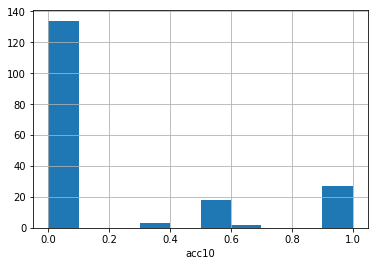

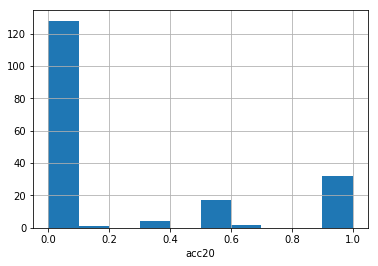

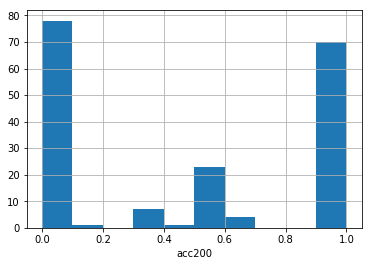

In [167]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [20]:
k = '59a7bc6d782b1b893a56a8b9'
print(k)
preds[k]

59a7bc6d782b1b893a56a8b9


['5984b6e9b6b11319d26384fc',
 '5984cfb3b6b1133796638540',
 '5984ce6fb6b1132a53638538',
 '5984c59ab6b11352c6638548',
 '5984c230b6b1132dae638514',
 '5984b924b6b1133c906384fb',
 '5984be78b6b1137daf638548',
 '5984c81fb6b1136c156384f2',
 '5984d4f6b6b1136a4e6384f5',
 '5984d476b6b1136531638550',
 '5984bdfeb6b11376d563851e',
 '5984c4cdb6b11348ad638536',
 '5984d241b6b1134f3c63850f',
 '5984c13db6b1131fc0638524',
 '5984b6f0b6b11319bd638539',
 '5984cd02b6b1131ee6638551',
 '5984cd52b6b1132246638523',
 '5984bad5b6b11350e6638516',
 '5984c540b6b1134f5e63854e',
 '5984b8f2b6b1133a48638505',
 '5984bd73b6b11371ff63854b',
 '5984c0e0b6b1131d2d6384f6',
 '5984bf7db6b11308db63853e',
 '5984b592b6b113049863854f',
 '5984c56bb6b11351c36384ef',
 '5984bc70b6b113659f6384fb',
 '5984c4e1b6b11349ad638536',
 '5984b6aeb6b113169e638538',
 '5984b5dcb6b11308316384ff',
 '5984bc20b6b1135fe0638515',
 '5984cc29b6b11318c4638551',
 '5984ba9db6b1134e93638523',
 '5984b7bfb6b113286a638502',
 '5984ddacb6b113355f638535',
 '5984bb3fb6b1

In [21]:
predict([k], lim=10**9)[k].index('5984c686b6b113599c63854c')

1111

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808